In [19]:
from pprint import pprint
import pandas as pd
import yfinance as yf
from tqdm import tqdm
import pandas_ta as ta
import math
import backtrader as bt
import datetime
import random
import numpy as np

In [20]:


#https://www.b3.com.br/pt_br/market-data-e-indices/servicos-de-dados/market-data/consultas/boletim-diario/dados-publicos-de-produtos-listados-e-de-balcao/
# Usamos apenas as colunas em que precisamos aplicar filtros
# O arquivo .csv não vem formatado em utf-8, então usamos o encoding = 'latin'
# Definimos o dtype da coluna CorpGovnLvlNm como string para não termos problema com a memória
df = pd.read_csv(
    'InstrumentsConsolidatedFile_20231204_1.csv',
    usecols= ['RptDt','TckrSymb', 'SgmtNm', 'SctyCtgyNm', 'TradgStartDt', 'CorpGovnLvlNm'],
    sep=';',
    encoding = 'latin',
    dtype={'CorpGovnLvlNm': 'str'})

# Filtramos SctyCtgyNm por ações e units (SHARES e UNIT)
# Filtramos SgmtNm por ações do mercado à vista (CASH)
# Filtramos os ativos cuja data de início da negociação seja anterior à data de publicação do arquivo .csv
# Filtramos as ações que não sejam negociadas no mercado de balcão
df = df[ ( (df['SctyCtgyNm'] == 'SHARES') | (df['SctyCtgyNm'] == 'UNIT') ) & (df['SgmtNm'] == 'CASH') & (df['RptDt'] >= df['TradgStartDt']) & (df['CorpGovnLvlNm'] != 'MERCADO DE BALCÃO') ]

df_listed_stocks = pd.DataFrame()
df_listed_stocks['Ticker'] = df['TckrSymb']

# Ativos de nome TAXA100, TAXA101, TAXA102 etc. não nos interessam
df_listed_stocks = df_listed_stocks[~df_listed_stocks['Ticker'].str.contains('TAXA')]

df_listed_stocks = df_listed_stocks['Ticker'].reset_index()
df_listed_stocks = df_listed_stocks.drop(columns=['index'])

df_listed_stocks.to_csv('b3_stocks.csv', index=False)

print(df_listed_stocks['Ticker'])

0      AALR3
1      ABCB4
2      ABEV3
3      AERI3
4      AESB3
       ...  
549    WLMM4
550    YBRA3
551    YBRA4
552    YDUQ3
553    ZAMP3
Name: Ticker, Length: 554, dtype: object


In [21]:
stock_list = [stock[0] +'.SA' for stock in df_listed_stocks.values]

pprint(stock_list[:10])

['AALR3.SA',
 'ABCB4.SA',
 'ABEV3.SA',
 'AERI3.SA',
 'AESB3.SA',
 'AESO3.SA',
 'AFLT3.SA',
 'AGRO3.SA',
 'AGXY3.SA',
 'AHEB3.SA']


In [22]:
len(df_listed_stocks['Ticker'].unique())

554

In [23]:
df.columns

Index(['RptDt', 'TckrSymb', 'SgmtNm', 'SctyCtgyNm', 'TradgStartDt',
       'CorpGovnLvlNm'],
      dtype='object')

In [24]:
start_date = '2022-01-01'
end_date = '2023-01-01'
df_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'ticker']
stocks_df = pd.DataFrame(columns=[df_cols])
stocks_df

,Open,High,Low,Close,Adj Close,Volume,ticker


In [25]:
for stock in tqdm(stock_list[:], desc="Processing"):
    print(stock)
    temp_df = yf.download(stock, start=start_date, end=end_date)
    if len(temp_df) != 0:
        temp_df = temp_df.assign(ticker = stock)
        stocks_df = pd.concat([stocks_df[df_cols], temp_df[df_cols]])

Processing:   0%|          | 0/554 [00:00<?, ?it/s]

AALR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   0%|          | 1/554 [00:00<05:28,  1.68it/s]


ABCB4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   0%|          | 2/554 [00:00<03:40,  2.51it/s]


ABEV3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   1%|          | 3/554 [00:01<03:00,  3.05it/s]


AERI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   1%|          | 4/554 [00:01<02:38,  3.46it/s]


AESB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   1%|          | 5/554 [00:01<02:29,  3.66it/s]


AESO3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['AESO3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:   1%|          | 6/554 [00:02<04:44,  1.93it/s]


AFLT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   1%|▏         | 7/554 [00:02<03:53,  2.34it/s]


AGRO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   1%|▏         | 8/554 [00:03<03:21,  2.71it/s]


AGXY3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   2%|▏         | 9/554 [00:03<02:57,  3.07it/s]


AHEB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   2%|▏         | 10/554 [00:03<02:40,  3.39it/s]


AHEB5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   2%|▏         | 11/554 [00:03<02:27,  3.67it/s]


AHEB6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   2%|▏         | 12/554 [00:03<02:20,  3.85it/s]


ALLD3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   2%|▏         | 13/554 [00:04<02:17,  3.93it/s]


ALOS3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['ALOS3.SA']: Exception("%ticker%: Data doesn't exist for startDate = 1641006000, endDate = 1672542000")
Processing:   3%|▎         | 14/554 [00:04<03:19,  2.70it/s]


ALOS99.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['ALOS99.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:   3%|▎         | 15/554 [00:05<04:04,  2.20it/s]


ALPA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   3%|▎         | 16/554 [00:05<03:40,  2.44it/s]


ALPA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   3%|▎         | 17/554 [00:06<03:18,  2.71it/s]


ALPK3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   3%|▎         | 18/554 [00:06<03:00,  2.97it/s]


ALUP11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   3%|▎         | 19/554 [00:06<02:48,  3.17it/s]


ALUP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   4%|▎         | 20/554 [00:06<02:36,  3.41it/s]


ALUP4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   4%|▍         | 21/554 [00:07<02:28,  3.59it/s]


AMAR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   4%|▍         | 22/554 [00:07<02:28,  3.58it/s]


AMBP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   4%|▍         | 23/554 [00:07<02:20,  3.77it/s]


AMER3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   4%|▍         | 24/554 [00:07<02:16,  3.88it/s]


ANIM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   5%|▍         | 25/554 [00:08<02:12,  4.00it/s]


APER3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   5%|▍         | 26/554 [00:08<02:11,  4.02it/s]


APTI3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['APTI3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:   5%|▍         | 27/554 [00:08<03:13,  2.72it/s]


APTI4.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['APTI4.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:   5%|▌         | 28/554 [00:09<03:56,  2.22it/s]


ARML3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   5%|▌         | 29/554 [00:09<03:21,  2.60it/s]


ARZZ3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   5%|▌         | 30/554 [00:10<02:59,  2.92it/s]


ASAI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   6%|▌         | 31/554 [00:10<02:41,  3.24it/s]


ATMP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   6%|▌         | 32/554 [00:10<02:29,  3.50it/s]


ATOM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   6%|▌         | 33/554 [00:10<02:20,  3.71it/s]


AURE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   6%|▌         | 34/554 [00:11<02:14,  3.87it/s]


AVLL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   6%|▋         | 35/554 [00:11<02:08,  4.03it/s]


AZEV3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   6%|▋         | 36/554 [00:11<02:10,  3.97it/s]


AZEV4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   7%|▋         | 37/554 [00:11<02:07,  4.06it/s]


AZUL4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   7%|▋         | 38/554 [00:11<02:03,  4.18it/s]


B3SA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   7%|▋         | 39/554 [00:12<02:03,  4.15it/s]


BAHI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   7%|▋         | 40/554 [00:12<02:04,  4.14it/s]


BALM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   7%|▋         | 41/554 [00:12<02:06,  4.05it/s]


BALM4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   8%|▊         | 42/554 [00:12<02:05,  4.08it/s]


BAUH3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   8%|▊         | 43/554 [00:13<02:04,  4.10it/s]


BAUH4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   8%|▊         | 44/554 [00:13<02:02,  4.15it/s]


BAZA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   8%|▊         | 45/554 [00:13<02:04,  4.09it/s]


BBAS11.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['BBAS11.SA']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-01-01 -> 2023-01-01)')
Processing:   8%|▊         | 46/554 [00:13<02:00,  4.22it/s]


BBAS12.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['BBAS12.SA']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-01-01 -> 2023-01-01)')
Processing:   8%|▊         | 47/554 [00:14<01:57,  4.32it/s]


BBAS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   9%|▊         | 48/554 [00:14<02:00,  4.21it/s]


BBDC3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   9%|▉         | 49/554 [00:14<02:02,  4.12it/s]


BBDC4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   9%|▉         | 50/554 [00:14<02:11,  3.82it/s]


BBML3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['BBML3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:   9%|▉         | 51/554 [00:15<03:06,  2.70it/s]


BBSE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:   9%|▉         | 52/554 [00:15<02:55,  2.86it/s]


BDLL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  10%|▉         | 53/554 [00:16<02:37,  3.19it/s]


BDLL4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  10%|▉         | 54/554 [00:16<02:24,  3.47it/s]


BEEF3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  10%|▉         | 55/554 [00:16<02:18,  3.60it/s]


BEES3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  10%|█         | 56/554 [00:16<02:20,  3.55it/s]


BEES4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  10%|█         | 57/554 [00:17<02:14,  3.71it/s]


BETP3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['BETP3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  10%|█         | 58/554 [00:17<03:08,  2.63it/s]


BGIP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  11%|█         | 59/554 [00:17<02:47,  2.95it/s]


BGIP4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  11%|█         | 60/554 [00:18<02:33,  3.22it/s]


BHIA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  11%|█         | 61/554 [00:18<02:21,  3.48it/s]


BIOM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  11%|█         | 62/554 [00:18<02:13,  3.68it/s]


BLAU3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  11%|█▏        | 63/554 [00:19<02:31,  3.24it/s]


BMEB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  12%|█▏        | 64/554 [00:19<02:24,  3.40it/s]


BMEB4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  12%|█▏        | 65/554 [00:19<02:16,  3.59it/s]


BMGB4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  12%|█▏        | 66/554 [00:19<02:10,  3.73it/s]


BMIN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  12%|█▏        | 67/554 [00:20<02:08,  3.80it/s]


BMIN4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  12%|█▏        | 68/554 [00:20<02:05,  3.86it/s]


BMKS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  12%|█▏        | 69/554 [00:20<02:03,  3.94it/s]


BMOB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  13%|█▎        | 70/554 [00:20<02:00,  4.01it/s]


BNBR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  13%|█▎        | 71/554 [00:21<01:59,  4.05it/s]


BOBR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  13%|█▎        | 72/554 [00:21<01:56,  4.13it/s]


BOBR4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  13%|█▎        | 73/554 [00:21<01:59,  4.03it/s]


BPAC11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  13%|█▎        | 74/554 [00:21<01:58,  4.06it/s]


BPAC3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  14%|█▎        | 75/554 [00:22<01:57,  4.09it/s]


BPAC5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  14%|█▎        | 76/554 [00:22<01:56,  4.11it/s]


BPAN4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  14%|█▍        | 77/554 [00:22<01:56,  4.10it/s]


BPAR3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['BPAR3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  14%|█▍        | 78/554 [00:23<02:51,  2.77it/s]


BRAP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  14%|█▍        | 79/554 [00:23<02:34,  3.07it/s]


BRAP4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  14%|█▍        | 80/554 [00:23<02:22,  3.33it/s]


BRBI11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  15%|█▍        | 81/554 [00:23<02:14,  3.52it/s]


BRFS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  15%|█▍        | 82/554 [00:24<02:08,  3.68it/s]


BRGE11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  15%|█▍        | 83/554 [00:24<02:03,  3.81it/s]


BRGE12.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  15%|█▌        | 84/554 [00:24<02:01,  3.86it/s]


BRGE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  15%|█▌        | 85/554 [00:24<01:59,  3.93it/s]


BRGE5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  16%|█▌        | 86/554 [00:25<01:58,  3.94it/s]


BRGE6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  16%|█▌        | 87/554 [00:25<01:55,  4.03it/s]


BRGE7.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  16%|█▌        | 88/554 [00:25<01:55,  4.05it/s]


BRGE8.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  16%|█▌        | 89/554 [00:25<01:55,  4.01it/s]


BRIT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  16%|█▌        | 90/554 [00:26<01:53,  4.07it/s]


BRIV3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  16%|█▋        | 91/554 [00:26<01:54,  4.04it/s]


BRIV4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  17%|█▋        | 92/554 [00:26<01:53,  4.06it/s]


BRKM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  17%|█▋        | 93/554 [00:26<01:54,  4.03it/s]


BRKM5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  17%|█▋        | 94/554 [00:27<01:53,  4.06it/s]


BRKM6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  17%|█▋        | 95/554 [00:27<01:52,  4.08it/s]


BRQB3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['BRQB3.SA']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-01-01 -> 2023-01-01)')
Processing:  17%|█▋        | 96/554 [00:27<01:50,  4.15it/s]


BRSR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  18%|█▊        | 97/554 [00:27<01:51,  4.09it/s]


BRSR5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  18%|█▊        | 98/554 [00:28<01:54,  3.99it/s]


BRSR6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  18%|█▊        | 99/554 [00:28<01:54,  3.99it/s]


BSLI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  18%|█▊        | 100/554 [00:28<01:52,  4.02it/s]


BSLI4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  18%|█▊        | 101/554 [00:28<01:51,  4.06it/s]


CABI3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CABI3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  18%|█▊        | 102/554 [00:29<02:44,  2.75it/s]


CALI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  19%|█▊        | 103/554 [00:29<02:27,  3.05it/s]


CAMB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  19%|█▉        | 104/554 [00:29<02:16,  3.31it/s]


CAML3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  19%|█▉        | 105/554 [00:30<02:07,  3.52it/s]


CASH3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  19%|█▉        | 106/554 [00:30<02:40,  2.79it/s]


CASN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  19%|█▉        | 107/554 [00:30<02:25,  3.07it/s]


CASN4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  19%|█▉        | 108/554 [00:31<02:14,  3.32it/s]


CATA3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CATA3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  20%|█▉        | 109/554 [00:31<02:58,  2.49it/s]


CATA4.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CATA4.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  20%|█▉        | 110/554 [00:32<03:31,  2.10it/s]


CBAV3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  20%|██        | 111/554 [00:32<02:59,  2.47it/s]


CBEE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  20%|██        | 112/554 [00:32<02:40,  2.76it/s]


CCRO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  20%|██        | 113/554 [00:33<02:24,  3.06it/s]


CEAB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  21%|██        | 114/554 [00:33<02:14,  3.28it/s]


CEBR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  21%|██        | 115/554 [00:33<02:05,  3.49it/s]


CEBR5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  21%|██        | 116/554 [00:33<02:00,  3.62it/s]


CEBR6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  21%|██        | 117/554 [00:34<01:56,  3.76it/s]


CEDO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  21%|██▏       | 118/554 [00:34<01:52,  3.87it/s]


CEDO4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  21%|██▏       | 119/554 [00:34<01:50,  3.94it/s]


CEEB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  22%|██▏       | 120/554 [00:34<01:51,  3.89it/s]


CEEB5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  22%|██▏       | 121/554 [00:35<01:48,  3.98it/s]


CEEB6.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CEEB6.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  22%|██▏       | 122/554 [00:35<02:39,  2.71it/s]


CEED3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  22%|██▏       | 123/554 [00:36<02:21,  3.05it/s]


CEED4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  22%|██▏       | 124/554 [00:36<02:08,  3.36it/s]


CEGR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  23%|██▎       | 125/554 [00:36<02:02,  3.51it/s]


CGAS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  23%|██▎       | 126/554 [00:36<01:56,  3.67it/s]


CGAS5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  23%|██▎       | 127/554 [00:37<01:53,  3.75it/s]


CGEE3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CGEE3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  23%|██▎       | 128/554 [00:37<02:40,  2.65it/s]


CGEE4.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CGEE4.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  23%|██▎       | 129/554 [00:38<03:57,  1.79it/s]


CGRA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  23%|██▎       | 130/554 [00:38<03:18,  2.14it/s]


CGRA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  24%|██▎       | 131/554 [00:39<02:51,  2.46it/s]


CIEL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  24%|██▍       | 132/554 [00:39<02:32,  2.77it/s]


CLSA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  24%|██▍       | 133/554 [00:39<02:15,  3.11it/s]


CLSC3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  24%|██▍       | 134/554 [00:39<02:06,  3.33it/s]


CLSC4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  24%|██▍       | 135/554 [00:40<02:01,  3.45it/s]


CMIG3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  25%|██▍       | 136/554 [00:40<01:57,  3.56it/s]


CMIG4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  25%|██▍       | 137/554 [00:40<01:54,  3.64it/s]


CMIN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  25%|██▍       | 138/554 [00:40<01:50,  3.77it/s]


CMSA3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CMSA3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  25%|██▌       | 139/554 [00:41<02:37,  2.64it/s]


CMSA4.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CMSA4.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  25%|██▌       | 140/554 [00:42<03:16,  2.11it/s]


COCE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  25%|██▌       | 141/554 [00:42<03:26,  2.00it/s]


COCE5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  26%|██▌       | 142/554 [00:43<02:55,  2.35it/s]


COCE6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  26%|██▌       | 143/554 [00:43<02:33,  2.67it/s]


COGN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  26%|██▌       | 144/554 [00:43<02:15,  3.02it/s]


COMR3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['COMR3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  26%|██▌       | 145/554 [00:44<02:55,  2.33it/s]


CORR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  26%|██▋       | 146/554 [00:44<02:32,  2.67it/s]


CORR4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  27%|██▋       | 147/554 [00:44<02:18,  2.93it/s]


CPFE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  27%|██▋       | 148/554 [00:45<02:09,  3.15it/s]


CPLE11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  27%|██▋       | 149/554 [00:45<01:58,  3.42it/s]


CPLE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  27%|██▋       | 150/554 [00:45<01:54,  3.53it/s]


CPLE5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  27%|██▋       | 151/554 [00:45<01:49,  3.68it/s]


CPLE6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  27%|██▋       | 152/554 [00:46<01:47,  3.72it/s]


CRFB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  28%|██▊       | 153/554 [00:46<01:44,  3.83it/s]


CRIV3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  28%|██▊       | 154/554 [00:46<01:47,  3.73it/s]


CRIV4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  28%|██▊       | 155/554 [00:47<02:19,  2.87it/s]


CRPG3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  28%|██▊       | 156/554 [00:47<02:06,  3.15it/s]


CRPG5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  28%|██▊       | 157/554 [00:47<02:02,  3.24it/s]


CRPG6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  29%|██▊       | 158/554 [00:47<01:54,  3.46it/s]


CRTE3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CRTE3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  29%|██▊       | 159/554 [00:48<02:37,  2.51it/s]


CRTE5.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CRTE5.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  29%|██▉       | 160/554 [00:49<03:08,  2.09it/s]


CSAB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  29%|██▉       | 161/554 [00:49<02:39,  2.46it/s]


CSAB4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  29%|██▉       | 162/554 [00:49<02:20,  2.80it/s]


CSAN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  29%|██▉       | 163/554 [00:49<02:08,  3.04it/s]


CSED3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  30%|██▉       | 164/554 [00:50<01:57,  3.33it/s]


CSMG3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  30%|██▉       | 165/554 [00:50<01:50,  3.53it/s]


CSNA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  30%|██▉       | 166/554 [00:50<01:47,  3.60it/s]


CSRN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  30%|███       | 167/554 [00:50<01:43,  3.73it/s]


CSRN5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  30%|███       | 168/554 [00:51<01:41,  3.79it/s]


CSRN6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  31%|███       | 169/554 [00:51<01:39,  3.88it/s]


CSUD3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  31%|███       | 170/554 [00:51<01:38,  3.91it/s]


CTBA11B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CTBA11B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  31%|███       | 171/554 [00:52<02:21,  2.71it/s]


CTCA3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CTCA3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  31%|███       | 172/554 [00:52<02:53,  2.20it/s]


CTKA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  31%|███       | 173/554 [00:53<02:28,  2.56it/s]


CTKA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  31%|███▏      | 174/554 [00:53<02:11,  2.88it/s]


CTNM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  32%|███▏      | 175/554 [00:53<01:59,  3.18it/s]


CTNM4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  32%|███▏      | 176/554 [00:53<01:49,  3.44it/s]


CTSA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  32%|███▏      | 177/554 [00:54<01:44,  3.61it/s]


CTSA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  32%|███▏      | 178/554 [00:54<01:41,  3.72it/s]


CURY3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  32%|███▏      | 179/554 [00:54<01:37,  3.83it/s]


CVCB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  32%|███▏      | 180/554 [00:54<01:35,  3.91it/s]


CXSE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  33%|███▎      | 181/554 [00:55<01:32,  4.03it/s]


CYRE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  33%|███▎      | 182/554 [00:55<01:32,  4.04it/s]


DASA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  33%|███▎      | 183/554 [00:55<01:33,  3.96it/s]


DESK3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  33%|███▎      | 184/554 [00:55<01:31,  4.06it/s]


DEXP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  33%|███▎      | 185/554 [00:56<01:30,  4.08it/s]


DEXP4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  34%|███▎      | 186/554 [00:56<01:30,  4.08it/s]


DIRR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  34%|███▍      | 187/554 [00:56<01:30,  4.04it/s]


DMFN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  34%|███▍      | 188/554 [00:56<01:29,  4.10it/s]


DMVF3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  34%|███▍      | 189/554 [00:57<01:28,  4.10it/s]


DOHL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  34%|███▍      | 190/554 [00:57<01:28,  4.10it/s]


DOHL4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  34%|███▍      | 191/554 [00:57<01:30,  4.00it/s]


DOTZ3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  35%|███▍      | 192/554 [00:57<01:28,  4.09it/s]


DTCY3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  35%|███▍      | 193/554 [00:58<01:25,  4.21it/s]


DTCY4.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['DTCY4.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  35%|███▌      | 194/554 [00:58<02:09,  2.79it/s]


DXCO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  35%|███▌      | 195/554 [00:58<01:58,  3.03it/s]


EALT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  35%|███▌      | 196/554 [00:59<01:48,  3.29it/s]


EALT4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  36%|███▌      | 197/554 [00:59<01:42,  3.49it/s]


ECOR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  36%|███▌      | 198/554 [00:59<01:37,  3.65it/s]


EGIE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  36%|███▌      | 199/554 [00:59<01:34,  3.76it/s]


EKTR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  36%|███▌      | 200/554 [01:00<01:34,  3.76it/s]


EKTR4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  36%|███▋      | 201/554 [01:00<01:31,  3.86it/s]


ELET3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  36%|███▋      | 202/554 [01:00<01:29,  3.92it/s]


ELET5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  37%|███▋      | 203/554 [01:00<01:29,  3.93it/s]


ELET6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  37%|███▋      | 204/554 [01:01<01:27,  3.99it/s]


ELMD3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  37%|███▋      | 205/554 [01:01<01:25,  4.06it/s]


EMAE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  37%|███▋      | 206/554 [01:01<01:26,  4.04it/s]


EMAE4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  37%|███▋      | 207/554 [01:01<01:25,  4.06it/s]


EMBR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  38%|███▊      | 208/554 [01:02<01:25,  4.07it/s]


ENAT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  38%|███▊      | 209/554 [01:02<01:24,  4.09it/s]


ENEV3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  38%|███▊      | 210/554 [01:02<01:23,  4.14it/s]


ENGI11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  38%|███▊      | 211/554 [01:02<01:23,  4.12it/s]


ENGI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  38%|███▊      | 212/554 [01:03<01:24,  4.03it/s]


ENGI4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  38%|███▊      | 213/554 [01:03<01:24,  4.06it/s]


ENJU3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  39%|███▊      | 214/554 [01:03<01:22,  4.13it/s]


ENMT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  39%|███▉      | 215/554 [01:03<01:24,  4.01it/s]


ENMT4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  39%|███▉      | 216/554 [01:04<01:23,  4.04it/s]


EPAR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  39%|███▉      | 217/554 [01:04<01:24,  4.00it/s]


EQMA3B.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  39%|███▉      | 218/554 [01:04<01:23,  4.02it/s]


EQMA5B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['EQMA5B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  40%|███▉      | 219/554 [01:05<02:03,  2.72it/s]


EQMA6B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['EQMA6B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  40%|███▉      | 220/554 [01:05<02:30,  2.22it/s]


EQPA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  40%|███▉      | 221/554 [01:06<02:10,  2.56it/s]


EQPA5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  40%|████      | 222/554 [01:06<01:58,  2.81it/s]


EQPA6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  40%|████      | 223/554 [01:06<01:46,  3.10it/s]


EQPA7.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  40%|████      | 224/554 [01:06<01:42,  3.21it/s]


EQTL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  41%|████      | 225/554 [01:07<01:37,  3.37it/s]


ESPA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  41%|████      | 226/554 [01:07<01:30,  3.61it/s]


ESTR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  41%|████      | 227/554 [01:07<01:26,  3.78it/s]


ESTR4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  41%|████      | 228/554 [01:07<01:23,  3.92it/s]


ETER3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  41%|████▏     | 229/554 [01:08<01:22,  3.92it/s]


EUCA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  42%|████▏     | 230/554 [01:08<01:30,  3.58it/s]


EUCA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  42%|████▏     | 231/554 [01:08<01:31,  3.52it/s]


EUFA3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['EUFA3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  42%|████▏     | 232/554 [01:09<02:12,  2.43it/s]


EVEN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  42%|████▏     | 233/554 [01:09<01:58,  2.71it/s]


EZTC3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  42%|████▏     | 234/554 [01:10<01:46,  2.99it/s]


FESA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  42%|████▏     | 235/554 [01:10<01:38,  3.22it/s]


FESA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  43%|████▎     | 236/554 [01:10<01:32,  3.44it/s]


FHER3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  43%|████▎     | 237/554 [01:10<01:26,  3.65it/s]


FIEI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  43%|████▎     | 238/554 [01:11<01:22,  3.82it/s]


FIGE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  43%|████▎     | 239/554 [01:11<01:20,  3.89it/s]


FIGE4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  43%|████▎     | 240/554 [01:11<01:19,  3.94it/s]


FIQE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  44%|████▎     | 241/554 [01:11<01:17,  4.05it/s]


FLRY3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  44%|████▎     | 242/554 [01:11<01:17,  4.02it/s]


FRAS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  44%|████▍     | 243/554 [01:12<01:18,  3.98it/s]


FRIO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  44%|████▍     | 244/554 [01:12<01:18,  3.97it/s]


FRRN3B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['FRRN3B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  44%|████▍     | 245/554 [01:13<01:55,  2.66it/s]


FRRN5B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['FRRN5B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  44%|████▍     | 246/554 [01:14<02:47,  1.84it/s]


FRRN6B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['FRRN6B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  45%|████▍     | 247/554 [01:14<02:57,  1.73it/s]


FRTA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  45%|████▍     | 248/554 [01:15<02:29,  2.05it/s]


GEPA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  45%|████▍     | 249/554 [01:15<02:06,  2.41it/s]


GEPA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  45%|████▌     | 250/554 [01:15<01:50,  2.76it/s]


GFSA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  45%|████▌     | 251/554 [01:15<01:39,  3.06it/s]


GGBR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  45%|████▌     | 252/554 [01:16<01:37,  3.11it/s]


GGBR4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  46%|████▌     | 253/554 [01:16<01:32,  3.25it/s]


GGPS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  46%|████▌     | 254/554 [01:16<01:52,  2.67it/s]


GMAT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  46%|████▌     | 255/554 [01:17<01:39,  3.01it/s]


GOAU3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  46%|████▌     | 256/554 [01:17<01:32,  3.21it/s]


GOAU4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  46%|████▋     | 257/554 [01:17<01:29,  3.33it/s]


GOLL3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['GOLL3.SA']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
Processing:  47%|████▋     | 258/554 [01:17<01:25,  3.46it/s]


GOLL4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  47%|████▋     | 259/554 [01:18<01:22,  3.58it/s]


GPAR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  47%|████▋     | 260/554 [01:18<01:17,  3.77it/s]


GRAO3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['GRAO3.SA']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
Processing:  47%|████▋     | 261/554 [01:18<01:13,  3.96it/s]


GRND3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  47%|████▋     | 262/554 [01:18<01:13,  3.95it/s]


GSHP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  47%|████▋     | 263/554 [01:19<01:11,  4.05it/s]


GUAR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  48%|████▊     | 264/554 [01:19<01:12,  4.02it/s]


HAGA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  48%|████▊     | 265/554 [01:19<01:10,  4.10it/s]


HAGA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  48%|████▊     | 266/554 [01:19<01:09,  4.13it/s]


HAPV3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  48%|████▊     | 267/554 [01:20<01:08,  4.19it/s]


HAPV99.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['HAPV99.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  48%|████▊     | 268/554 [01:20<01:43,  2.77it/s]


HBOR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  49%|████▊     | 269/554 [01:20<01:33,  3.06it/s]


HBRE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  49%|████▊     | 270/554 [01:21<01:23,  3.38it/s]


HBSA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  49%|████▉     | 271/554 [01:21<01:18,  3.62it/s]


HBTS3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['HBTS3.SA']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-01-01 -> 2023-01-01)')
Processing:  49%|████▉     | 272/554 [01:21<01:12,  3.86it/s]


HBTS5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  49%|████▉     | 273/554 [01:21<01:11,  3.93it/s]


HBTS6.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['HBTS6.SA']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-01-01 -> 2023-01-01)')
Processing:  49%|████▉     | 274/554 [01:22<01:13,  3.82it/s]


HETA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  50%|████▉     | 275/554 [01:22<01:13,  3.81it/s]


HETA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  50%|████▉     | 276/554 [01:22<01:10,  3.95it/s]


HMOB3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['HMOB3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  50%|█████     | 277/554 [01:23<01:46,  2.61it/s]


HOOT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  50%|█████     | 278/554 [01:23<01:33,  2.95it/s]


HOOT4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  50%|█████     | 279/554 [01:23<01:25,  3.23it/s]


HYPE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  51%|█████     | 280/554 [01:24<01:19,  3.45it/s]


IFCM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  51%|█████     | 281/554 [01:24<01:14,  3.67it/s]


IGSN3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['IGSN3.SA']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-01-01 -> 2023-01-01)')
Processing:  51%|█████     | 282/554 [01:24<01:10,  3.85it/s]


IGTI11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  51%|█████     | 283/554 [01:24<01:08,  3.96it/s]


IGTI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  51%|█████▏    | 284/554 [01:25<01:08,  3.94it/s]


IGTI4.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['IGTI4.SA']: Exception("%ticker%: Data doesn't exist for startDate = 1641006000, endDate = 1672542000")
Processing:  51%|█████▏    | 285/554 [01:25<01:57,  2.29it/s]


INEP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  52%|█████▏    | 286/554 [01:26<01:39,  2.68it/s]


INEP4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  52%|█████▏    | 287/554 [01:26<01:28,  3.02it/s]


INNT3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['INNT3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  52%|█████▏    | 288/554 [01:27<02:15,  1.96it/s]


INTB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  52%|█████▏    | 289/554 [01:27<01:53,  2.34it/s]


IRBR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  52%|█████▏    | 290/554 [01:27<01:37,  2.71it/s]


ITSA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  53%|█████▎    | 291/554 [01:27<01:28,  2.98it/s]


ITSA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  53%|█████▎    | 292/554 [01:28<01:21,  3.22it/s]


ITUB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  53%|█████▎    | 293/554 [01:28<01:16,  3.40it/s]


ITUB4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  53%|█████▎    | 294/554 [01:28<01:12,  3.57it/s]


IVPR3B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['IVPR3B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  53%|█████▎    | 295/554 [01:29<01:39,  2.59it/s]


IVPR4B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['IVPR4B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  53%|█████▎    | 296/554 [01:30<01:59,  2.16it/s]


JALL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  54%|█████▎    | 297/554 [01:30<01:42,  2.51it/s]


JBSS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  54%|█████▍    | 298/554 [01:30<01:30,  2.82it/s]


JFEN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  54%|█████▍    | 299/554 [01:30<01:22,  3.11it/s]


JHSF3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  54%|█████▍    | 300/554 [01:31<01:16,  3.32it/s]


JOPA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  54%|█████▍    | 301/554 [01:31<01:12,  3.48it/s]


JOPA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  55%|█████▍    | 302/554 [01:31<01:10,  3.55it/s]


JSLG3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  55%|█████▍    | 303/554 [01:31<01:06,  3.75it/s]


KEPL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  55%|█████▍    | 304/554 [01:32<01:05,  3.79it/s]


KLAS3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['KLAS3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  55%|█████▌    | 305/554 [01:32<01:34,  2.64it/s]


KLBN11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  55%|█████▌    | 306/554 [01:32<01:23,  2.96it/s]


KLBN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  55%|█████▌    | 307/554 [01:33<01:16,  3.22it/s]


KLBN4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  56%|█████▌    | 308/554 [01:33<01:12,  3.41it/s]


KRSA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  56%|█████▌    | 309/554 [01:33<01:07,  3.62it/s]


LAND3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  56%|█████▌    | 310/554 [01:33<01:05,  3.75it/s]


LAVV3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  56%|█████▌    | 311/554 [01:34<01:02,  3.89it/s]


LEVE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  56%|█████▋    | 312/554 [01:34<01:02,  3.87it/s]


LIGT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  56%|█████▋    | 313/554 [01:34<01:01,  3.92it/s]


LIPR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  57%|█████▋    | 314/554 [01:34<01:02,  3.86it/s]


LJQQ3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  57%|█████▋    | 315/554 [01:35<01:00,  3.97it/s]


LLBI3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['LLBI3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  57%|█████▋    | 316/554 [01:36<02:11,  1.80it/s]


LMED3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['LMED3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  57%|█████▋    | 317/554 [01:37<02:17,  1.73it/s]


LOGG3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  57%|█████▋    | 318/554 [01:37<01:53,  2.09it/s]


LOGN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  58%|█████▊    | 319/554 [01:37<01:35,  2.46it/s]


LPSB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  58%|█████▊    | 320/554 [01:37<01:24,  2.77it/s]


LREN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  58%|█████▊    | 321/554 [01:38<01:18,  2.95it/s]


LTEL3B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['LTEL3B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  58%|█████▊    | 322/554 [01:38<01:39,  2.33it/s]


LTLA3B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['LTLA3B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  58%|█████▊    | 323/554 [01:39<01:54,  2.02it/s]


LUPA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  58%|█████▊    | 324/554 [01:39<01:34,  2.42it/s]


LUXM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  59%|█████▊    | 325/554 [01:39<01:23,  2.74it/s]


LUXM4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  59%|█████▉    | 326/554 [01:40<01:14,  3.05it/s]


LVTC3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  59%|█████▉    | 327/554 [01:40<01:08,  3.30it/s]


LWSA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  59%|█████▉    | 328/554 [01:40<01:03,  3.54it/s]


MAPT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  59%|█████▉    | 329/554 [01:40<01:00,  3.71it/s]


MAPT4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  60%|█████▉    | 330/554 [01:41<00:57,  3.87it/s]


MATD3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  60%|█████▉    | 331/554 [01:41<01:00,  3.70it/s]


MBLY3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  60%|█████▉    | 332/554 [01:41<00:57,  3.89it/s]


MCRJ11B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['MCRJ11B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  60%|██████    | 333/554 [01:42<01:23,  2.63it/s]


MDIA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  60%|██████    | 334/554 [01:42<01:15,  2.93it/s]


MDNE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  60%|██████    | 335/554 [01:42<01:06,  3.27it/s]


MEAL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  61%|██████    | 336/554 [01:42<01:04,  3.40it/s]


MELK3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  61%|██████    | 337/554 [01:43<01:02,  3.45it/s]


MERC3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  61%|██████    | 338/554 [01:43<01:00,  3.57it/s]


MERC4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  61%|██████    | 339/554 [01:43<00:57,  3.71it/s]


MGEL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  61%|██████▏   | 340/554 [01:43<00:55,  3.85it/s]


MGEL4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  62%|██████▏   | 341/554 [01:44<00:53,  4.02it/s]


MGLU3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  62%|██████▏   | 342/554 [01:44<00:52,  4.04it/s]


MILS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  62%|██████▏   | 343/554 [01:44<00:51,  4.06it/s]


MLAS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  62%|██████▏   | 344/554 [01:44<00:51,  4.12it/s]


MMAQ3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  62%|██████▏   | 345/554 [01:45<00:52,  4.00it/s]


MMAQ4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  62%|██████▏   | 346/554 [01:45<00:52,  3.93it/s]


MNDL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  63%|██████▎   | 347/554 [01:45<00:54,  3.79it/s]


MNPR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  63%|██████▎   | 348/554 [01:45<00:52,  3.93it/s]


MNZC3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['MNZC3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  63%|██████▎   | 349/554 [01:46<01:17,  2.64it/s]


MOAR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  63%|██████▎   | 350/554 [01:46<01:09,  2.92it/s]


MOVI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  63%|██████▎   | 351/554 [01:47<01:02,  3.23it/s]


MRFG3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  64%|██████▎   | 352/554 [01:47<00:58,  3.45it/s]


MRSA3B.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  64%|██████▎   | 353/554 [01:47<01:13,  2.73it/s]


MRSA5B.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  64%|██████▍   | 354/554 [01:48<01:06,  3.03it/s]


MRSA6B.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  64%|██████▍   | 355/554 [01:48<01:00,  3.27it/s]


MRVE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  64%|██████▍   | 356/554 [01:48<00:56,  3.48it/s]


MSPA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  64%|██████▍   | 357/554 [01:48<00:53,  3.67it/s]


MSPA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  65%|██████▍   | 358/554 [01:49<00:53,  3.66it/s]


MSRO3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['MSRO3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  65%|██████▍   | 359/554 [01:49<01:17,  2.52it/s]


MTRE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  65%|██████▍   | 360/554 [01:50<01:25,  2.26it/s]


MTSA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  65%|██████▌   | 361/554 [01:50<01:14,  2.59it/s]


MTSA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  65%|██████▌   | 362/554 [01:50<01:06,  2.88it/s]


MULT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  66%|██████▌   | 363/554 [01:51<01:00,  3.16it/s]


MWET3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  66%|██████▌   | 364/554 [01:51<00:54,  3.47it/s]


MWET4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  66%|██████▌   | 365/554 [01:51<00:51,  3.70it/s]


MYPK3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  66%|██████▌   | 366/554 [01:51<00:49,  3.80it/s]


NEMO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  66%|██████▌   | 367/554 [01:52<00:48,  3.86it/s]


NEMO5.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['NEMO5.SA']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
Processing:  66%|██████▋   | 368/554 [01:52<00:46,  3.99it/s]


NEMO6.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['NEMO6.SA']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
Processing:  67%|██████▋   | 369/554 [01:52<00:45,  4.10it/s]


NEOE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  67%|██████▋   | 370/554 [01:53<01:01,  3.01it/s]


NEXP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  67%|██████▋   | 371/554 [01:53<00:55,  3.30it/s]


NGRD3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  67%|██████▋   | 372/554 [01:53<00:51,  3.54it/s]


NINJ3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  67%|██████▋   | 373/554 [01:53<00:49,  3.68it/s]


NORD3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  68%|██████▊   | 374/554 [01:54<00:47,  3.82it/s]


NRTQ3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['NRTQ3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  68%|██████▊   | 375/554 [01:54<01:07,  2.63it/s]


NTCO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  68%|██████▊   | 376/554 [01:54<00:59,  2.98it/s]


NUTR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  68%|██████▊   | 377/554 [01:55<00:54,  3.27it/s]


ODER3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['ODER3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  68%|██████▊   | 378/554 [01:55<01:11,  2.45it/s]


ODER4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  68%|██████▊   | 379/554 [01:56<01:03,  2.78it/s]


ODPV3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  69%|██████▊   | 380/554 [01:56<00:57,  3.02it/s]


OFSA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  69%|██████▉   | 381/554 [01:56<00:53,  3.26it/s]


OIBR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  69%|██████▉   | 382/554 [01:56<00:50,  3.43it/s]


OIBR4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  69%|██████▉   | 383/554 [01:57<00:47,  3.60it/s]


ONCO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  69%|██████▉   | 384/554 [01:57<00:45,  3.77it/s]


OPCT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  69%|██████▉   | 385/554 [01:57<00:43,  3.91it/s]


OPGM3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['OPGM3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  70%|██████▉   | 386/554 [01:58<01:18,  2.15it/s]


OPSE3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['OPSE3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  70%|██████▉   | 387/554 [01:59<01:29,  1.87it/s]


OPTS3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['OPTS3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  70%|███████   | 388/554 [01:59<01:34,  1.76it/s]


ORVR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  70%|███████   | 389/554 [02:00<01:17,  2.13it/s]


OSXB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  70%|███████   | 390/554 [02:00<01:05,  2.50it/s]


PASS3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PASS3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  71%|███████   | 391/554 [02:00<01:18,  2.08it/s]


PASS5.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PASS5.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  71%|███████   | 392/554 [02:01<01:26,  1.87it/s]


PASS6.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PASS6.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  71%|███████   | 393/554 [02:02<01:31,  1.76it/s]


PATI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  71%|███████   | 394/554 [02:02<01:16,  2.10it/s]


PATI4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  71%|███████▏  | 395/554 [02:02<01:05,  2.44it/s]


PCAR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  71%|███████▏  | 396/554 [02:03<00:57,  2.74it/s]


PCAR99.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PCAR99.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  72%|███████▏  | 397/554 [02:03<01:10,  2.22it/s]


PDGR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  72%|███████▏  | 398/554 [02:03<01:00,  2.59it/s]


PDTC3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  72%|███████▏  | 399/554 [02:04<00:53,  2.90it/s]


PEAB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  72%|███████▏  | 400/554 [02:04<00:48,  3.15it/s]


PEAB4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  72%|███████▏  | 401/554 [02:04<00:45,  3.39it/s]


PETR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  73%|███████▎  | 402/554 [02:04<00:42,  3.58it/s]


PETR4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  73%|███████▎  | 403/554 [02:05<00:57,  2.64it/s]


PETZ3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  73%|███████▎  | 404/554 [02:05<00:50,  2.96it/s]


PFRM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  73%|███████▎  | 405/554 [02:06<00:46,  3.18it/s]


PGMN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  73%|███████▎  | 406/554 [02:06<00:56,  2.60it/s]


PINE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  73%|███████▎  | 407/554 [02:06<00:50,  2.92it/s]


PINE4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  74%|███████▎  | 408/554 [02:07<00:46,  3.16it/s]


PLAS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  74%|███████▍  | 409/554 [02:07<00:42,  3.42it/s]


PLPL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  74%|███████▍  | 410/554 [02:07<00:39,  3.63it/s]


PMAM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  74%|███████▍  | 411/554 [02:07<00:38,  3.73it/s]


PMSP11B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PMSP11B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  74%|███████▍  | 412/554 [02:08<00:54,  2.62it/s]


PMSP12B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PMSP12B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  75%|███████▍  | 413/554 [02:09<01:04,  2.18it/s]


PMSP13B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PMSP13B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  75%|███████▍  | 414/554 [02:09<01:16,  1.83it/s]


PNVL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  75%|███████▍  | 415/554 [02:10<01:03,  2.18it/s]


POMO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  75%|███████▌  | 416/554 [02:10<00:55,  2.50it/s]


POMO4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  75%|███████▌  | 417/554 [02:10<00:48,  2.81it/s]


PORT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  75%|███████▌  | 418/554 [02:10<00:43,  3.12it/s]


POSI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  76%|███████▌  | 419/554 [02:11<00:40,  3.34it/s]


PPAR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  76%|███████▌  | 420/554 [02:11<00:37,  3.53it/s]


PPLA11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  76%|███████▌  | 421/554 [02:11<00:35,  3.72it/s]


PRIO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  76%|███████▌  | 422/554 [02:11<00:34,  3.87it/s]


PRMN3B.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PRMN3B.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  76%|███████▋  | 423/554 [02:12<00:48,  2.69it/s]


PRNR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  77%|███████▋  | 424/554 [02:12<00:43,  3.01it/s]


PRPT3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PRPT3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  77%|███████▋  | 425/554 [02:13<00:55,  2.34it/s]


PSSA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  77%|███████▋  | 426/554 [02:13<00:47,  2.68it/s]


PSVM11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  77%|███████▋  | 427/554 [02:13<00:42,  3.01it/s]


PTBL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  77%|███████▋  | 428/554 [02:14<00:40,  3.14it/s]


PTCA11.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PTCA11.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  77%|███████▋  | 429/554 [02:14<00:53,  2.35it/s]


PTCA3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PTCA3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  78%|███████▊  | 430/554 [02:15<01:09,  1.79it/s]


PTNT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  78%|███████▊  | 431/554 [02:15<00:57,  2.13it/s]


PTNT4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  78%|███████▊  | 432/554 [02:16<00:49,  2.48it/s]


QUAL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  78%|███████▊  | 433/554 [02:16<00:53,  2.26it/s]


QUSW3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['QUSW3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  78%|███████▊  | 434/554 [02:17<01:00,  2.00it/s]


QVQP3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['QVQP3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  79%|███████▊  | 435/554 [02:18<01:05,  1.83it/s]


RADL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  79%|███████▊  | 436/554 [02:18<00:55,  2.13it/s]


RAIL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  79%|███████▉  | 437/554 [02:18<00:46,  2.50it/s]


RAIZ4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  79%|███████▉  | 438/554 [02:18<00:40,  2.85it/s]


RANI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  79%|███████▉  | 439/554 [02:19<00:38,  3.02it/s]


RAPT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  79%|███████▉  | 440/554 [02:19<00:35,  3.18it/s]


RAPT4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  80%|███████▉  | 441/554 [02:19<00:34,  3.30it/s]


RBNS11.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['RBNS11.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  80%|███████▉  | 442/554 [02:20<00:45,  2.49it/s]


RCSL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  80%|███████▉  | 443/554 [02:20<00:38,  2.85it/s]


RCSL4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  80%|████████  | 444/554 [02:20<00:35,  3.13it/s]


RDNI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  80%|████████  | 445/554 [02:20<00:32,  3.33it/s]


RDOR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  81%|████████  | 446/554 [02:21<00:30,  3.56it/s]


RECV3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  81%|████████  | 447/554 [02:21<00:29,  3.68it/s]


REDE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  81%|████████  | 448/554 [02:21<00:27,  3.79it/s]


RENT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  81%|████████  | 449/554 [02:21<00:27,  3.86it/s]


RNEW11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  81%|████████  | 450/554 [02:22<00:26,  3.96it/s]


RNEW3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  81%|████████▏ | 451/554 [02:22<00:25,  3.99it/s]


RNEW4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  82%|████████▏ | 452/554 [02:22<00:24,  4.12it/s]


ROMI3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  82%|████████▏ | 453/554 [02:22<00:24,  4.05it/s]


RPAD3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  82%|████████▏ | 454/554 [02:23<00:25,  3.96it/s]


RPAD5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  82%|████████▏ | 455/554 [02:23<00:24,  3.99it/s]


RPAD6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  82%|████████▏ | 456/554 [02:23<00:24,  4.02it/s]


RPMG3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  82%|████████▏ | 457/554 [02:23<00:23,  4.04it/s]


RRRP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  83%|████████▎ | 458/554 [02:24<00:23,  4.10it/s]


RSID3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  83%|████████▎ | 459/554 [02:24<00:23,  3.98it/s]


RSUL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  83%|████████▎ | 460/554 [02:24<00:23,  4.08it/s]


RSUL4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  83%|████████▎ | 461/554 [02:24<00:22,  4.05it/s]


SAEN3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['SAEN3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  83%|████████▎ | 462/554 [02:25<00:33,  2.73it/s]


SANB11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  84%|████████▎ | 463/554 [02:25<00:30,  3.03it/s]


SANB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  84%|████████▍ | 464/554 [02:26<00:27,  3.25it/s]


SANB4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  84%|████████▍ | 465/554 [02:26<00:26,  3.38it/s]


SAPR11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  84%|████████▍ | 466/554 [02:26<00:24,  3.55it/s]


SAPR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  84%|████████▍ | 467/554 [02:26<00:23,  3.72it/s]


SAPR4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  84%|████████▍ | 468/554 [02:27<00:22,  3.81it/s]


SBFG3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  85%|████████▍ | 469/554 [02:27<00:21,  3.93it/s]


SBSP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  85%|████████▍ | 470/554 [02:27<00:21,  3.95it/s]


SCAR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  85%|████████▌ | 471/554 [02:27<00:20,  3.97it/s]


SEER3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  85%|████████▌ | 472/554 [02:28<00:20,  4.05it/s]


SEQL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  85%|████████▌ | 473/554 [02:28<00:19,  4.10it/s]


SGPS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  86%|████████▌ | 474/554 [02:28<00:19,  4.18it/s]


SHOW3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  86%|████████▌ | 475/554 [02:28<00:18,  4.18it/s]


SHUL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  86%|████████▌ | 476/554 [02:28<00:18,  4.14it/s]


SHUL4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  86%|████████▌ | 477/554 [02:29<00:18,  4.06it/s]


SIMH3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  86%|████████▋ | 478/554 [02:29<00:18,  4.12it/s]


SLCE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  86%|████████▋ | 479/554 [02:29<00:18,  4.13it/s]


SMFT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  87%|████████▋ | 480/554 [02:29<00:17,  4.18it/s]


SMTO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  87%|████████▋ | 481/554 [02:30<00:17,  4.14it/s]


SNSY3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  87%|████████▋ | 482/554 [02:30<00:17,  4.21it/s]


SNSY5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  87%|████████▋ | 483/554 [02:30<00:16,  4.22it/s]


SNSY6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  87%|████████▋ | 484/554 [02:30<00:16,  4.22it/s]


SOJA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  88%|████████▊ | 485/554 [02:31<00:16,  4.17it/s]


SOMA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  88%|████████▊ | 486/554 [02:31<00:16,  4.18it/s]


SOND3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  88%|████████▊ | 487/554 [02:31<00:16,  4.13it/s]


SOND5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  88%|████████▊ | 488/554 [02:31<00:15,  4.15it/s]


SOND6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  88%|████████▊ | 489/554 [02:32<00:15,  4.11it/s]


SRNA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  88%|████████▊ | 490/554 [02:32<00:15,  4.16it/s]


STBP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  89%|████████▊ | 491/554 [02:32<00:15,  4.13it/s]


SUZB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  89%|████████▉ | 492/554 [02:32<00:15,  4.00it/s]


SYNE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  89%|████████▉ | 493/554 [02:33<00:15,  3.97it/s]


TAEE11.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  89%|████████▉ | 494/554 [02:33<00:15,  3.95it/s]


TAEE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  89%|████████▉ | 495/554 [02:33<00:15,  3.93it/s]


TAEE4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  90%|████████▉ | 496/554 [02:33<00:14,  3.97it/s]


TASA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  90%|████████▉ | 497/554 [02:34<00:14,  4.00it/s]


TASA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  90%|████████▉ | 498/554 [02:34<00:13,  4.01it/s]


TCSA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  90%|█████████ | 499/554 [02:34<00:13,  3.97it/s]


TECN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  90%|█████████ | 500/554 [02:34<00:14,  3.80it/s]


TEGA3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['TEGA3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  90%|█████████ | 501/554 [02:35<00:20,  2.61it/s]


TEKA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  91%|█████████ | 502/554 [02:35<00:17,  2.95it/s]


TEKA4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  91%|█████████ | 503/554 [02:36<00:15,  3.25it/s]


TELB3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  91%|█████████ | 504/554 [02:36<00:14,  3.46it/s]


TELB4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  91%|█████████ | 505/554 [02:36<00:13,  3.67it/s]


TEND3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  91%|█████████▏| 506/554 [02:36<00:12,  3.77it/s]


TFCO4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  92%|█████████▏| 507/554 [02:37<00:12,  3.85it/s]


TGMA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  92%|█████████▏| 508/554 [02:37<00:11,  3.87it/s]


TIMS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  92%|█████████▏| 509/554 [02:37<00:11,  3.93it/s]


TKNO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  92%|█████████▏| 510/554 [02:37<00:11,  3.92it/s]


TKNO4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  92%|█████████▏| 511/554 [02:38<00:11,  3.82it/s]


TOTS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  92%|█████████▏| 512/554 [02:38<00:10,  3.83it/s]


TPIS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  93%|█████████▎| 513/554 [02:38<00:10,  3.81it/s]


TRAD3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  93%|█████████▎| 514/554 [02:38<00:10,  3.81it/s]


TRIS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  93%|█████████▎| 515/554 [02:39<00:10,  3.88it/s]


TRPL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  93%|█████████▎| 516/554 [02:39<00:09,  3.89it/s]


TRPL4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  93%|█████████▎| 517/554 [02:39<00:10,  3.63it/s]


TTEN3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  94%|█████████▎| 518/554 [02:39<00:10,  3.47it/s]


TUPY3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  94%|█████████▎| 519/554 [02:40<00:09,  3.54it/s]


TXRX3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  94%|█████████▍| 520/554 [02:40<00:09,  3.71it/s]


TXRX4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  94%|█████████▍| 521/554 [02:40<00:08,  3.81it/s]


UCAS3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  94%|█████████▍| 522/554 [02:41<00:08,  3.83it/s]


UGPA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  94%|█████████▍| 523/554 [02:41<00:07,  3.90it/s]


UNIP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  95%|█████████▍| 524/554 [02:41<00:07,  3.85it/s]


UNIP5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  95%|█████████▍| 525/554 [02:41<00:07,  3.88it/s]


UNIP6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  95%|█████████▍| 526/554 [02:42<00:07,  3.94it/s]


UPKP3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['UPKP3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  95%|█████████▌| 527/554 [02:42<00:10,  2.63it/s]


USIM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  95%|█████████▌| 528/554 [02:42<00:08,  2.94it/s]


USIM5.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  95%|█████████▌| 529/554 [02:43<00:07,  3.20it/s]


USIM6.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  96%|█████████▌| 530/554 [02:43<00:07,  3.37it/s]


VALE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  96%|█████████▌| 531/554 [02:43<00:06,  3.46it/s]


VAMO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  96%|█████████▌| 532/554 [02:43<00:06,  3.55it/s]


VBBR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  96%|█████████▌| 533/554 [02:44<00:05,  3.67it/s]


VITT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  96%|█████████▋| 534/554 [02:44<00:05,  3.73it/s]


VIVA3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  97%|█████████▋| 535/554 [02:44<00:04,  3.81it/s]


VIVR3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  97%|█████████▋| 536/554 [02:44<00:04,  3.93it/s]


VIVT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  97%|█████████▋| 537/554 [02:45<00:04,  3.96it/s]


VLID3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  97%|█████████▋| 538/554 [02:45<00:04,  3.94it/s]


VSPT3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  97%|█████████▋| 539/554 [02:45<00:03,  3.98it/s]


VSPT4.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['VSPT4.SA']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
Processing:  97%|█████████▋| 540/554 [02:45<00:03,  4.13it/s]


VSTE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  98%|█████████▊| 541/554 [02:46<00:03,  4.15it/s]


VULC3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  98%|█████████▊| 542/554 [02:46<00:02,  4.05it/s]


VVEO3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  98%|█████████▊| 543/554 [02:46<00:02,  4.10it/s]


WEGE3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  98%|█████████▊| 544/554 [02:46<00:02,  4.04it/s]


WEST3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  98%|█████████▊| 545/554 [02:47<00:02,  4.10it/s]


WHRL3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  99%|█████████▊| 546/554 [02:47<00:01,  4.03it/s]


WHRL4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  99%|█████████▊| 547/554 [02:47<00:01,  3.98it/s]


WIZC3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  99%|█████████▉| 548/554 [02:47<00:01,  4.04it/s]


WLMM3.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  99%|█████████▉| 549/554 [02:48<00:01,  4.04it/s]


WLMM4.SA
[*********************100%%**********************]  1 of 1 completed

Processing:  99%|█████████▉| 550/554 [02:48<00:01,  3.91it/s]


YBRA3.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['YBRA3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing:  99%|█████████▉| 551/554 [02:49<00:01,  2.68it/s]


YBRA4.SA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['YBRA4.SA']: Exception("%ticker%: Data doesn't exist for startDate = 1641006000, endDate = 1672542000")
Processing: 100%|█████████▉| 552/554 [02:49<00:00,  2.19it/s]


YDUQ3.SA
[*********************100%%**********************]  1 of 1 completed

Processing: 100%|█████████▉| 553/554 [02:50<00:00,  2.53it/s]


ZAMP3.SA
[*********************100%%**********************]  1 of 1 completed

Processing: 100%|██████████| 554/554 [02:50<00:00,  3.25it/s]

In [26]:
stocks_df['ticker'].unique()

array(['AALR3.SA', 'ABCB4.SA', 'ABEV3.SA', 'AERI3.SA', 'AESB3.SA',
       'AFLT3.SA', 'AGRO3.SA', 'AGXY3.SA', 'AHEB3.SA', 'AHEB5.SA',
       'AHEB6.SA', 'ALLD3.SA', 'ALPA3.SA', 'ALPA4.SA', 'ALPK3.SA',
       'ALUP11.SA', 'ALUP3.SA', 'ALUP4.SA', 'AMAR3.SA', 'AMBP3.SA',
       'AMER3.SA', 'ANIM3.SA', 'APER3.SA', 'ARML3.SA', 'ARZZ3.SA',
       'ASAI3.SA', 'ATMP3.SA', 'ATOM3.SA', 'AURE3.SA', 'AVLL3.SA',
       'AZEV3.SA', 'AZEV4.SA', 'AZUL4.SA', 'B3SA3.SA', 'BAHI3.SA',
       'BALM3.SA', 'BALM4.SA', 'BAUH3.SA', 'BAUH4.SA', 'BAZA3.SA',
       'BBAS3.SA', 'BBDC3.SA', 'BBDC4.SA', 'BBSE3.SA', 'BDLL3.SA',
       'BDLL4.SA', 'BEEF3.SA', 'BEES3.SA', 'BEES4.SA', 'BGIP3.SA',
       'BGIP4.SA', 'BHIA3.SA', 'BIOM3.SA', 'BLAU3.SA', 'BMEB3.SA',
       'BMEB4.SA', 'BMGB4.SA', 'BMIN3.SA', 'BMIN4.SA', 'BMKS3.SA',
       'BMOB3.SA', 'BNBR3.SA', 'BOBR3.SA', 'BOBR4.SA', 'BPAC11.SA',
       'BPAC3.SA', 'BPAC5.SA', 'BPAN4.SA', 'BRAP3.SA', 'BRAP4.SA',
       'BRBI11.SA', 'BRFS3.SA', 'BRGE11.SA', 'BRGE12.SA', 'B

In [27]:
stocks_df.to_parquet('b3_stock_data.parquet')

In [28]:
stock_list = stocks_df['ticker'].unique()
stock_list

array(['AALR3.SA', 'ABCB4.SA', 'ABEV3.SA', 'AERI3.SA', 'AESB3.SA',
       'AFLT3.SA', 'AGRO3.SA', 'AGXY3.SA', 'AHEB3.SA', 'AHEB5.SA',
       'AHEB6.SA', 'ALLD3.SA', 'ALPA3.SA', 'ALPA4.SA', 'ALPK3.SA',
       'ALUP11.SA', 'ALUP3.SA', 'ALUP4.SA', 'AMAR3.SA', 'AMBP3.SA',
       'AMER3.SA', 'ANIM3.SA', 'APER3.SA', 'ARML3.SA', 'ARZZ3.SA',
       'ASAI3.SA', 'ATMP3.SA', 'ATOM3.SA', 'AURE3.SA', 'AVLL3.SA',
       'AZEV3.SA', 'AZEV4.SA', 'AZUL4.SA', 'B3SA3.SA', 'BAHI3.SA',
       'BALM3.SA', 'BALM4.SA', 'BAUH3.SA', 'BAUH4.SA', 'BAZA3.SA',
       'BBAS3.SA', 'BBDC3.SA', 'BBDC4.SA', 'BBSE3.SA', 'BDLL3.SA',
       'BDLL4.SA', 'BEEF3.SA', 'BEES3.SA', 'BEES4.SA', 'BGIP3.SA',
       'BGIP4.SA', 'BHIA3.SA', 'BIOM3.SA', 'BLAU3.SA', 'BMEB3.SA',
       'BMEB4.SA', 'BMGB4.SA', 'BMIN3.SA', 'BMIN4.SA', 'BMKS3.SA',
       'BMOB3.SA', 'BNBR3.SA', 'BOBR3.SA', 'BOBR4.SA', 'BPAC11.SA',
       'BPAC3.SA', 'BPAC5.SA', 'BPAN4.SA', 'BRAP3.SA', 'BRAP4.SA',
       'BRBI11.SA', 'BRFS3.SA', 'BRGE11.SA', 'BRGE12.SA', 'B

## Grasp Greedy Solution: stock selection

1 -  Evaluate the incremental costs of the candidate elements

In [29]:
sharpe_ratio_dict = {}

start_date = "2022-01-01"
end_date = "2022-12-30"

for stock in stock_list:
    df = stocks_df[stocks_df['ticker'] == stock]
    df = df.loc[start_date:end_date]
    try:
        sharpe_ratio = ta.sharpe_ratio(df['Close'])
        sharpe_ratio_dict[stock] = sharpe_ratio
    except:
        sharpe_ratio_dict[stock] = math.nan
sharpe_ratio_dict


# Remove items with NaN values
sharpe_ratio_dict = {key: value for key, value in sharpe_ratio_dict.items() if not math.isnan(value)}

# Sort the dictionary by values
sharpe_ratio_dict = sorted(sharpe_ratio_dict.items(), key=lambda x: x[1])

# Create a new dictionary with sorted values
sharpe_ratio_dict = {key: value for key, value in sharpe_ratio_dict}
sharpe_ratio_dict

C:\Users\Felps\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas_ta\utils\_metrics.py:208: RuntimeWarning: invalid value encountered in scalar divide
  return (period_mu - benchmark_rate) / period_std


{'CTSA4.SA': -3.0435783801089173,
 'RCSL4.SA': -2.4515915425923103,
 'TXRX3.SA': -2.3769338045736417,
 'KRSA3.SA': -2.278903747227344,
 'PDGR3.SA': -2.2487836231944174,
 'CSAB3.SA': -2.1708243375240377,
 'AERI3.SA': -2.060979136588289,
 'MERC3.SA': -2.002761334315933,
 'DOHL3.SA': -1.9306863479478928,
 'BRKM3.SA': -1.9209040473862466,
 'BGIP3.SA': -1.919572528584861,
 'ALLD3.SA': -1.854412895822023,
 'CTSA3.SA': -1.8525363788440792,
 'MAPT4.SA': -1.8022268910705121,
 'ESTR4.SA': -1.776913687685499,
 'MRSA6B.SA': -1.7573377132174388,
 'AHEB6.SA': -1.7201865793186093,
 'ESPA3.SA': -1.642522585939813,
 'BRFS3.SA': -1.6317167589589785,
 'BRKM5.SA': -1.6255422240312603,
 'MRFG3.SA': -1.6181161596726314,
 'AZEV3.SA': -1.6178004740594087,
 'IRBR3.SA': -1.599420890535876,
 'DASA3.SA': -1.582526361227319,
 'MRSA5B.SA': -1.5771957173882187,
 'ALPA3.SA': -1.5593836898989073,
 'SEQL3.SA': -1.5573934101599405,
 'NEXP3.SA': -1.5206422977607839,
 'OIBR3.SA': -1.4711054119865656,
 'WHRL4.SA': -1.46001

In [55]:
import pickle

def save_dictionary(filename, data):
    with open(filename, 'wb') as file:
        pickle.dump(data, file)

def load_dictionary(filename):
    with open(filename, 'rb') as file:
        loaded_data = pickle.load(file)
    return loaded_data



save_dictionary('sharpe_ratio_dict.pkl', sharpe_ratio_dict)

In [30]:
def greedy_portfolio(RLC_length = 150, portfolio_length = 15):
    #Solution
    portfolio = []

    #Initialize the set of candidate elements

    RLC = sorted(sharpe_ratio_dict.items(), key=lambda x: x[1], reverse=True)[:RLC_length]

    while len(portfolio) < portfolio_length:
        #Select an element s from the RCL at random;
        random_stock = random.choice(RLC)
        portfolio.append(random_stock)

        RLC.pop(RLC.index(random_stock))

    return portfolio

In [31]:
greedy_portfolio(RLC_length = 150, portfolio_length = 15)

[('CSRN3.SA', 0.8696611817741825),
 ('BPAC5.SA', 0.4861738634255448),
 ('INTB3.SA', 0.54290679268326),
 ('CMIG3.SA', 0.5704592608201235),
 ('MULT3.SA', 0.8139061553736507),
 ('PSSA3.SA', 0.6228327416162484),
 ('CSRN6.SA', 0.6383042994104101),
 ('VULC3.SA', 1.0836556507388924),
 ('PTBL3.SA', 0.15714672154603423),
 ('PRNR3.SA', 0.2298942605638325),
 ('TECN3.SA', 0.25274228958498113),
 ('MNPR3.SA', 0.21742835093747925),
 ('ASAI3.SA', 1.3857577012768687),
 ('PORT3.SA', 0.7241307411512249),
 ('EQPA7.SA', 0.6028605716181213)]

In [32]:
portfolio_length = 7
def generate_random_solution(portfolio_length , bin_str_size = 7):
    bin_string = ''
    for letter in range(portfolio_length):
        binary_letter_string = "".join(str(np.random.randint(0,2)) for i in range(bin_str_size))
        bin_string = bin_string + binary_letter_string
    return bin_string

generate_random_solution(portfolio_length)

'1101101010011110101110011001000111000000101110100'

In [33]:
def decode_binary_to_weights(solution, bin_str_size = 7):
    while True:
        try:
            weight_list = []
            for pos in range(0, len(solution), bin_str_size):
                binary_weight = str(solution[pos: pos+bin_str_size])
                weight = (int(binary_weight, 2))
                weight_list.append(weight)
                sum_w = np.sum(weight_list)
            return [(weight / sum_w) for weight in weight_list]
        except:
            continue

solution = generate_random_solution(portfolio_length)
decode_binary_to_weights(solution)

[0.22160148975791433,
 0.1750465549348231,
 0.027932960893854747,
 0.13966480446927373,
 0.09497206703910614,
 0.21042830540037244,
 0.1303538175046555]

In [34]:
solution

'1110111101111000011111001011011001111100011000110'

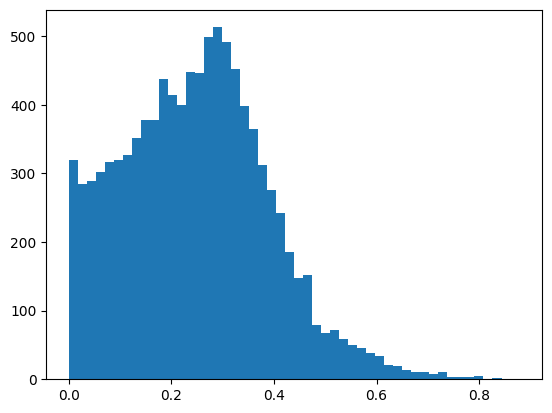

In [35]:
import matplotlib.pyplot as plt
hist_bin_size = []
for i in range(10000):
    hist_bin_size.append(decode_binary_to_weights(generate_random_solution(10, bin_str_size = 3))[0])
plt.hist(hist_bin_size, bins=50)
plt.show()

In [36]:
sharpe_df = stocks_df.reset_index()
sharpe_df = sharpe_df.rename(columns={"index" : "time"})
sharpe_df = sharpe_df.set_index(['ticker', 'time'])
sharpe_df

Open   High    Low  Close  Adj Close     Volume
ticker   time                                                        
AALR3.SA 2022-01-03  14.96  14.96  13.51  13.58      13.58   601000.0
         2022-01-04  13.54  14.14  13.30  13.51      13.51   743300.0
         2022-01-05  13.54  13.58  12.66  12.68      12.68   359600.0
         2022-01-06  12.75  13.00  12.41  12.90      12.90   502900.0
         2022-01-07  12.86  13.56  12.45  12.85      12.85   539900.0
...                    ...    ...    ...    ...        ...        ...
ZAMP3.SA 2022-12-23   4.97   5.62   4.97   5.62       5.62   887100.0
         2022-12-26   5.50   5.86   5.43   5.48       5.48   760000.0
         2022-12-27   5.52   5.58   5.21   5.28       5.28   920700.0
         2022-12-28   5.35   5.41   5.22   5.35       5.35   421100.0
         2022-12-29   5.35   5.59   5.31   5.45       5.45  1286500.0

[119087 rows x 6 columns]

In [56]:
sharpe_df.to_parquet('sharpe_df.parquet')

In [37]:
portfiolio = greedy_portfolio(RLC_length = 150, portfolio_length = 15)
portfiolio = [ticker[0] for ticker in portfiolio]
solution = generate_random_solution(len(portfiolio), bin_str_size = 7)
portfolio_weights = decode_binary_to_weights(solution)

portfolio_dict = {k : v for (k, v) in zip(portfiolio, portfolio_weights)}
s0 = [portfolio_dict, solution]
s0

[{'MNDL3.SA': 0.0703971119133574,
  'DMVF3.SA': 0.04963898916967509,
  'LOGN3.SA': 0.01263537906137184,
  'CSRN3.SA': 0.09657039711191336,
  'MEAL3.SA': 0.11371841155234658,
  'ALUP3.SA': 0.07220216606498195,
  'BRGE5.SA': 0.07220216606498195,
  'DIRR3.SA': 0.11010830324909747,
  'BBAS3.SA': 0.05144404332129964,
  'PSSA3.SA': 0.02075812274368231,
  'CIEL3.SA': 0.042418772563176894,
  'RPAD3.SA': 0.11281588447653429,
  'INTB3.SA': 0.08032490974729242,
  'VLID3.SA': 0.030685920577617327,
  'BRGE6.SA': 0.06407942238267147},
 '100111001101110001110110101111111101010000101000011110100111001001011101011111111101101100101000101000111']

In [38]:
portfolio_df = sharpe_df.loc[portfiolio]
portfolio_df

Open       High        Low  Close  Adj Close  Volume
ticker   time                                                                 
MNDL3.SA 2022-01-03  31.559999  33.990002  31.559999  32.50  32.500000   500.0
         2022-01-04  32.110001  32.500000  32.110001  32.50  32.500000   500.0
         2022-01-05  31.000000  31.000000  31.000000  31.00  31.000000   100.0
         2022-01-06  31.000000  31.000000  31.000000  31.00  31.000000     0.0
         2022-01-07  31.900000  32.000000  31.900000  32.00  32.000000   600.0
...                        ...        ...        ...    ...        ...     ...
BRGE6.SA 2022-12-23  12.010000  12.010000  12.010000  12.01  11.195417     0.0
         2022-12-26  12.010000  12.010000  12.010000  12.01  11.195417     0.0
         2022-12-27  12.010000  12.010000  12.010000  12.01  11.195417     0.0
         2022-12-28  12.010000  12.010000  12.010000  12.01  11.195417     0.0
         2022-12-29  12.010000  12.010000  12.010000  12.01  11.195417     0.0

[3750 rows x 6 columns]

In [39]:
len([time_index[1] for time_index in portfolio_df.index.values])

3750

In [40]:
days = len(set([time_index[1] for time_index in portfolio_df.index.values]))

In [41]:
def portfolio_returns_sharpe(weights, df, pf_returns = True, sharpe = True):

    #weights = portfolio_dict
    #df = portfolio_df
    
    days = len(set([time_index[1] for time_index in portfolio_df.index.values]))

    df['weight'] = df.index.get_level_values('ticker').map(weights)

    # Calculate daily returns
    df['return'] = df.groupby('ticker')['Adj Close'].pct_change()

    # Calculate portfolio return
    df['portfolio_return'] = df['return'] * df['weight']

    # Calculate daily portfolio return
    daily_portfolio_return = df.groupby('time')['portfolio_return'].sum()

    # Calculate cumulative portfolio return
    cumulative_portfolio_return = (1 + daily_portfolio_return).cumprod() - 1
    

    # Calculate daily risk-free rate (e.g., use Treasury yields)
    risk_free_rate = 0.02 / days  # Assuming a 2% annual risk-free rate

    # Calculate portfolio Sharpe ratio
    daily_sharpe_ratio = (daily_portfolio_return.mean() - risk_free_rate) / daily_portfolio_return.std()

    # Calculate annualized Sharpe ratio
    annual_sharpe_ratio = daily_sharpe_ratio * (days ** 0.5)

    #print("Cumulative Portfolio Return:")
    #print(cumulative_portfolio_return)

    #print("\nAnnualized Sharpe Ratio:")
    #print(annual_sharpe_ratio)
    
    if pf_returns == True and sharpe == True:
        return cumulative_portfolio_return, annual_sharpe_ratio
    elif pf_returns == True and sharpe == False:
        return cumulative_portfolio_return
    elif sharpe == True and pf_returns == False:
        return annual_sharpe_ratio
    else:
       return None 

In [42]:
sharpe = portfolio_returns_sharpe(portfolio_dict, portfolio_df, False)
sharpe

1.6703199995634745

In [43]:
def perturbate_solution(s, n = 1):
    for i in range(n):
        pos = np.random.choice(len(s))
        
        binary_list = list(s)
        
        if binary_list[pos] == '0':
            binary_list[pos] = '1'
        else:
            binary_list[pos] = '0'
        
        s = ''.join(binary_list)
    
    return s

In [44]:
pf_test = generate_random_solution(portfolio_length=2, bin_str_size=2)
pt_test = perturbate_solution(pf_test)
print(pf_test)
print(pt_test)

0000
0010


In [45]:
def update_tabu_list(tabu_list, max_length, solution):
    if max_length == len(tabu_list):
        tabu_list.pop()
        tabu_list.insert(0, solution)
    else:
        tabu_list.append(solution)
        
    return tabu_list

def generate_neighborhood(n_neighbors, current_solution, bin_str_size):
    neighborhood = []
    for i in range(n_neighbors):
        new_solution = current_solution
        while((new_solution in neighborhood) or (new_solution == current_solution)):
            new_solution = perturbate_solution(current_solution, 1)
        neighborhood.append([decode_binary_to_weights(new_solution, bin_str_size), new_solution])
    #neighborhood_sol = [decode_binary_to_weights(n) for n in neighborhood]
    return neighborhood

In [46]:
neighborhood = [neighbor[0] for neighbor in generate_neighborhood(5, s0[1], bin_str_size)]
neighborhood

[[0.0572289156626506,
  0.0572289156626506,
  0.04216867469879518,
  0.02108433734939759,
  0.0391566265060241,
  0.045180722891566265,
  0.09036144578313253,
  0.060240963855421686,
  0.015060240963855422,
  0.02710843373493976,
  0.08734939759036145,
  0.02108433734939759,
  0.012048192771084338,
  0.06927710843373494,
  0.03313253012048193,
  0.09337349397590361,
  0.08132530120481928,
  0.03614457831325301,
  0.060240963855421686,
  0.030120481927710843,
  0.02108433734939759],
 [0.0572289156626506,
  0.0572289156626506,
  0.04216867469879518,
  0.02108433734939759,
  0.0391566265060241,
  0.045180722891566265,
  0.09036144578313253,
  0.060240963855421686,
  0.015060240963855422,
  0.0030120481927710845,
  0.08734939759036145,
  0.02108433734939759,
  0.012048192771084338,
  0.06927710843373494,
  0.03313253012048193,
  0.09337349397590361,
  0.08132530120481928,
  0.03614457831325301,
  0.08433734939759036,
  0.030120481927710843,
  0.02108433734939759],
 [0.05828220858895705,
  

In [47]:
#portfolio_returns_sharpe optional return
#solution weight problem


In [48]:
def tabu_search(max_iterations, n_neighbors, early_stop_n, tabu_list_len, s0, df, bin_str_size):

    tabu_list, bin_list, bin_bests, score_list, best_scores, mean_scores = [], [], [], [], [], []

    stocks_names = [stock for stock in s0[0].keys()]
    portfolio_df = df.loc[stocks_names]

    best_score = portfolio_returns_sharpe(s0[0], portfolio_df, False) * (-1)
    best_solution = s0[0]
    iteration, best_iteration = 0, 0
    
    while (iteration <= max_iterations) and (iteration - best_iteration <= early_stop_n):
        #print(f"Iteration : {iteration}")
        #Neighborhood and scores
        #print(s0[1])
        nb = generate_neighborhood(n_neighbors, s0[1], bin_str_size)
        
        neighborhood = [neighbor[1] for neighbor in nb]
        #pprint(neighborhood)
        neighborhood_weights = [neighbor[0] for neighbor in nb]
        #neighbors_scores = [solution_score(bin_phrase, neighbor) for neighbor in neighborhood]
        
        #print(neighborhood_weights)
        
        neighbors_scores = []
        for idx_n in range(len(neighborhood)): 
            temp_dict = {key: value for key, value in zip(stocks_names, neighborhood_weights[idx_n])}
            #pprint(temp_dict)
            score = portfolio_returns_sharpe(temp_dict, portfolio_df, False)
            #pprint(score)
            neighbors_scores.append(- score)
            #print(neighborhood_weights[idx_n])
        #print(neighbors_scores)
        #print(neighbors_scores[:5])
        min_neighbor_score =  min(neighbors_scores)
        best_neighbor = neighborhood[neighbors_scores.index(min_neighbor_score)]
        best_neighbor_w = neighborhood_weights[neighbors_scores.index(min_neighbor_score)]
        
        #print(min_neighbor_score)
        
        if (best_neighbor not in tabu_list) or (min_neighbor_score <= best_score):
            tabu_list = update_tabu_list(tabu_list, tabu_list_len, best_neighbor)
            s0, s0_score = [best_neighbor_w, best_neighbor], min_neighbor_score
            #print('Best sol, and score')
            #print(s0, s0_score)
            bin_list.append(s0)
            score_list.append(s0_score)
            mean_scores.append(np.mean(neighbors_scores))
            if s0_score <= best_score:
                best_score = s0_score
                best_solution = s0
                best_iteration = iteration
                bin_bests.append(best_solution)
                best_scores.append(best_score)
            

        iteration += 1
        
    return best_solution, best_score, bin_list, score_list, bin_bests, best_scores, mean_scores


In [49]:

def greedy_solution(RLC_length = 250, portfolio_length = 15, bin_str_size = 5):
    #Initial greedy solution
    portfiolio = greedy_portfolio(RLC_length, portfolio_length)

    portfiolio = [ticker[0] for ticker in portfiolio]

    solution = generate_random_solution(len(portfiolio), bin_str_size)

    portfolio_weights = decode_binary_to_weights(solution, bin_str_size)

    #greedy solution with random weights
    portfolio_dict = {k : v for (k, v) in zip(portfiolio, portfolio_weights)}
    s0 = [portfolio_dict, solution]
    return s0



In [50]:
RLC_length = 250
portfolio_length = 15 
bin_str_size = 5
s0 = greedy_solution(RLC_length, portfolio_length, bin_str_size)
s0

[{'GPAR3.SA': 0.13274336283185842,
  'PLAS3.SA': 0.05752212389380531,
  'ELET3.SA': 0.08849557522123894,
  'LOGN3.SA': 0.004424778761061947,
  'ENGI11.SA': 0.02654867256637168,
  'BRGE5.SA': 0.04424778761061947,
  'B3SA3.SA': 0.10619469026548672,
  'CSRN6.SA': 0.05752212389380531,
  'CBAV3.SA': 0.12831858407079647,
  'FHER3.SA': 0.061946902654867256,
  'BRGE11.SA': 0.05309734513274336,
  'MSPA3.SA': 0.05309734513274336,
  'CPLE11.SA': 0.048672566371681415,
  'BPAC3.SA': 0.0,
  'GMAT3.SA': 0.13716814159292035},
 '111100110110100000010011001010110000110111101011100110001100010110000011111']

In [51]:
tabu_run = tabu_search(max_iterations = 3000, 
                       n_neighbors = 60, 
                       early_stop_n = 20, 
                       tabu_list_len = 30, 
                       s0 = s0, 
                       df = sharpe_df, 
                       bin_str_size = bin_str_size)

best_solution, best_score, bin_list, score_list, bin_bests, best_scores, mean_scores = tabu_run

In [52]:
result_dict = {k : v for (k, v) in zip([key for key in s0[0].keys()], best_solution[0])}
result_dict, -best_score


({'GPAR3.SA': 0.16568047337278108,
  'PLAS3.SA': 0.0,
  'ELET3.SA': 0.09467455621301775,
  'LOGN3.SA': 0.16568047337278108,
  'ENGI11.SA': 0.0,
  'BRGE5.SA': 0.14201183431952663,
  'B3SA3.SA': 0.011834319526627219,
  'CSRN6.SA': 0.11834319526627218,
  'CBAV3.SA': 0.0,
  'FHER3.SA': 0.01775147928994083,
  'BRGE11.SA': 0.011834319526627219,
  'MSPA3.SA': 0.1834319526627219,
  'CPLE11.SA': 0.08875739644970414,
  'BPAC3.SA': 0.0,
  'GMAT3.SA': 0.0},
 2.320215454709625)

In [57]:
max_iter = 5
iterations = 0
RLC_length = 250
portfolio_length = 15 
bin_str_size = 5

best_results = []

while iterations < max_iter:
    s0 = greedy_solution(RLC_length, portfolio_length, bin_str_size)
    tabu_run = tabu_search(max_iterations = 300, n_neighbors = 30, early_stop_n = 15, tabu_list_len = 15, s0 = s0, df = sharpe_df, bin_str_size = bin_str_size)
    best_solution, best_score, bin_list, score_list, bin_bests, best_scores, mean_scores = tabu_run
    result_dict = {k : v for (k, v) in zip([key for key in s0[0].keys()], best_solution[0])}
    best_results.append([result_dict, -best_score, score_list, mean_scores])
    iterations += 1
    pprint(result_dict)
    print(str(-best_score))

{'AGXY3.SA': 0.0,
 'ARZZ3.SA': 0.007575757575757576,
 'BAHI3.SA': 0.0,
 'BMKS3.SA': 0.18181818181818182,
 'BRIV3.SA': 0.11363636363636363,
 'EALT3.SA': 0.0,
 'ENGI3.SA': 0.06818181818181818,
 'FHER3.SA': 0.03787878787878788,
 'ITUB4.SA': 0.23484848484848486,
 'MDNE3.SA': 0.015151515151515152,
 'NORD3.SA': 0.007575757575757576,
 'OPCT3.SA': 0.0,
 'RRRP3.SA': 0.0,
 'SLCE3.SA': 0.13636363636363635,
 'SOND6.SA': 0.19696969696969696}
1.4308837979429279
{'BRAP3.SA': 0.11515151515151516,
 'CEDO4.SA': 0.0,
 'CEGR3.SA': 0.18787878787878787,
 'CRIV3.SA': 0.01818181818181818,
 'ENAT3.SA': 0.0,
 'ENMT3.SA': 0.07878787878787878,
 'MILS3.SA': 0.14545454545454545,
 'MSPA3.SA': 0.18787878787878787,
 'PEAB4.SA': 0.048484848484848485,
 'PNVL3.SA': 0.0,
 'PORT3.SA': 0.12121212121212122,
 'PTNT4.SA': 0.006060606060606061,
 'SBSP3.SA': 0.04242424242424243,
 'SLCE3.SA': 0.024242424242424242,
 'TUPY3.SA': 0.024242424242424242}
2.579284444655332
{'AURE3.SA': 0.0,
 'BMKS3.SA': 0.1865671641791045,
 'BRAP3.SA': 

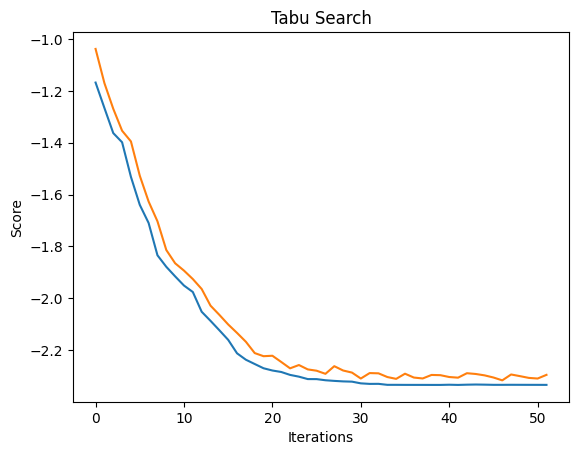

In [58]:
plt.plot(score_list);
plt.plot(mean_scores);
plt.title("Tabu Search");
plt.xlabel("Iterations");
plt.ylabel("Score");

In [143]:
results = pd.read_csv("results.csv")
results.head()

,result_dict,best_solution,best_score,score_list,mean_score,bin_list
0,"{'TAEE11.SA': 0.0, 'SOND3.SA': 0.31, 'MULT3.SA...","[[0.0, 0.31, 0.01, 0.16, 0.0, 0.0, 0.0, 0.03, ...",2.363323,"[-0.8074464834923768, -0.8567692456093888, -0....","[-0.73007710197754, -0.80557486727338, -0.8527...","[[[0.09401709401709402, 0.09401709401709402, 0..."
1,"{'CGAS3.SA': 0.011627906976744186, 'CURY3.SA':...","[[0.011627906976744186, 0.36046511627906974, 0...",1.981197,"[-0.833617512642532, -0.8660765926177819, -0.9...","[-0.6613040802774182, -0.8303460472350648, -0....","[[[0.06086956521739131, 0.11739130434782609, 0..."
2,"{'PETR4.SA': 0.21621621621621623, 'SHUL4.SA': ...","[[0.21621621621621623, 0.07207207207207207, 0....",1.632784,"[-0.8312929976111043, -0.9223252826994999, -0....","[-0.773745383572559, -0.8233367013355457, -0.9...","[[[0.004901960784313725, 0.11764705882352941, ..."
3,"{'BRGE8.SA': 0.0, 'FIGE3.SA': 0.00917431192660...","[[0.0, 0.009174311926605505, 0.0, 0.0550458715...",2.377326,"[-1.5675894753436386, -1.6091061953377173, -1....","[-1.298884659549519, -1.5569173808891341, -1.5...","[[[0.10822510822510822, 0.021645021645021644, ..."
4,"{'WEGE3.SA': 0.0, 'EMAE4.SA': 0.0, 'MILS3.SA':...","[[0.0, 0.0, 0.20253164556962025, 0.0, 0.101265...",2.634732,"[-1.0693719256075267, -1.3230683000052235, -1....","[-0.968882432107406, -1.0786398419143917, -1.3...","[[[0.1076923076923077, 0.0, 0.0410256410256410..."


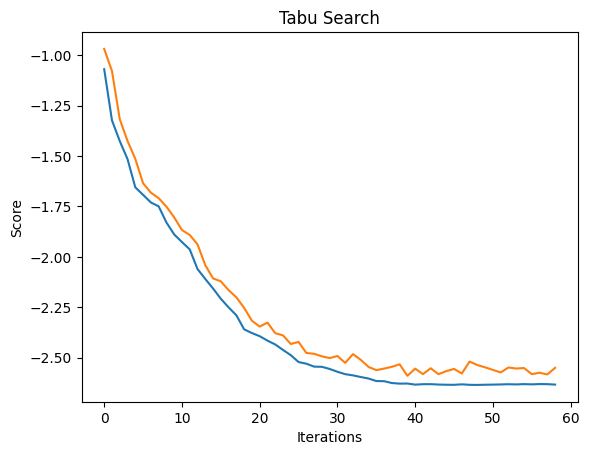

In [144]:
import ast

score_list  = results.sort_values(by='best_score', ascending=False).iloc[0]['score_list']
score_list = ast.literal_eval(score_list)
mean_scores  = results.sort_values(by='best_score', ascending=False).iloc[0]['mean_score']
mean_scores = ast.literal_eval(mean_scores)
plt.plot(score_list);
plt.plot(mean_scores);
plt.title("Tabu Search");
plt.xlabel("Iterations");
plt.ylabel("Score");

In [145]:
result_dict = results.sort_values(by='best_score', ascending=False).iloc[0]['result_dict']
result_dict =  ast.literal_eval(result_dict)
result_dict

{'WEGE3.SA': 0.0,
 'EMAE4.SA': 0.0,
 'MILS3.SA': 0.20253164556962025,
 'DMVF3.SA': 0.0,
 'BBAS3.SA': 0.10126582278481013,
 'MGEL4.SA': 0.0,
 'UGPA3.SA': 0.0,
 'MULT3.SA': 0.0,
 'PEAB3.SA': 0.0,
 'INEP3.SA': 0.0,
 'TGMA3.SA': 0.0,
 'CIEL3.SA': 0.3924050632911392,
 'MNPR3.SA': 0.0,
 'CSRN3.SA': 0.3037974683544304,
 'CCRO3.SA': 0.0}

In [146]:
returns = portfolio_returns_sharpe(result_dict, sharpe_df, True, False)

In [147]:


import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=returns.index, y=returns.values, mode='lines', name='Portfolio Returns'))

# Customize the layout
fig.update_layout(
    title='Portfolio Returns Over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Returns'),
    template='plotly_dark'  # You can choose a different template based on your preference
)

# Show the plot
fig.show()


In [151]:
import plotly.graph_objects as go
import ast

# Create the figure outside the loop
fig = go.Figure()

for i in range(5):
    result_dict = results.sort_values(by='best_score', ascending=False).iloc[i]['result_dict']
    result_dict = ast.literal_eval(result_dict)

    returns = portfolio_returns_sharpe(result_dict, sharpe_df, True, False)

    k_list = [k[:-3] for k in result_dict.keys()]
    stock_string = ""
    for stock in k_list:
        stock_string += stock + '| '
    
    print(f"Portfolio Returns {i} {stock_string} ")

    # Add a trace for each iteration
    fig.add_trace(go.Scatter(x=returns.index, y=returns.values, mode='lines', name=f'Portfolio Returns {i}'))

# Customize the layout
fig.update_layout(
    title='Portfolio Returns Over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Returns'),
    template='plotly_dark'
)

# Show the plot
fig.show()


Portfolio Returns 0 WEGE3| EMAE4| MILS3| DMVF3| BBAS3| MGEL4| UGPA3| MULT3| PEAB3| INEP3| TGMA3| CIEL3| MNPR3| CSRN3| CCRO3|  
Portfolio Returns 1 CSUD3| PSVM11| BDLL3| BRIV4| INTB3| PLAS3| CIEL3| REDE3| RNEW3| EQPA5| WIZC3| SAPR11| VSTE3| NUTR3| VVEO3|  
Portfolio Returns 2 ROMI3| ENAT3| BPAC5| ITUB4| ZAMP3| CRIV3| ELMD3| MOAR3| ENMT4| MTSA4| BEES4| CPFE3| CGAS3| FESA4| CEEB3|  
Portfolio Returns 3 CSRN5| GOAU3| PETR3| ELMD3| BRAP3| SANB11| B3SA3| CEGR3| TIMS3| STBP3| JHSF3| SAPR4| CRFB3| MOAR3| BAUH4|  
Portfolio Returns 4 BRGE8| FIGE3| EALT4| WEGE3| PETR4| BPAC5| PSVM11| BRGE6| POMO4| BRSR5| ENGI3| UNIP6| PEAB4| LAND3| BEES3|  


In [168]:
result_dict = results.sort_values(by='best_score', ascending=False).iloc[0]['result_dict']
result_dict = ast.literal_eval(result_dict)

returns = portfolio_returns_sharpe(result_dict, sharpe_df, True, False)

k_list = [k[:-3] for k in result_dict.keys()]
k_list

['WEGE3',
 'EMAE4',
 'MILS3',
 'DMVF3',
 'BBAS3',
 'MGEL4',
 'UGPA3',
 'MULT3',
 'PEAB3',
 'INEP3',
 'TGMA3',
 'CIEL3',
 'MNPR3',
 'CSRN3',
 'CCRO3']

In [172]:
result_dict

{'WEGE3.SA': 0.0,
 'EMAE4.SA': 0.0,
 'MILS3.SA': 0.20253164556962025,
 'DMVF3.SA': 0.0,
 'BBAS3.SA': 0.10126582278481013,
 'MGEL4.SA': 0.0,
 'UGPA3.SA': 0.0,
 'MULT3.SA': 0.0,
 'PEAB3.SA': 0.0,
 'INEP3.SA': 0.0,
 'TGMA3.SA': 0.0,
 'CIEL3.SA': 0.3924050632911392,
 'MNPR3.SA': 0.0,
 'CSRN3.SA': 0.3037974683544304,
 'CCRO3.SA': 0.0}

In [171]:
portfolio_returns_sharpe(result_dict, sharpe_df, True, False)

time
2022-01-03    0.000000
2022-01-04   -0.032178
2022-01-05   -0.054300
2022-01-06   -0.060372
2022-01-07   -0.060222
                ...   
2022-12-26    1.100608
2022-12-27    1.066850
2022-12-28    1.118620
2022-12-29    1.117126
2022-12-30    1.117126
Name: portfolio_return, Length: 253, dtype: float64

In [174]:
result_dict

{'WEGE3': 0.012345679012345678,
 'EMAE4': 0.0,
 'MILS3': 0.19753086419753085,
 'DMVF3': 0.0,
 'BBAS3': 0.09876543209876543,
 'MGEL4': 0.0,
 'UGPA3': 0.0,
 'MULT3': 0.0,
 'PEAB3': 0.0,
 'INEP3': 0.0,
 'TGMA3': 0.0,
 'CIEL3': 0.38271604938271603,
 'MNPR3': 0.0,
 'CSRN3': 0.30864197530864196,
 'CCRO3': 0.0}

['WEGE3.SA',
 'EMAE4.SA',
 'MILS3.SA',
 'DMVF3.SA',
 'BBAS3.SA',
 'MGEL4.SA',
 'UGPA3.SA',
 'MULT3.SA',
 'PEAB3.SA',
 'INEP3.SA',
 'TGMA3.SA',
 'CIEL3.SA',
 'MNPR3.SA',
 'CSRN3.SA',
 'CCRO3.SA']

In [184]:
tmp_dict = results.sort_values(by='best_score', ascending=False).iloc[0]['result_dict']
tmp_dict =  ast.literal_eval(tmp_dict)
k_list = [k for k in tmp_dict.keys()]

bin_list = results.sort_values(by='best_score', ascending=False).iloc[0]['bin_list']
bin_list =  ast.literal_eval(bin_list)

returns_list = []
for i in bin_list:
    result_dict = {k : v for (k, v) in zip([key for key in k_list], i[0])}
   
    returns = portfolio_returns_sharpe(result_dict, sharpe_df, True, False)
    returns_list.append(returns)



C:\Users\Felps\AppData\Local\Temp\ipykernel_1700\3875627296.py:18: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

C:\Users\Felps\AppData\Local\Temp\ipykernel_1700\3875627296.py:36: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



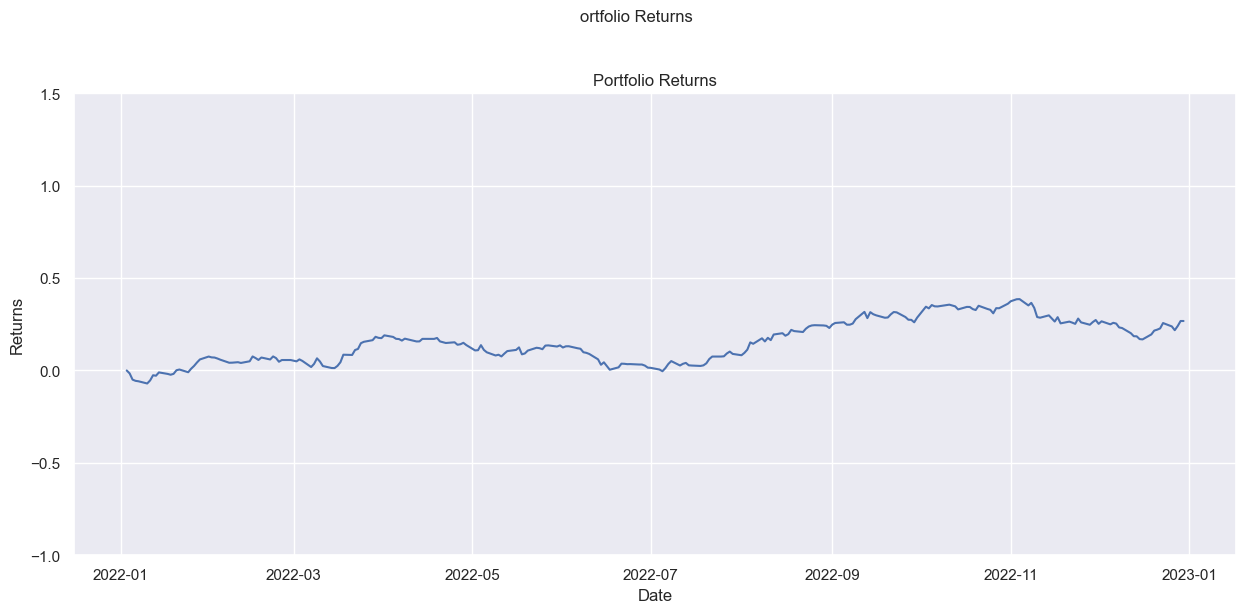

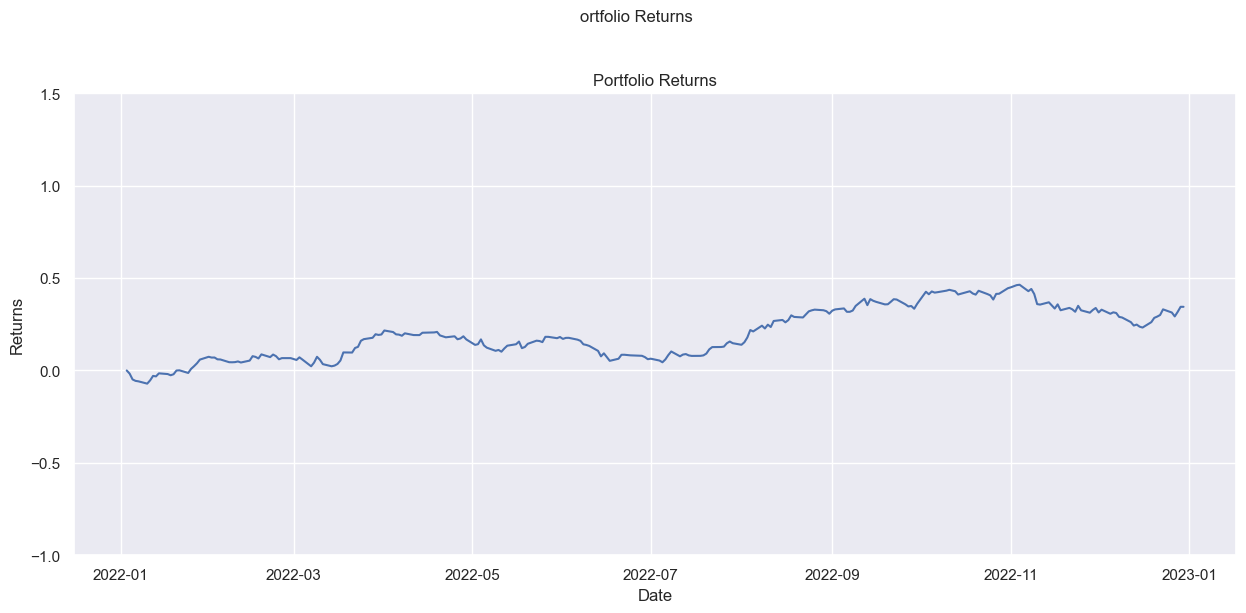

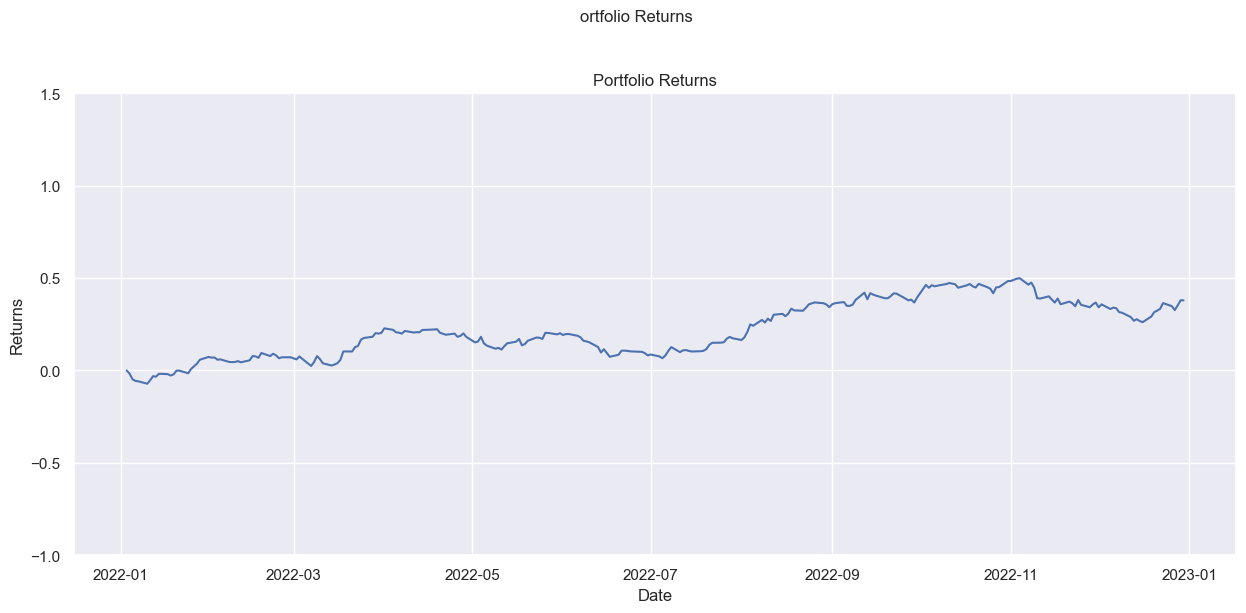

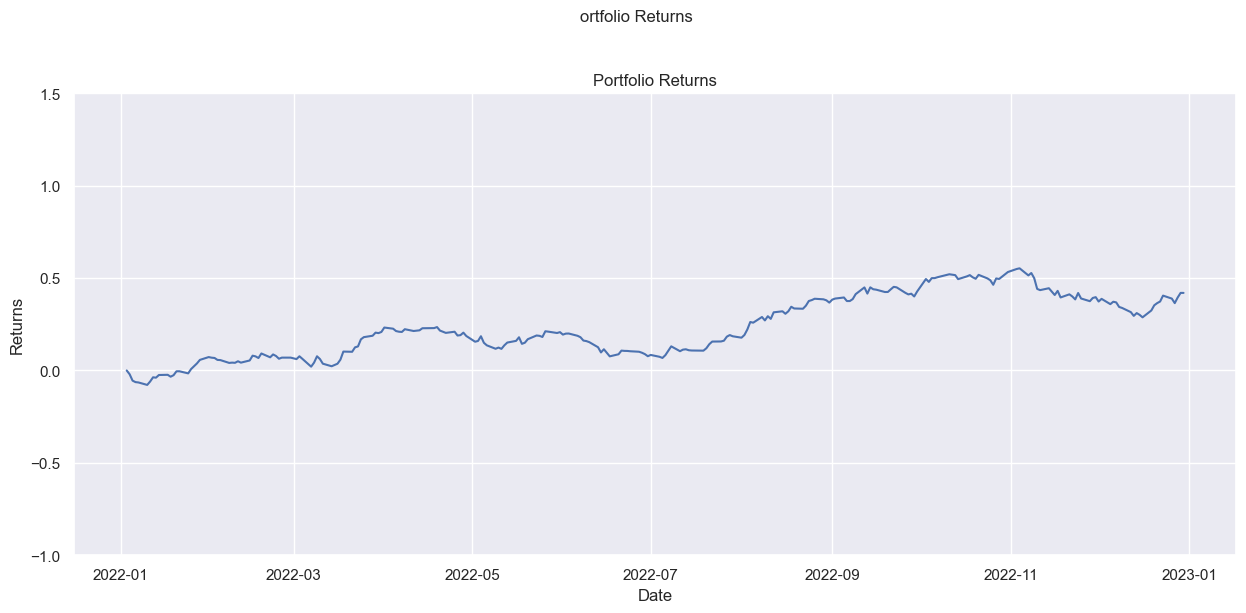

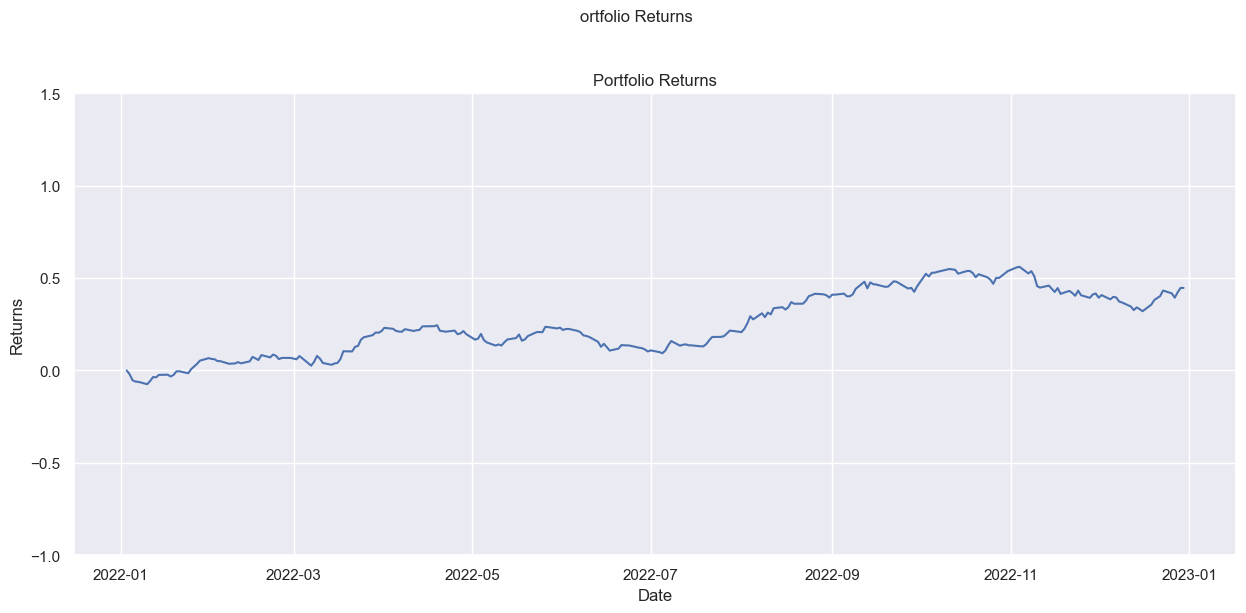

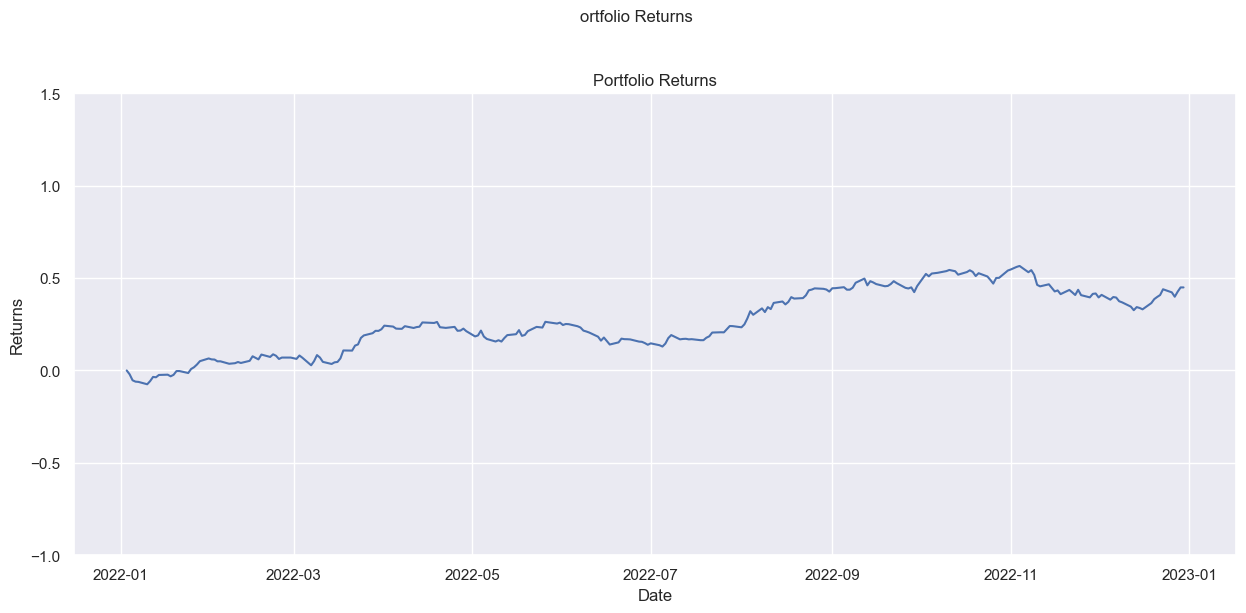

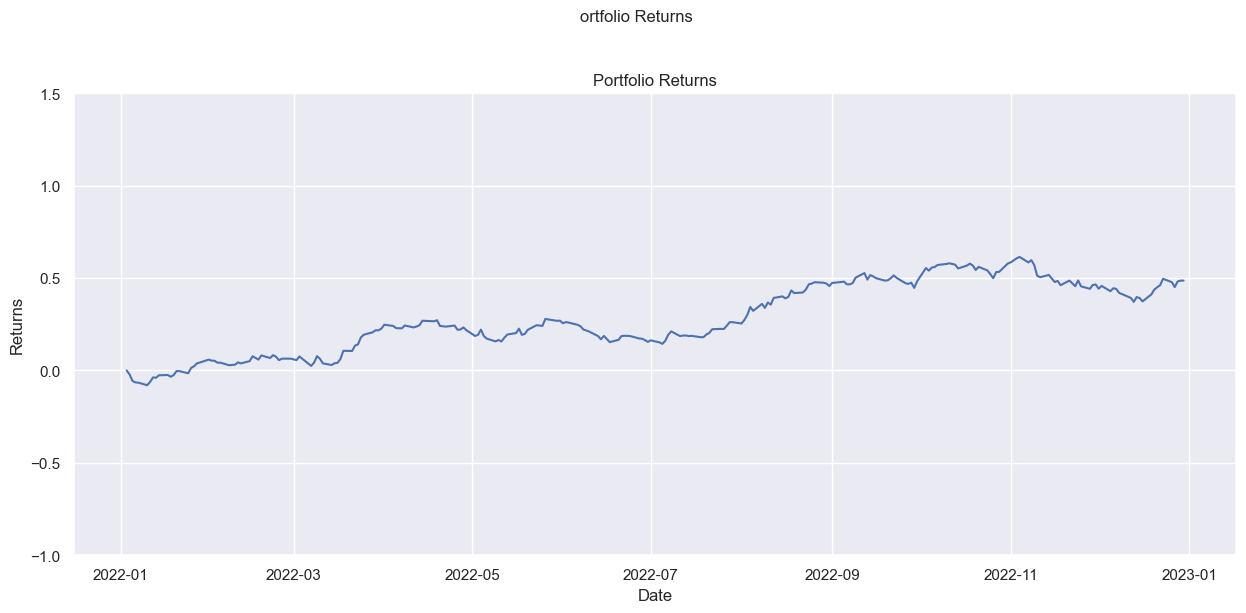

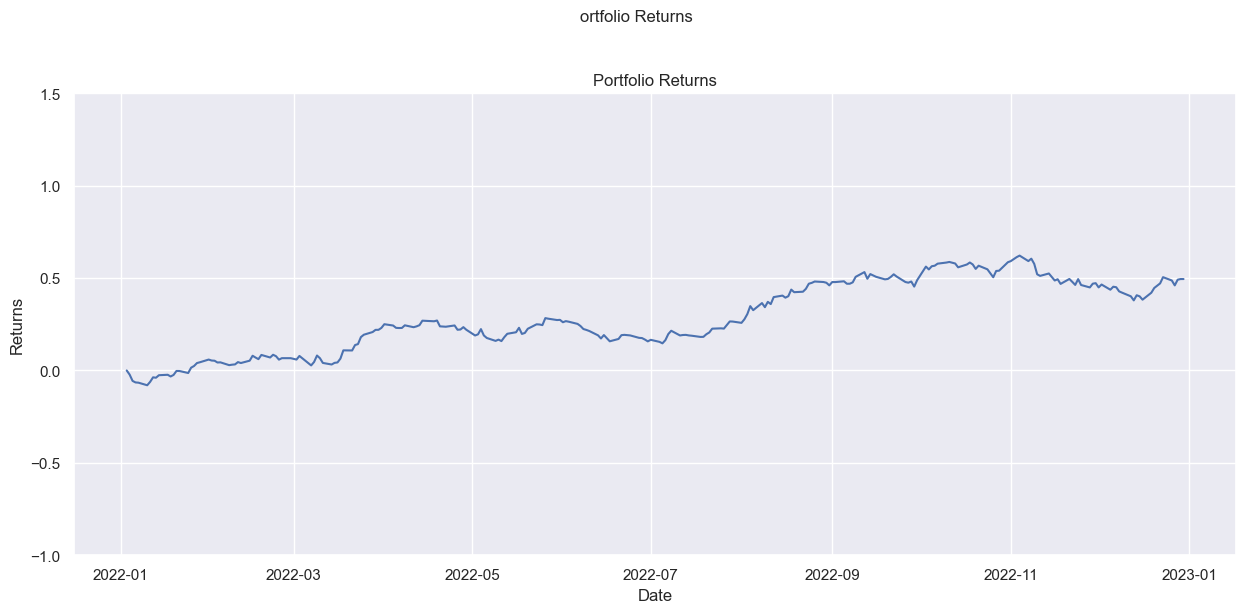

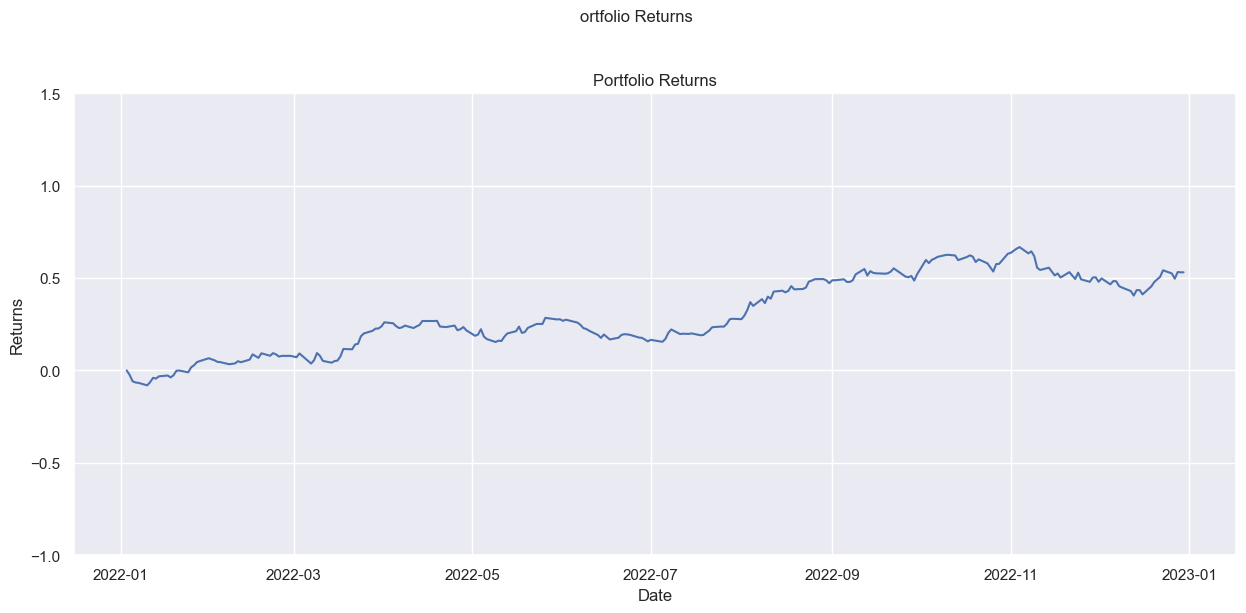

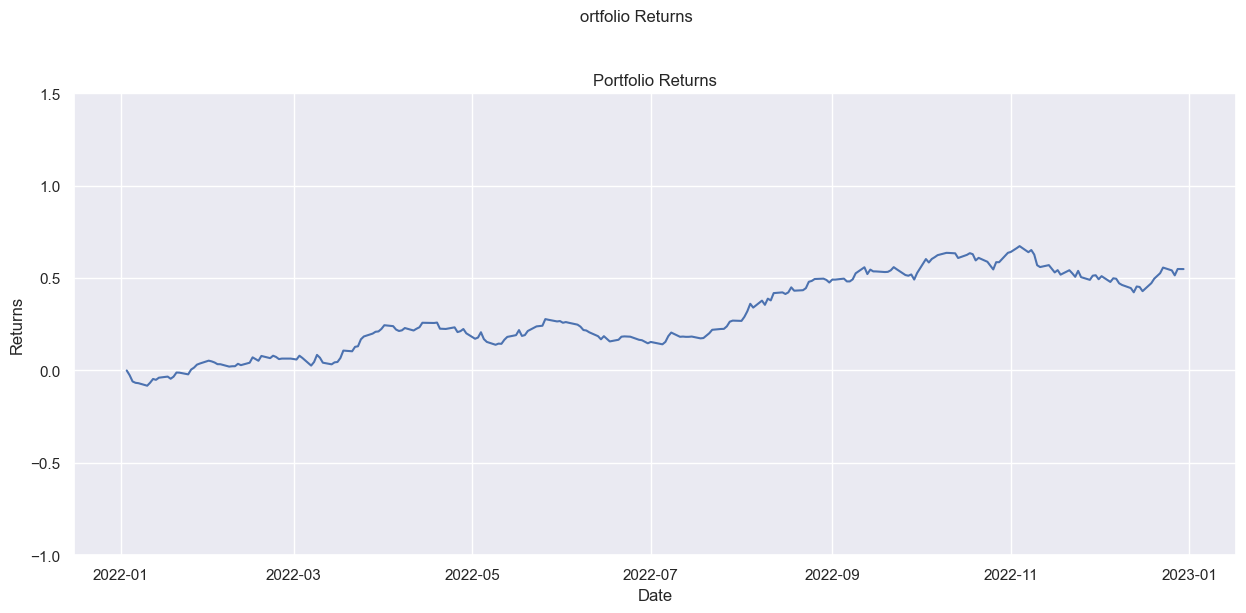

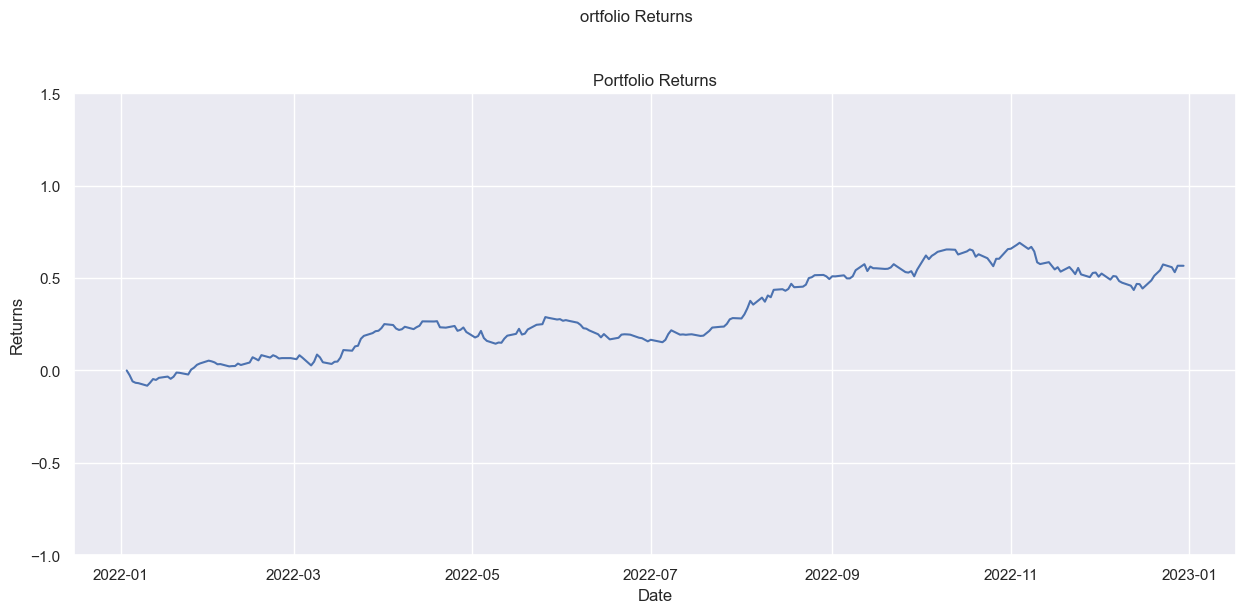

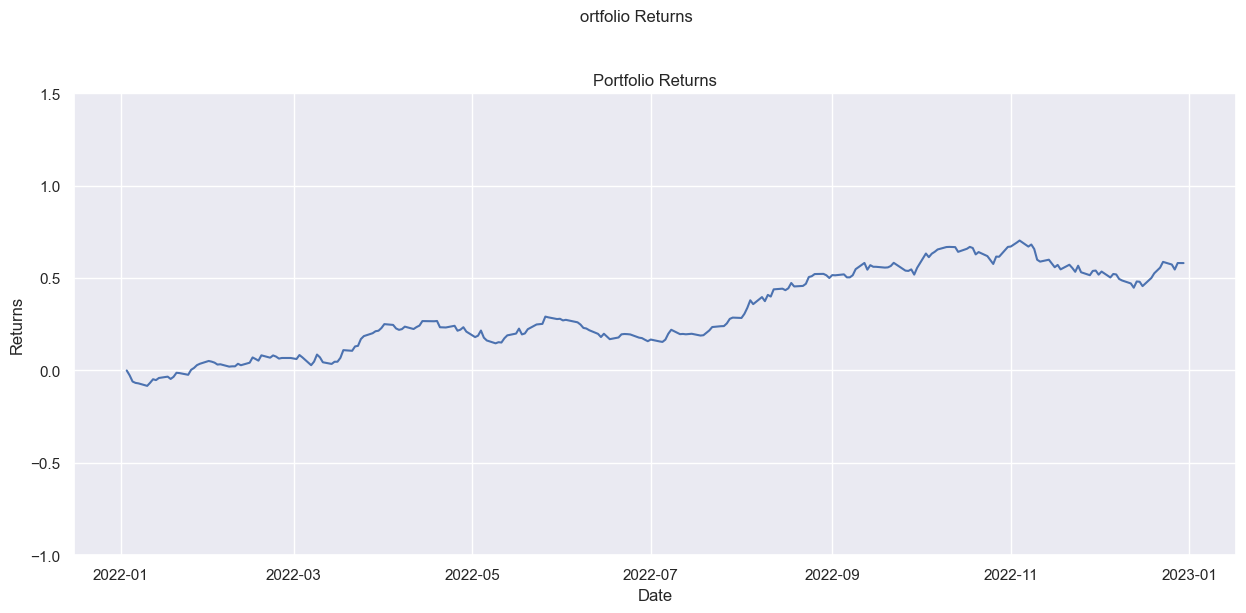

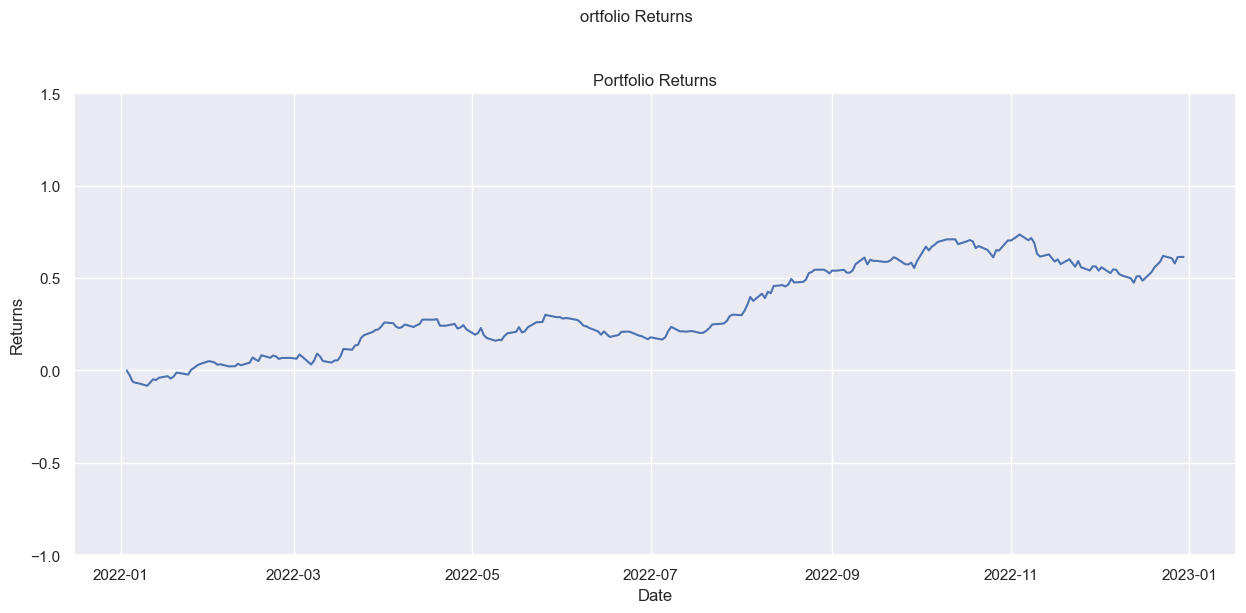

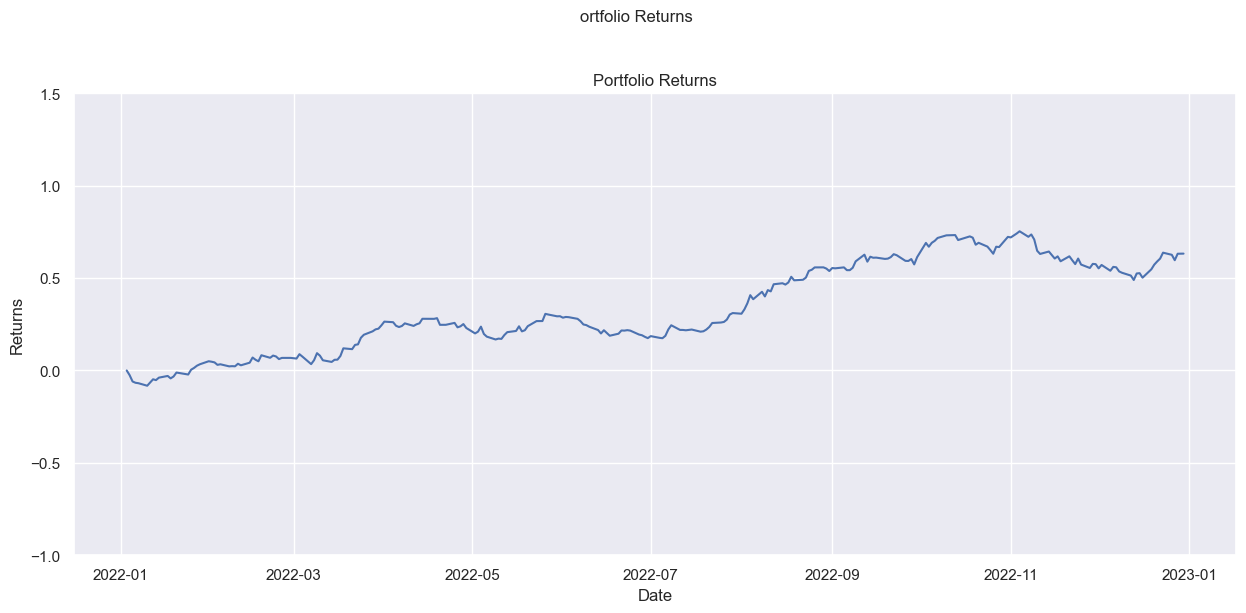

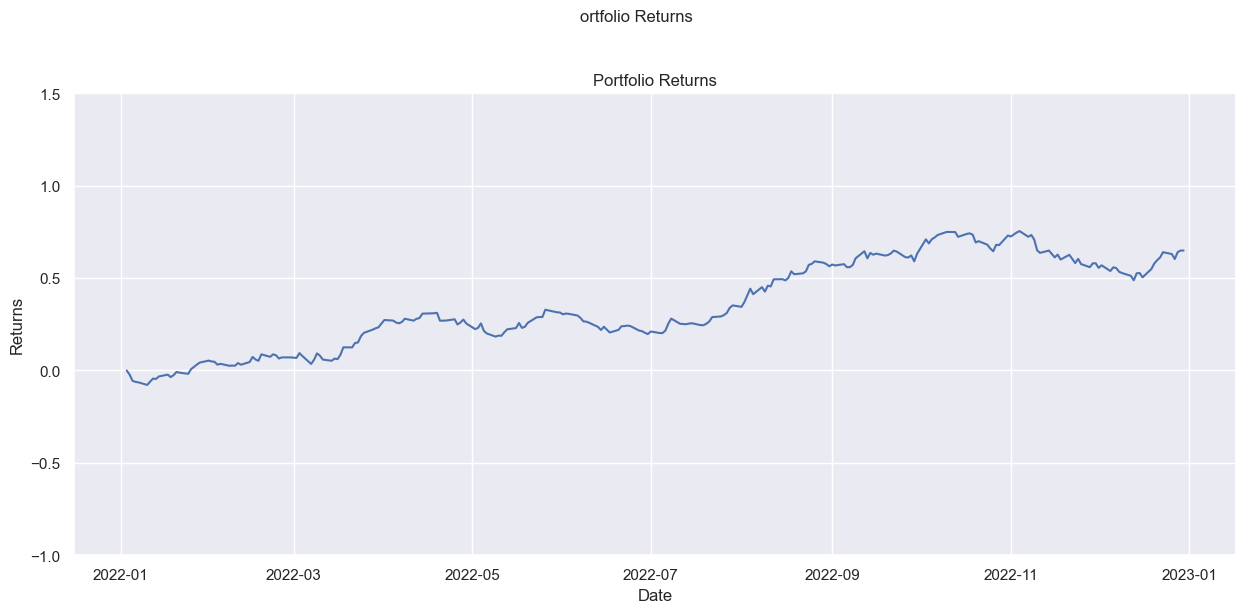

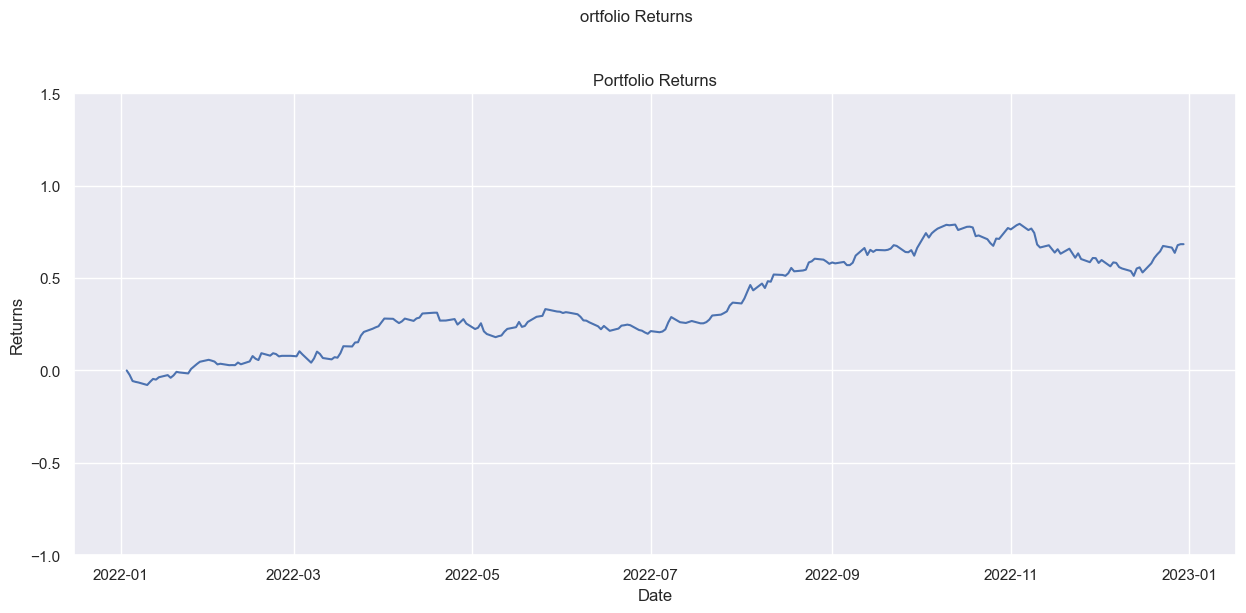

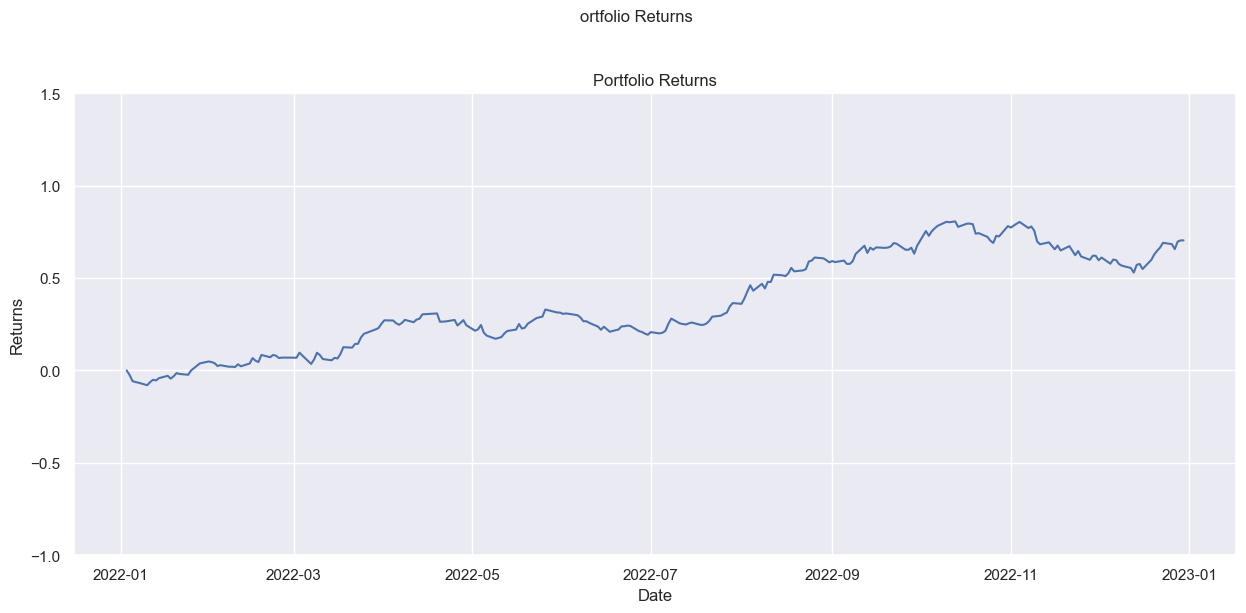

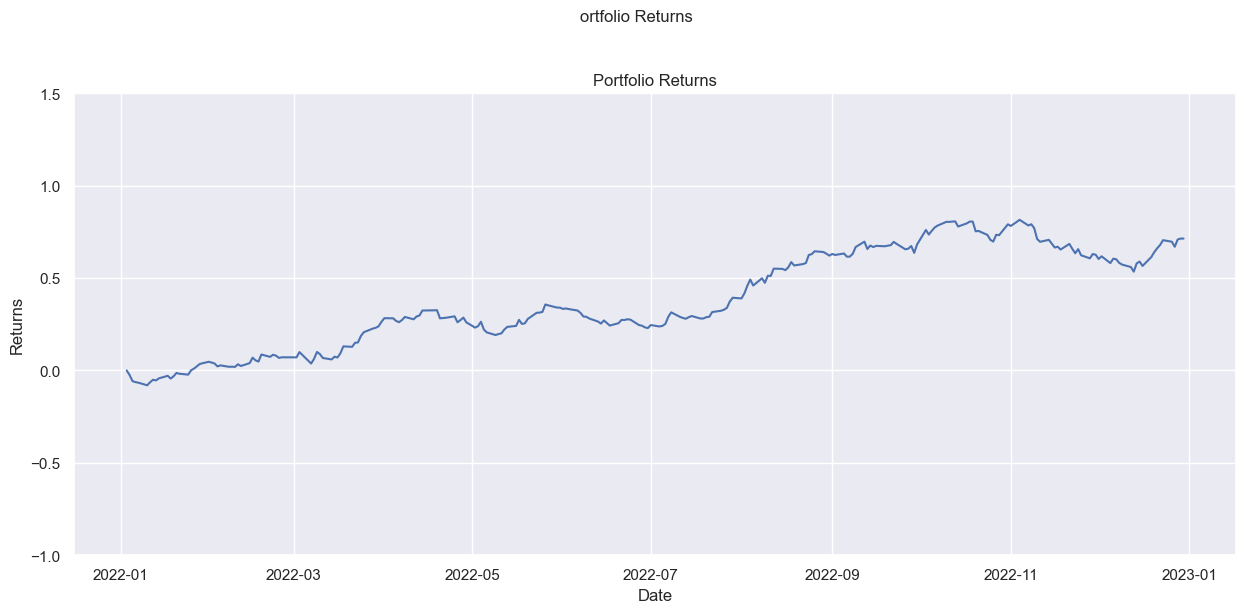

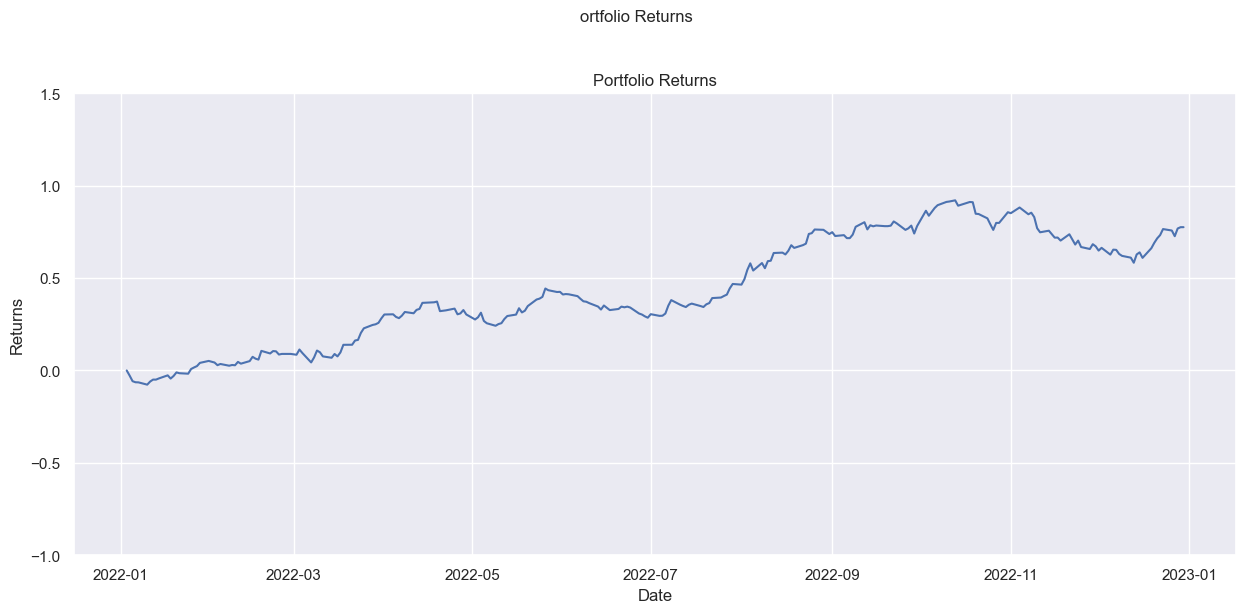

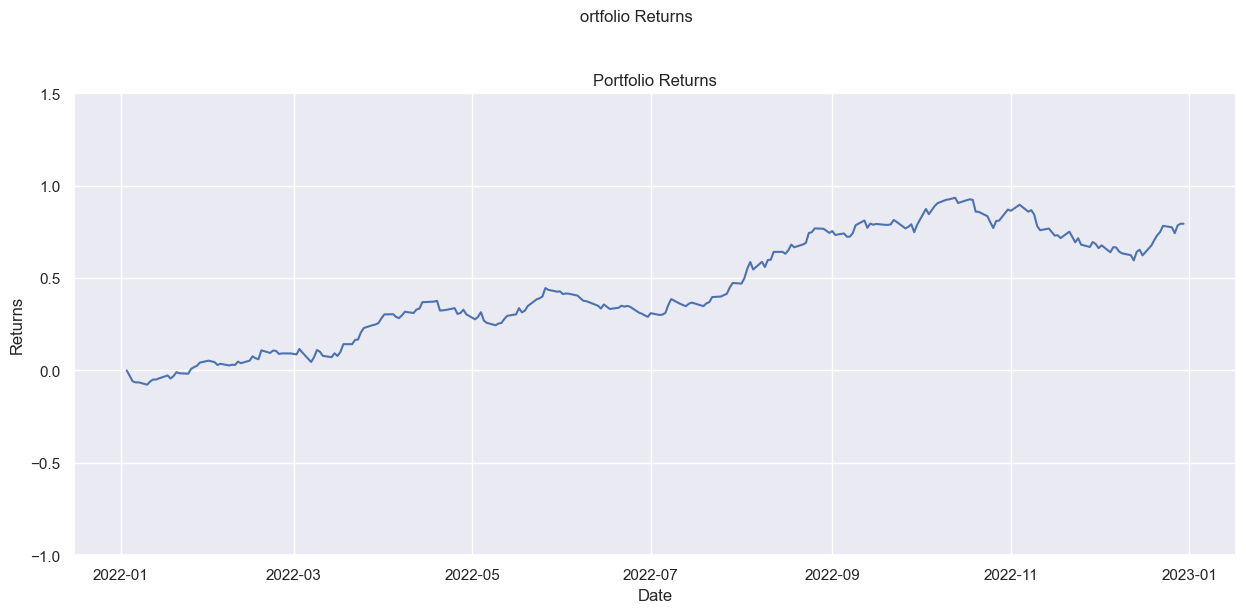

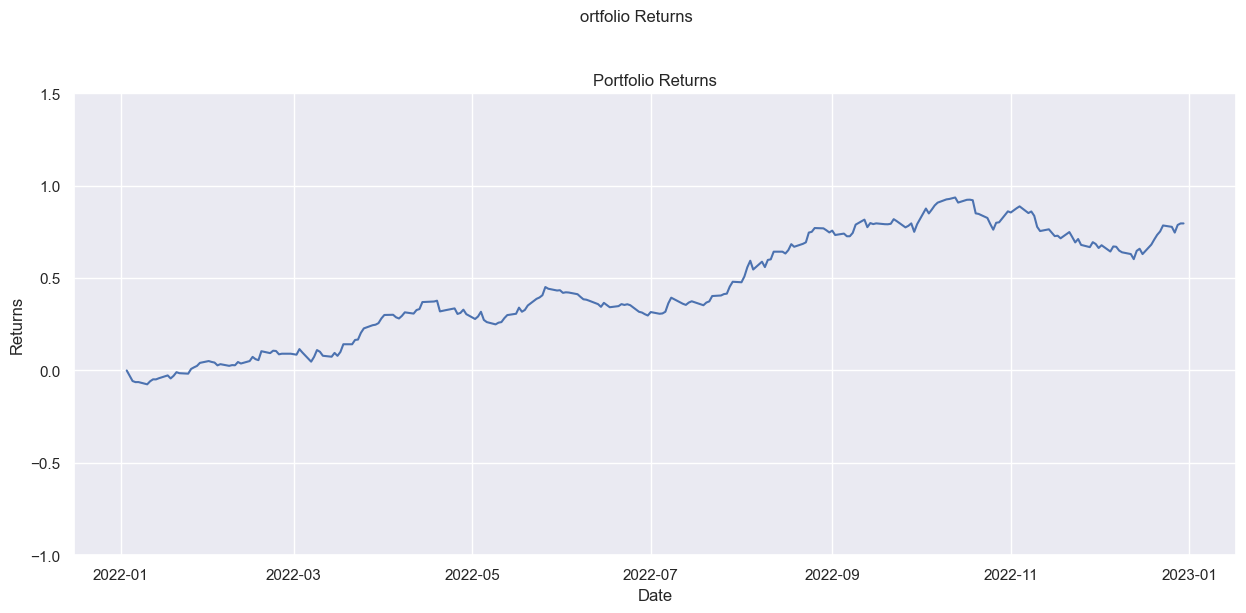

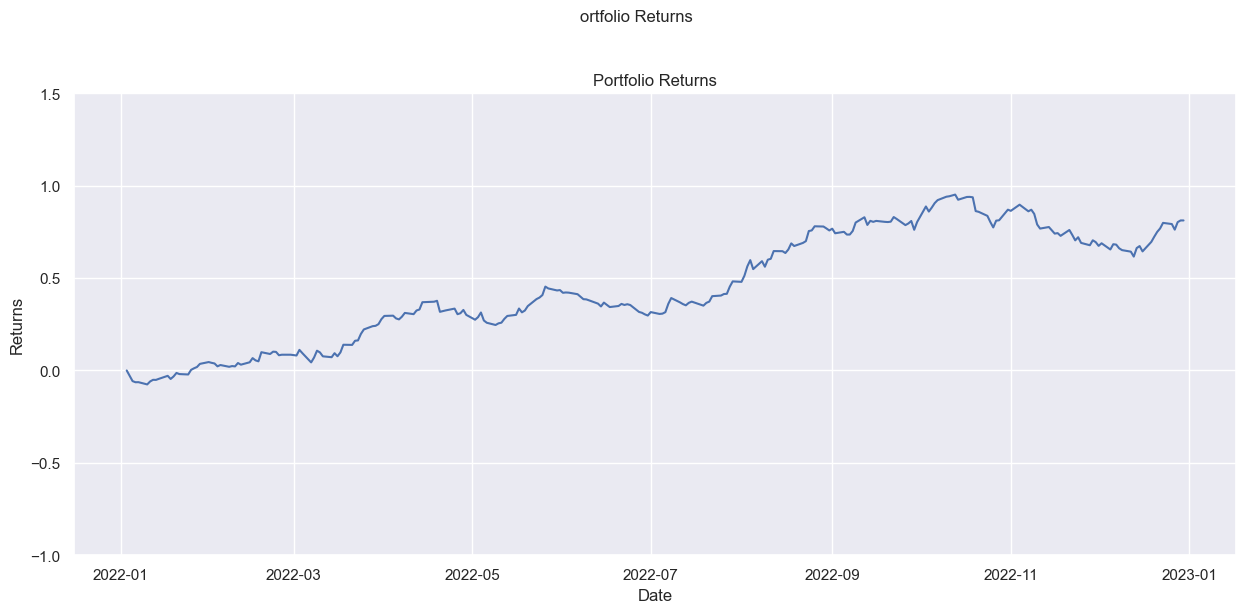

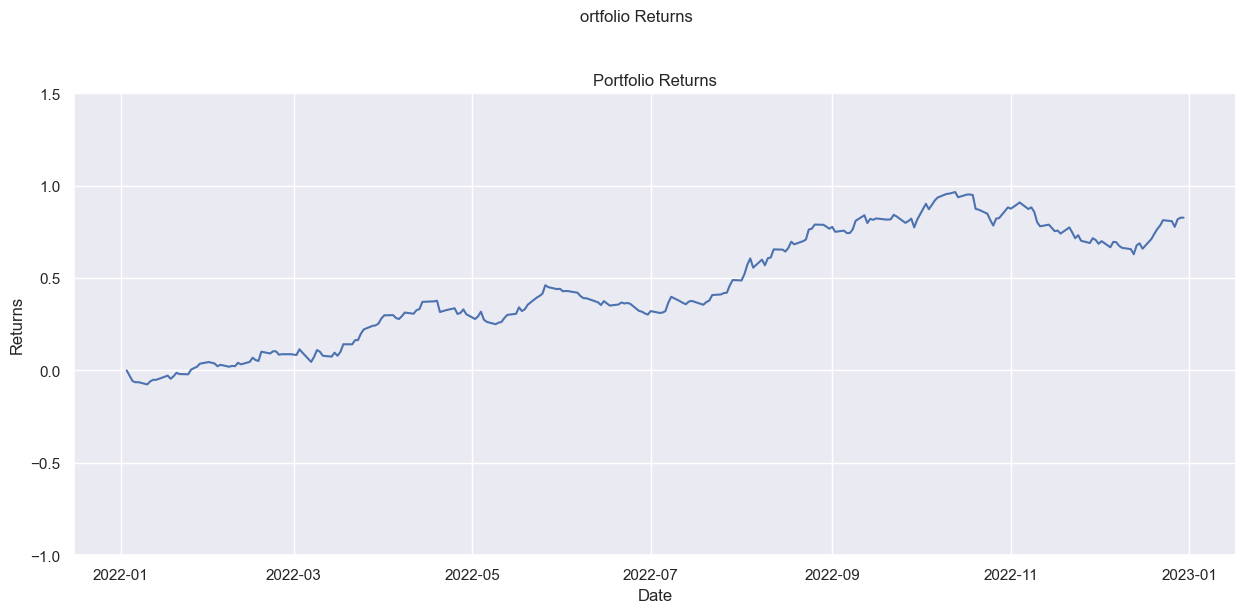

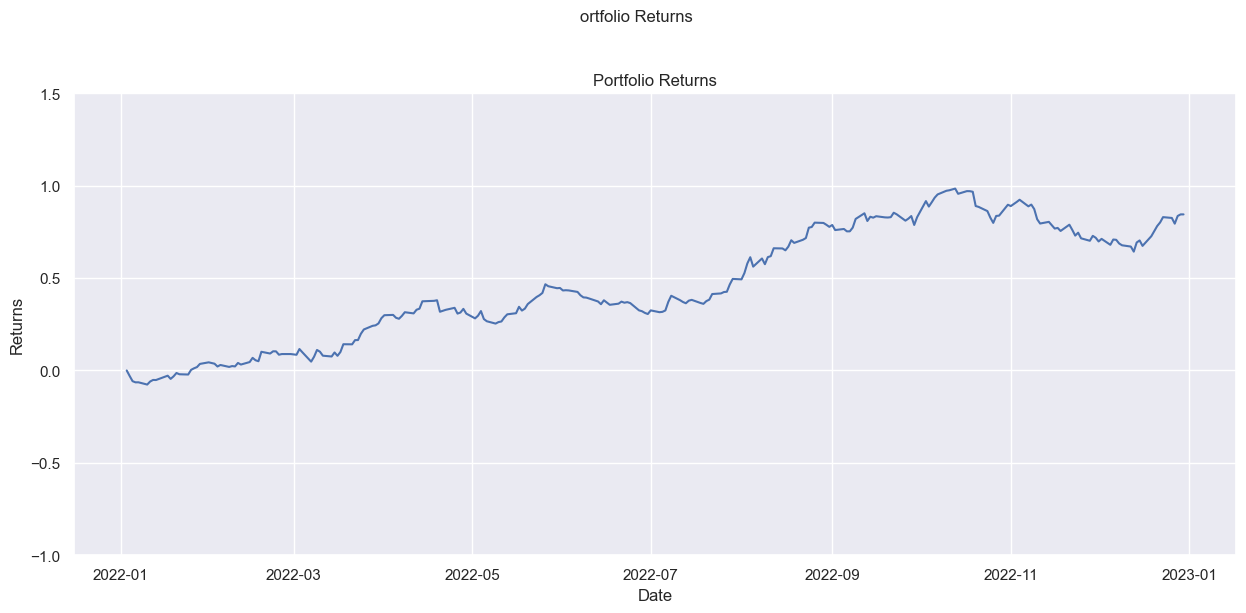

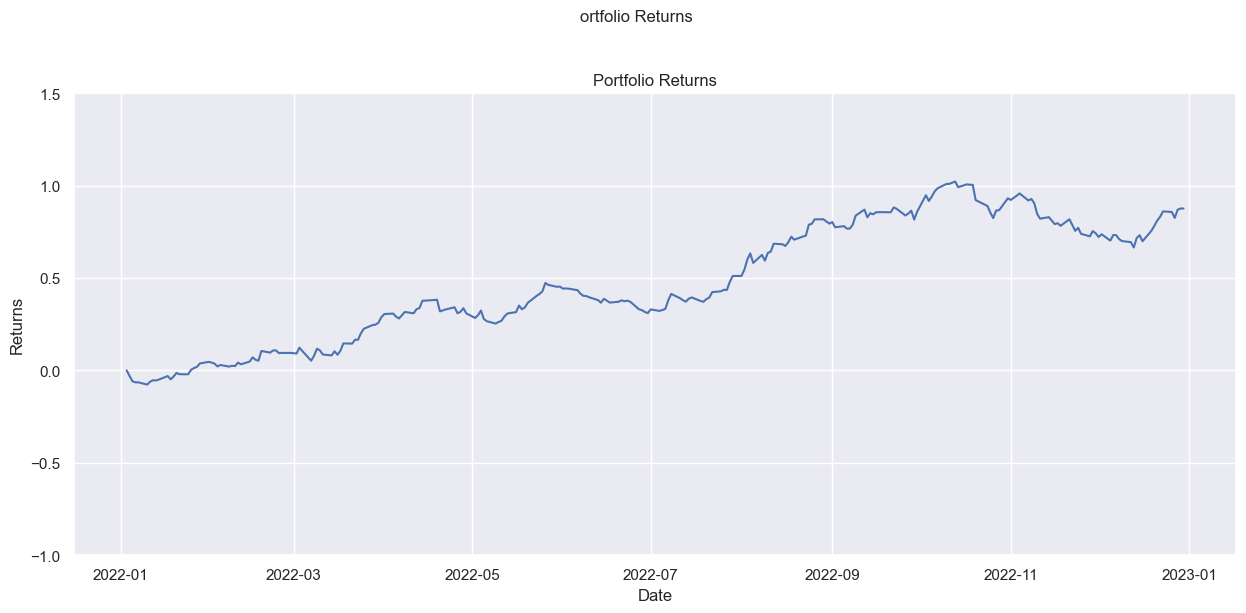

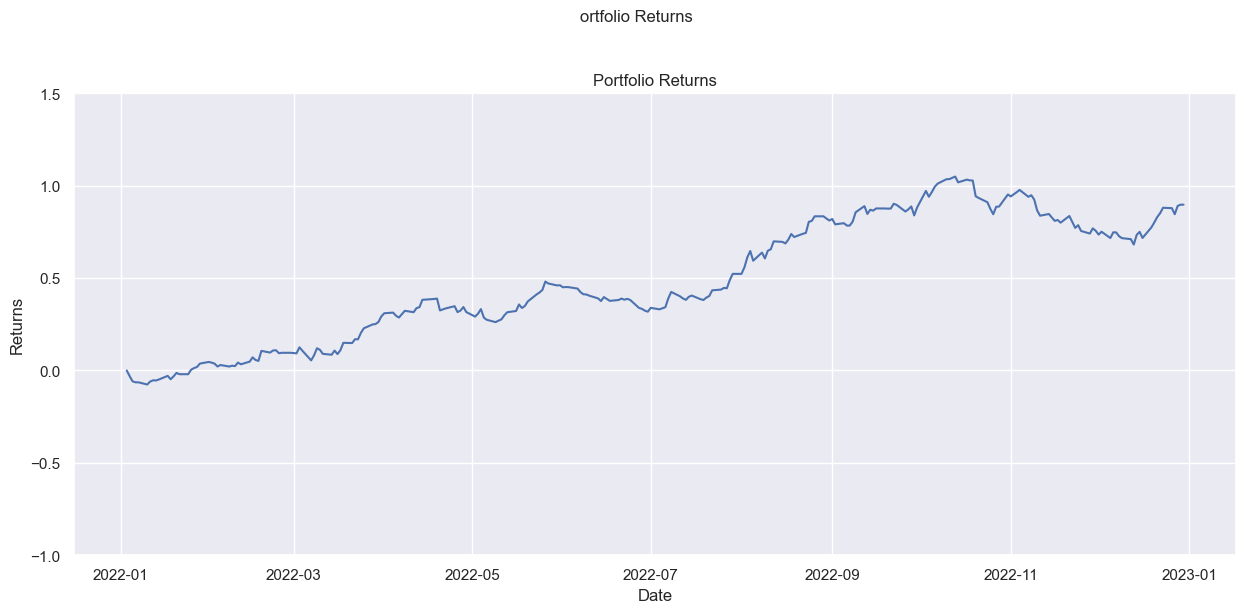

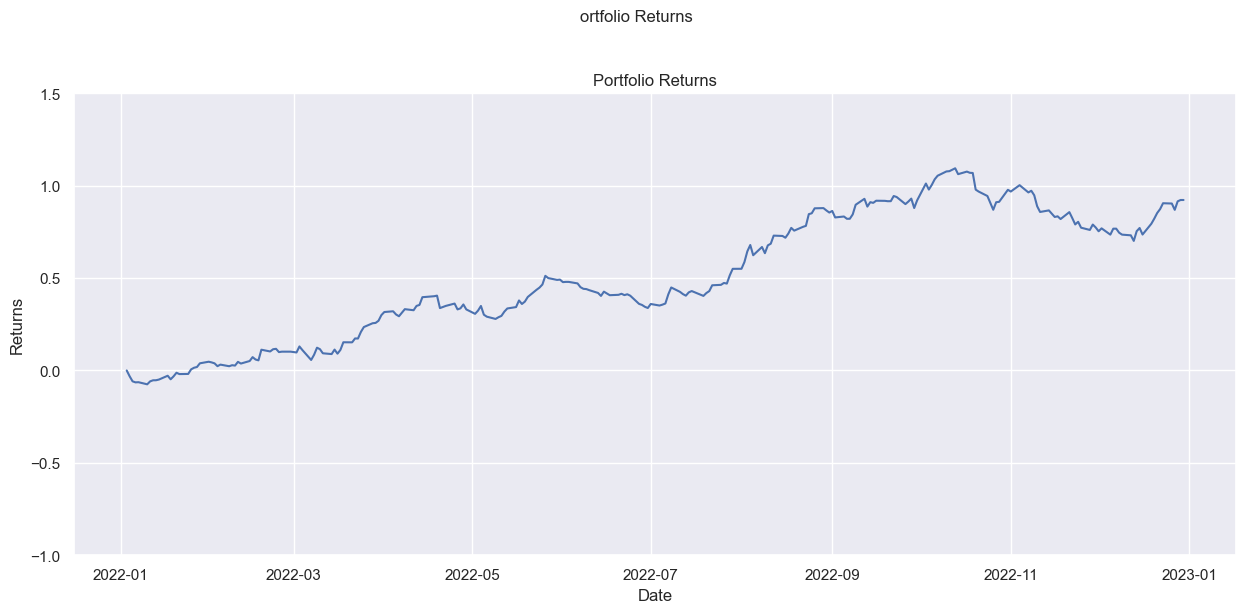

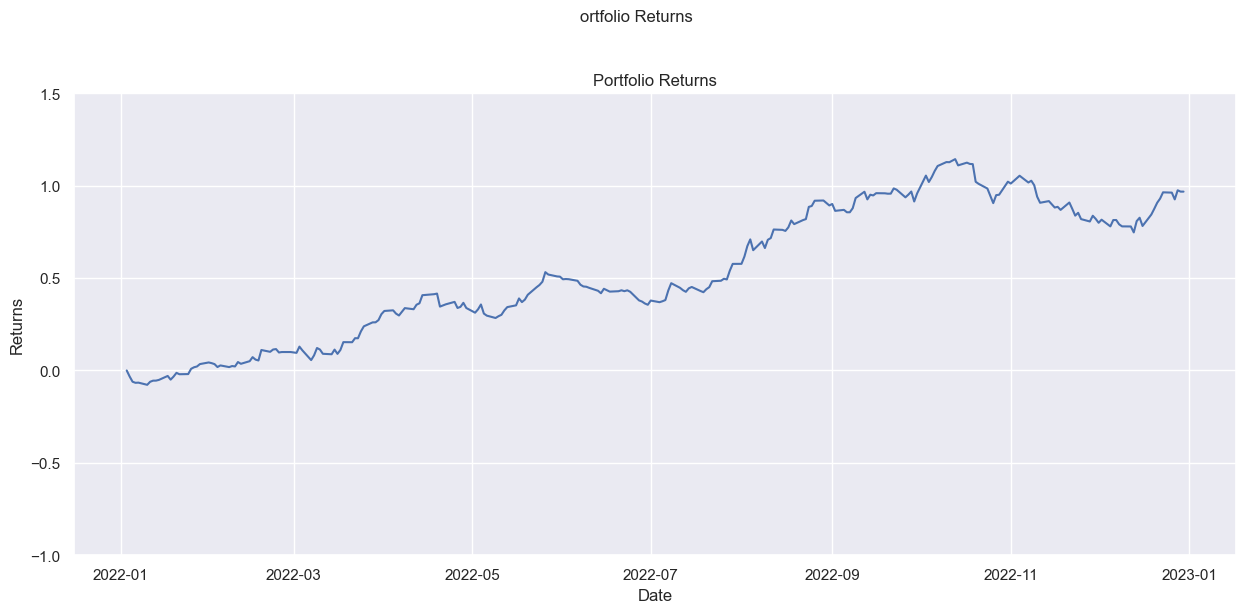

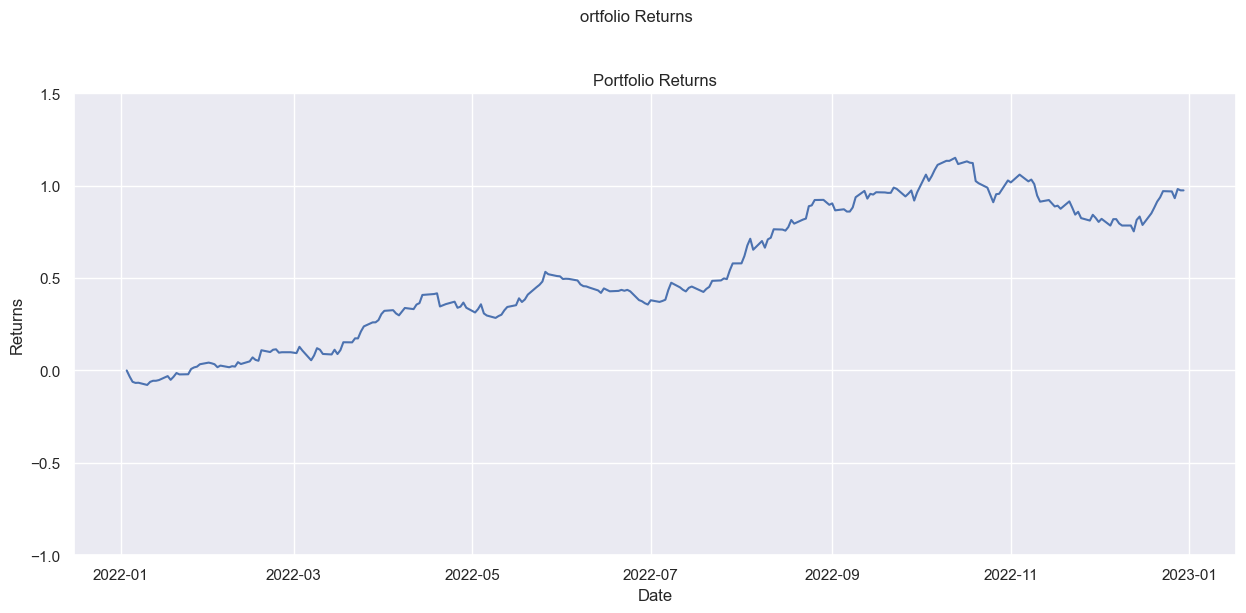

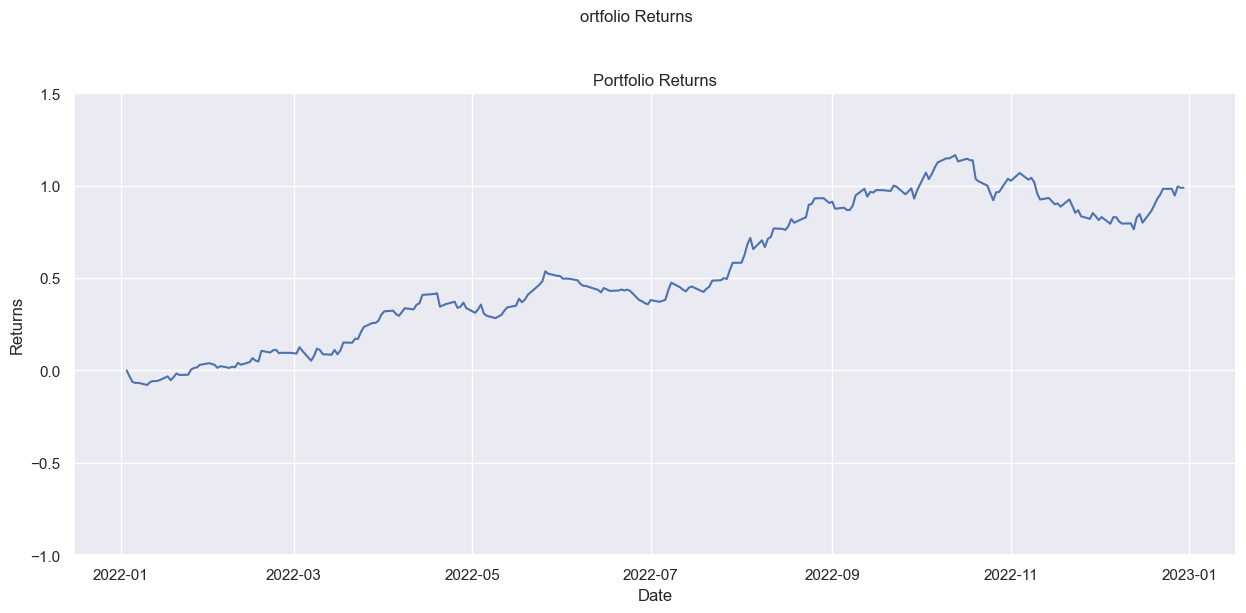

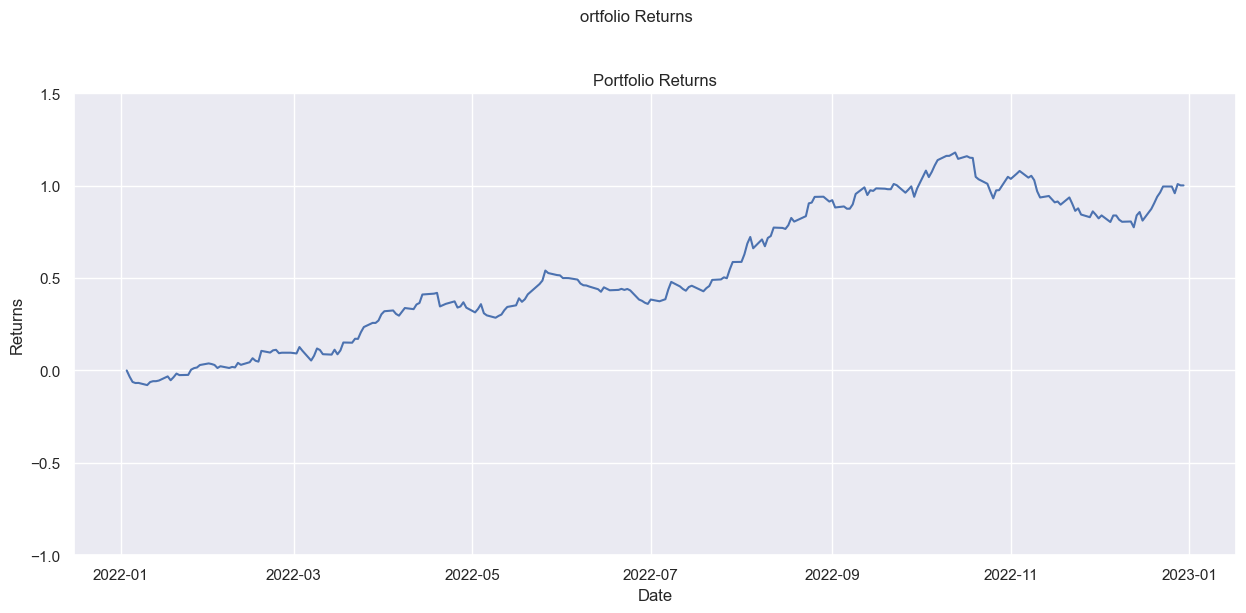

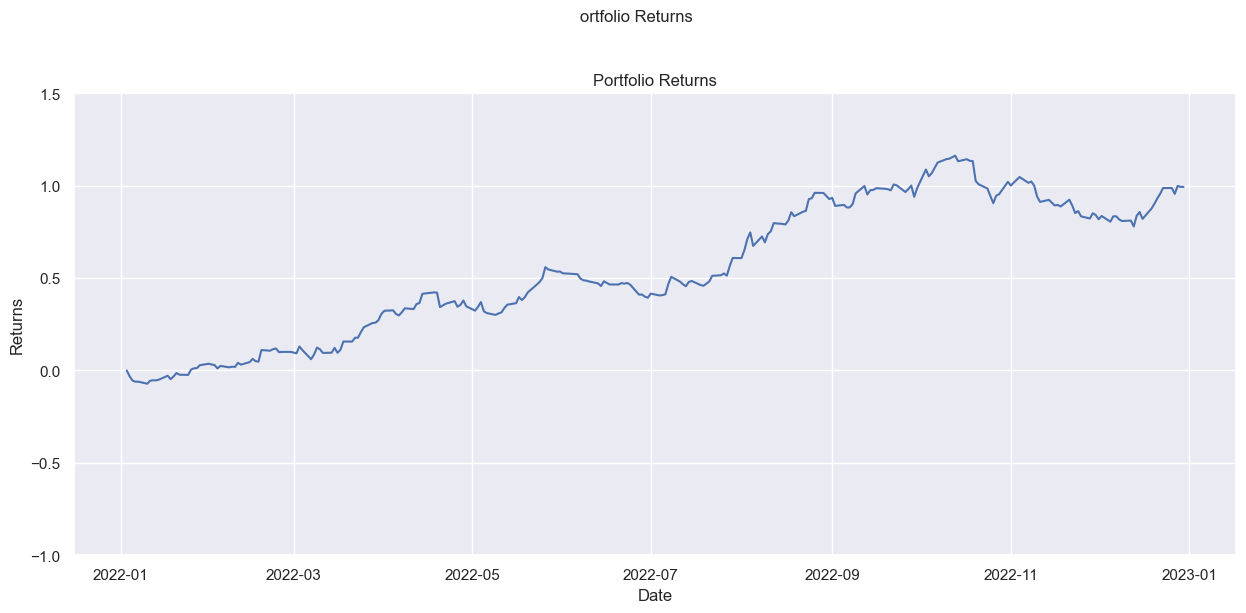

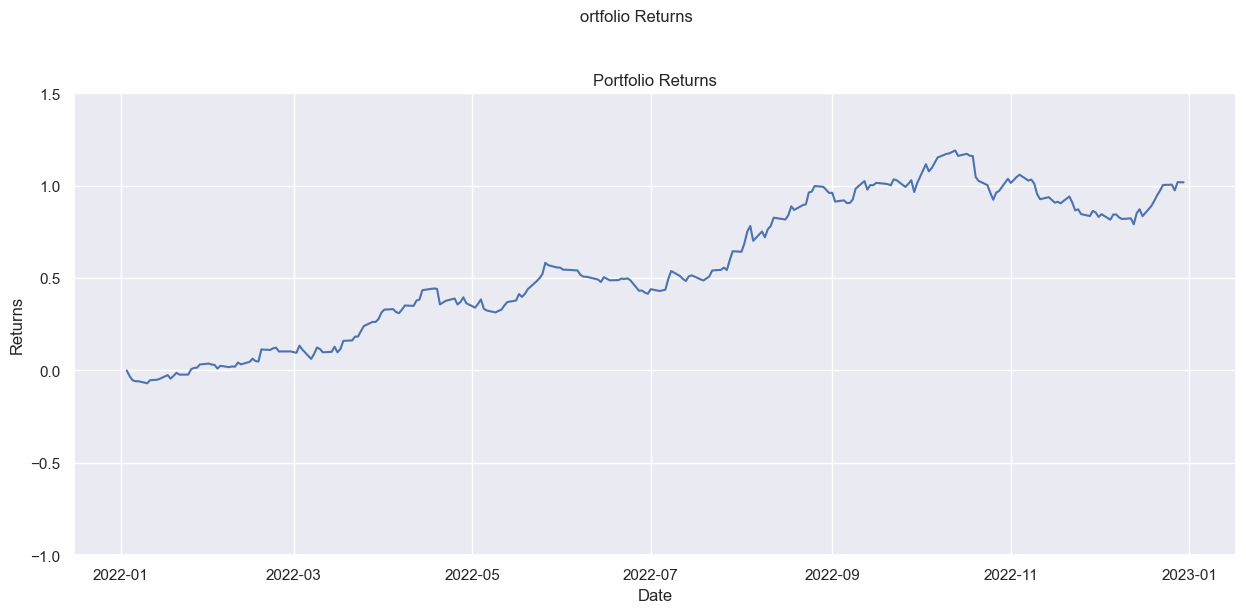

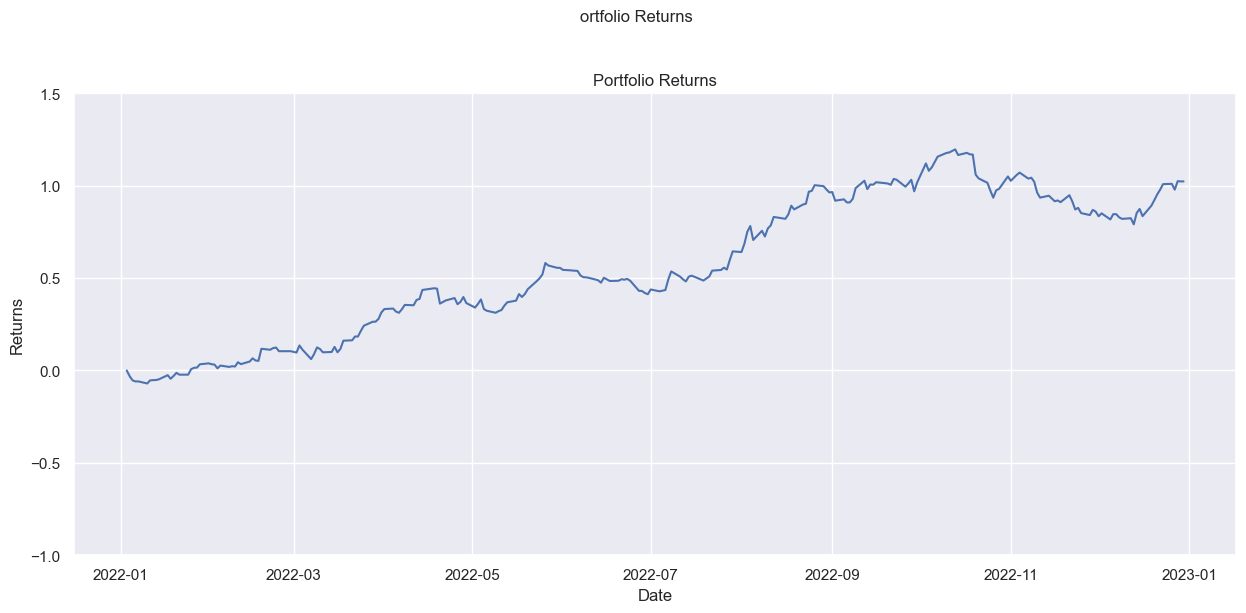

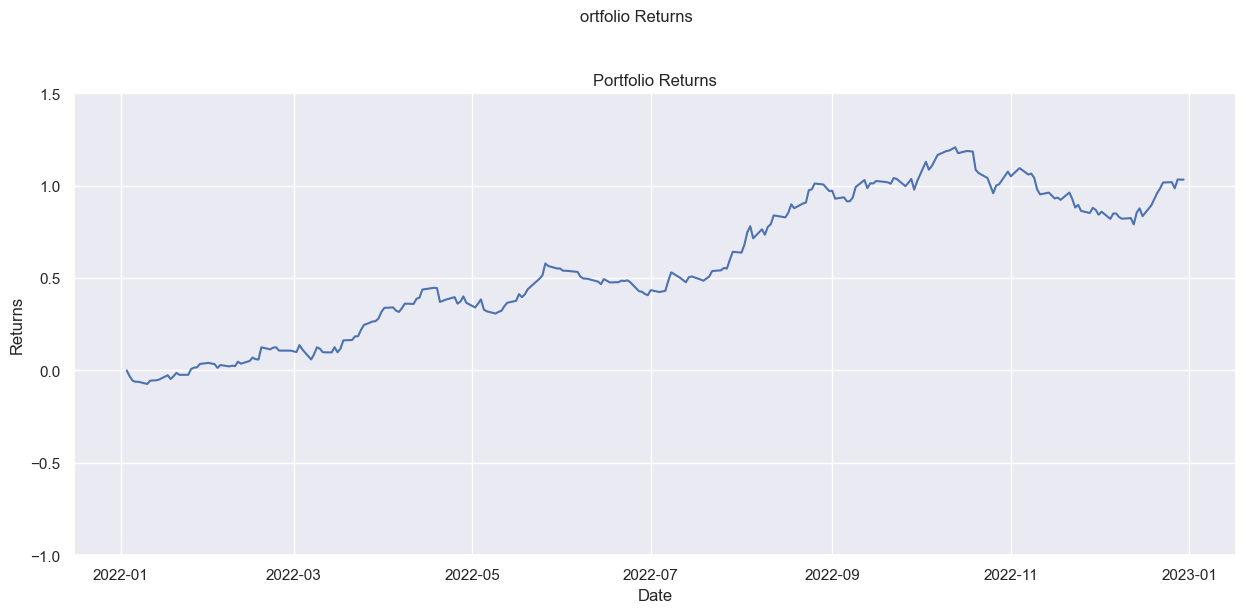

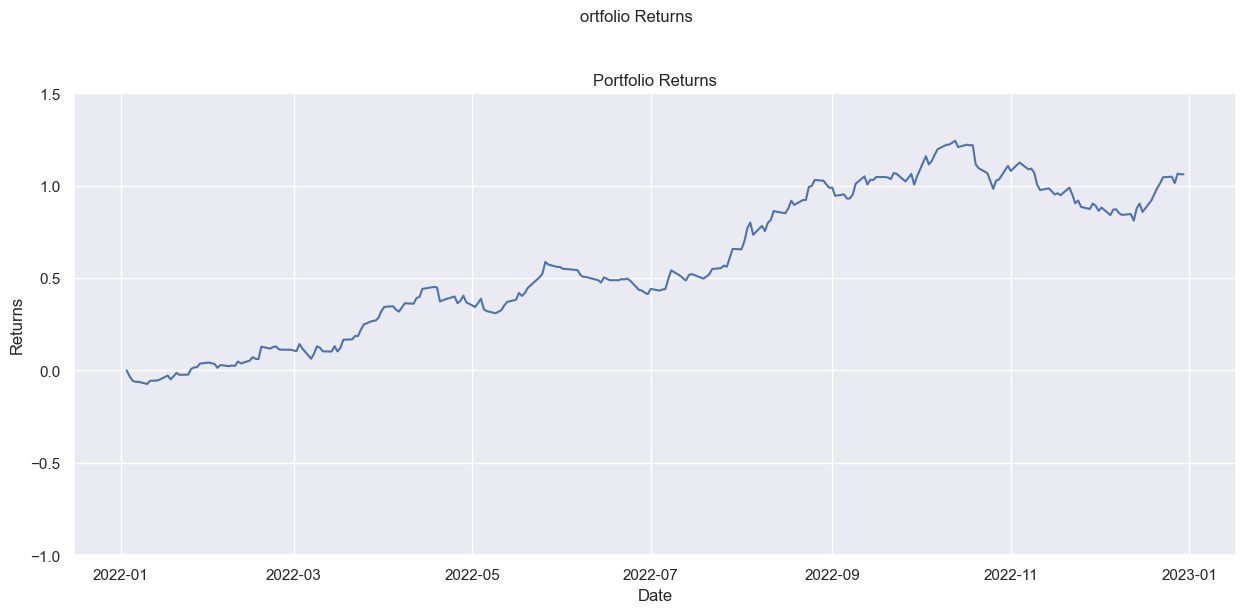

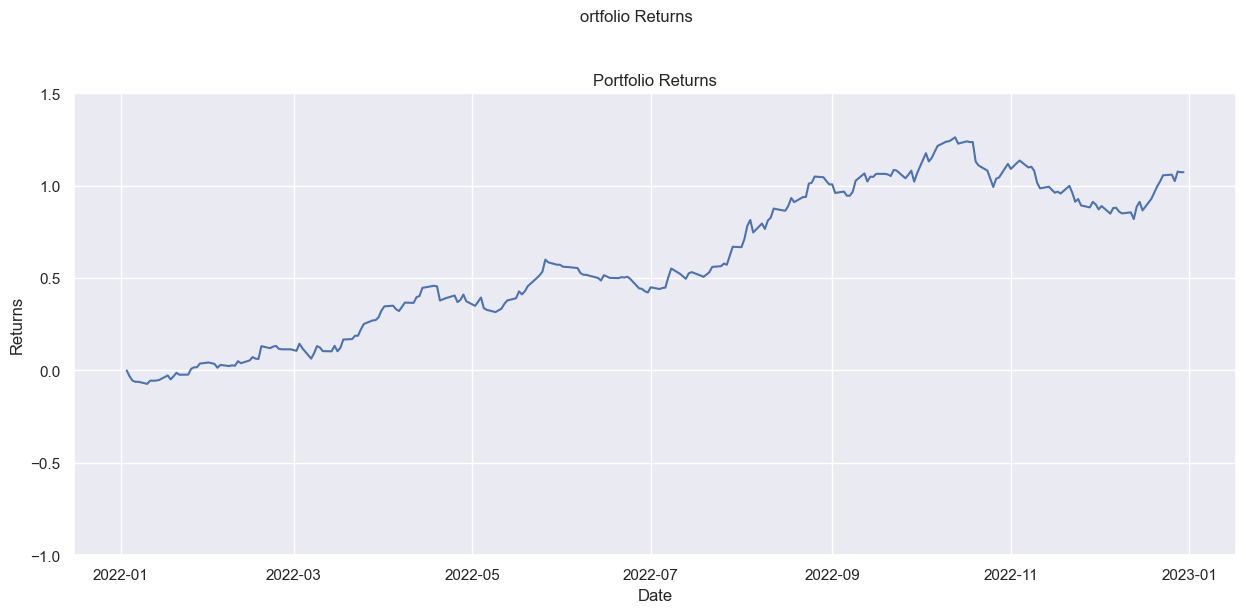

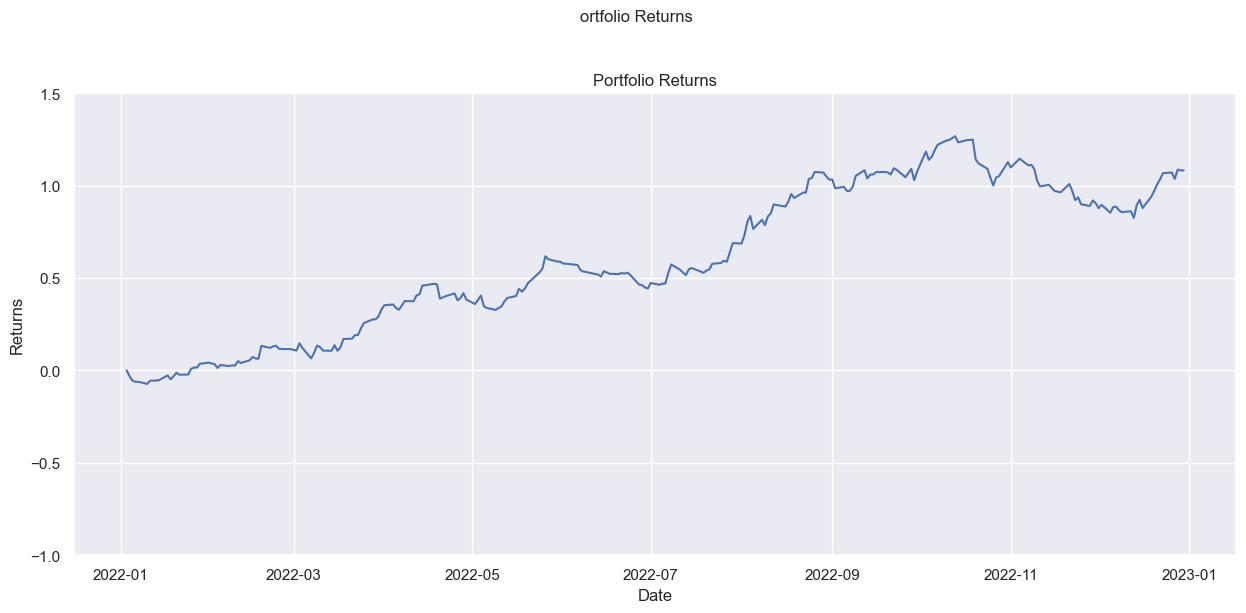

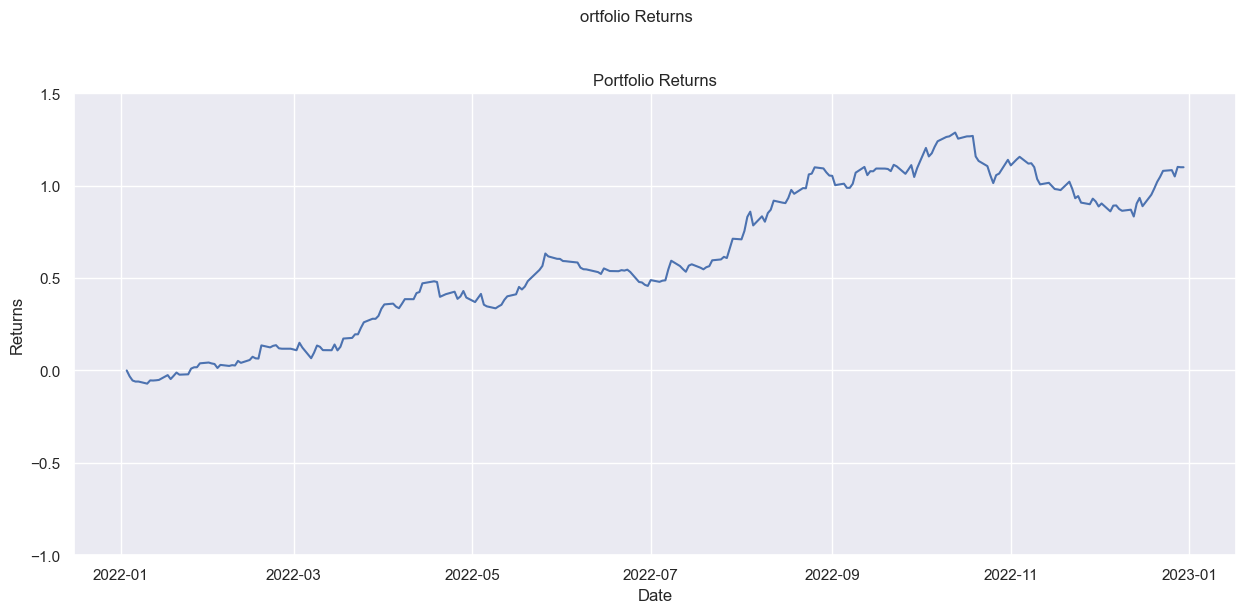

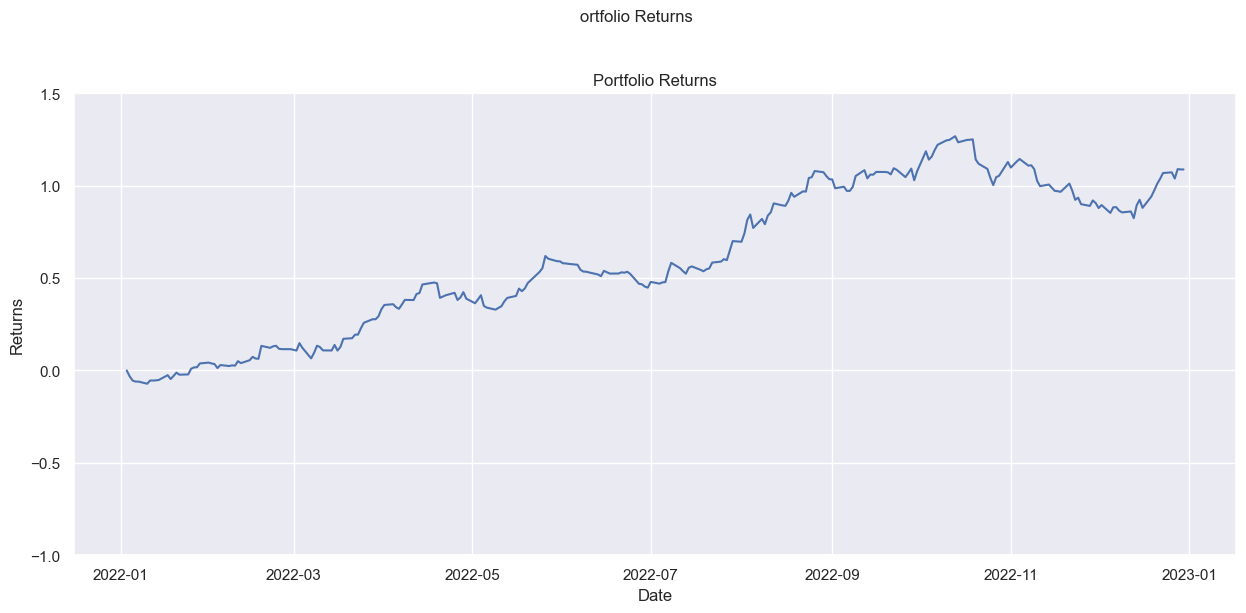

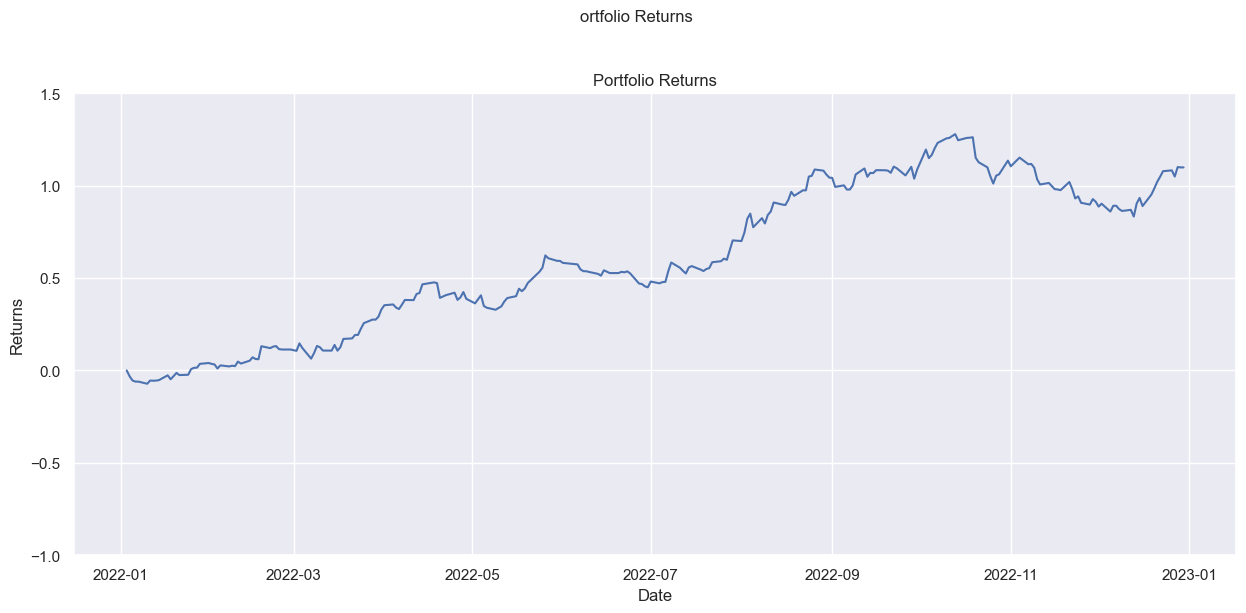

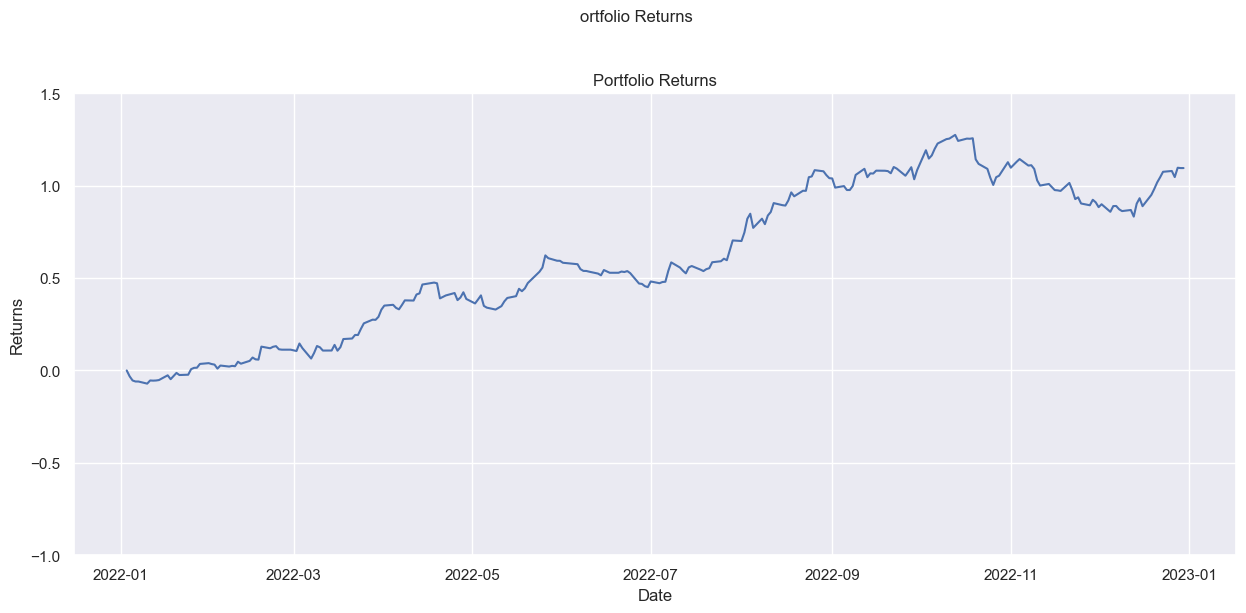

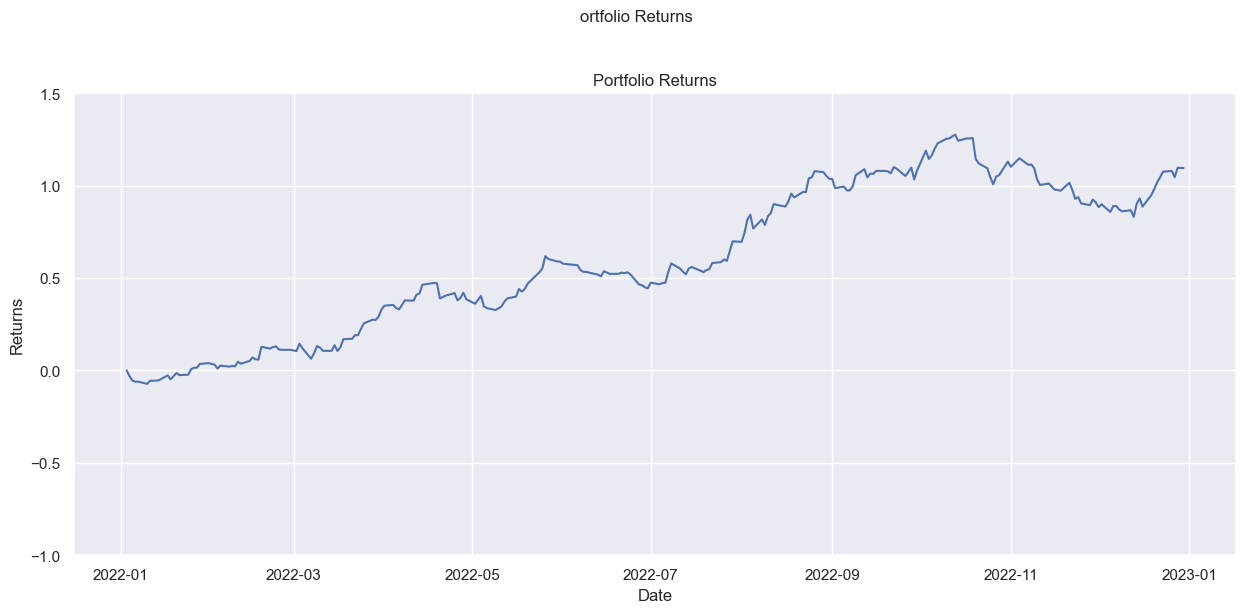

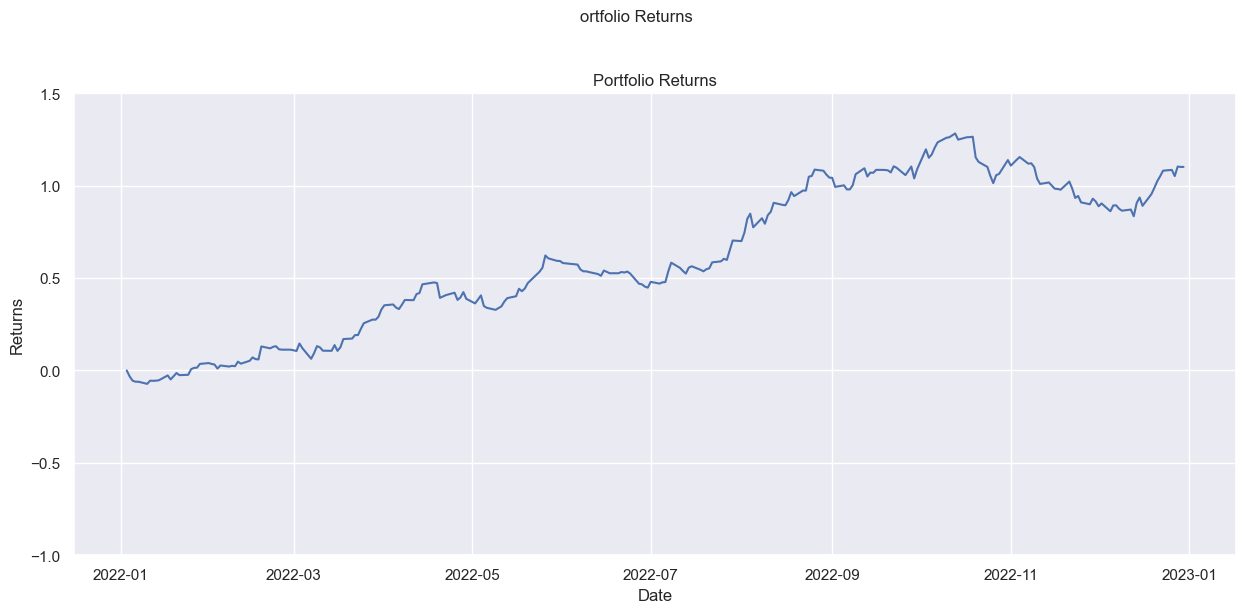

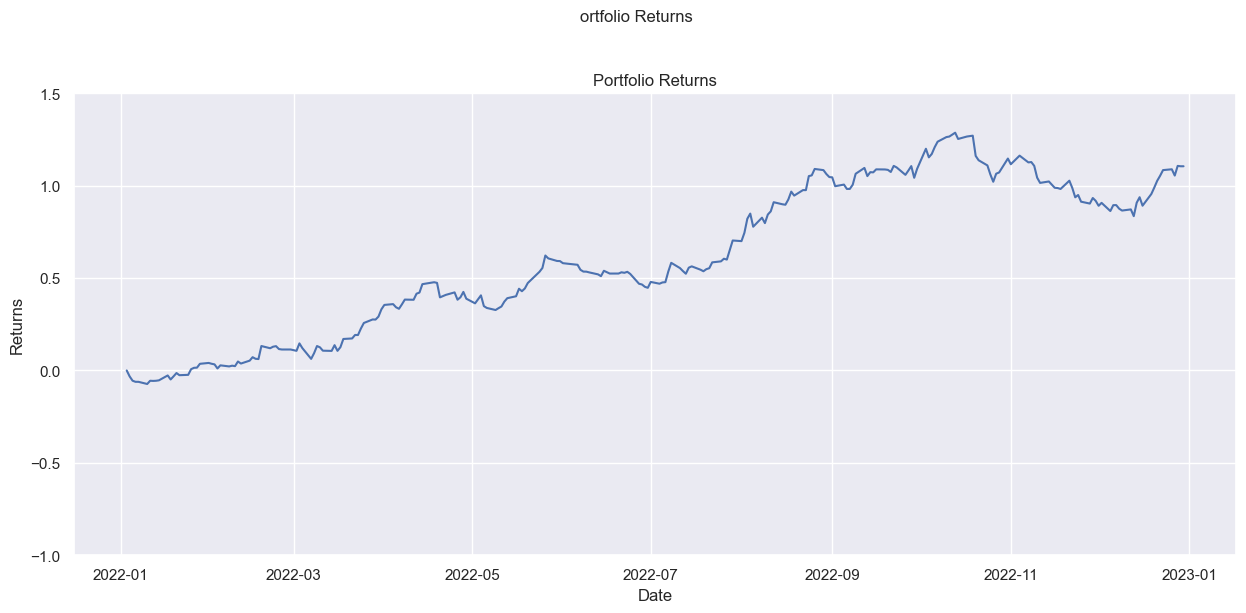

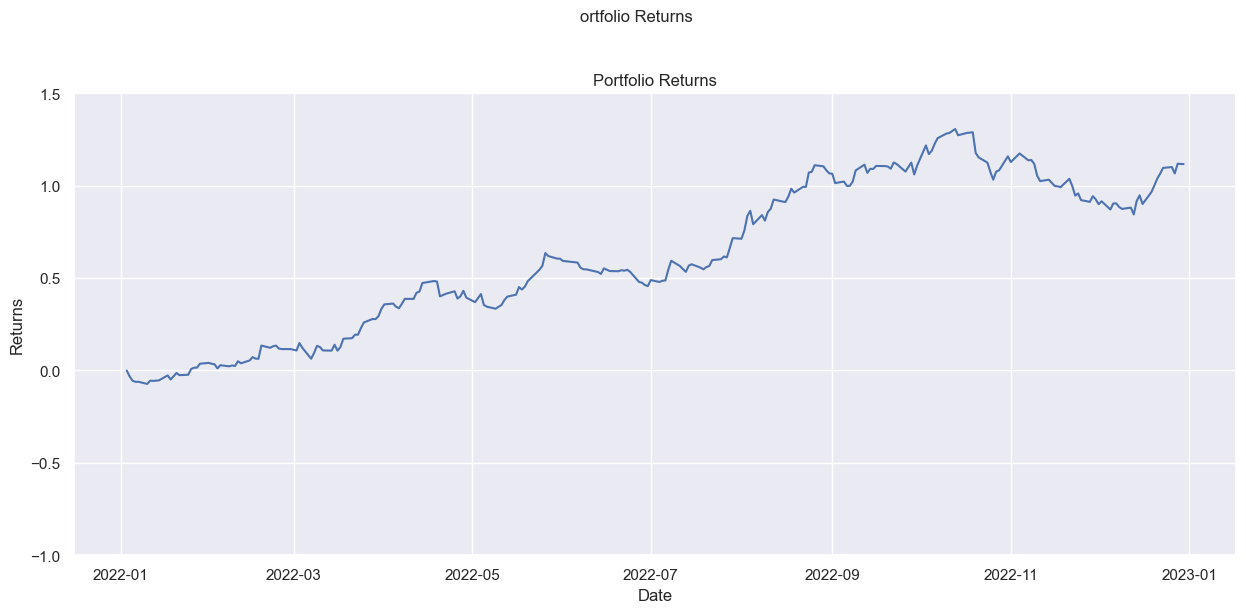

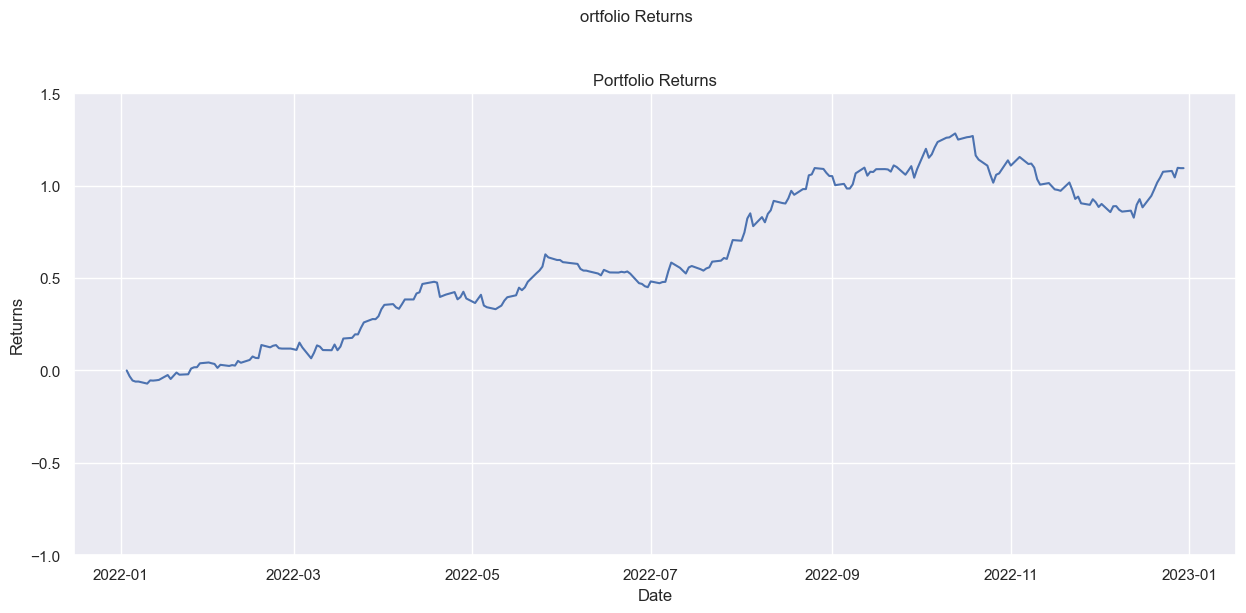

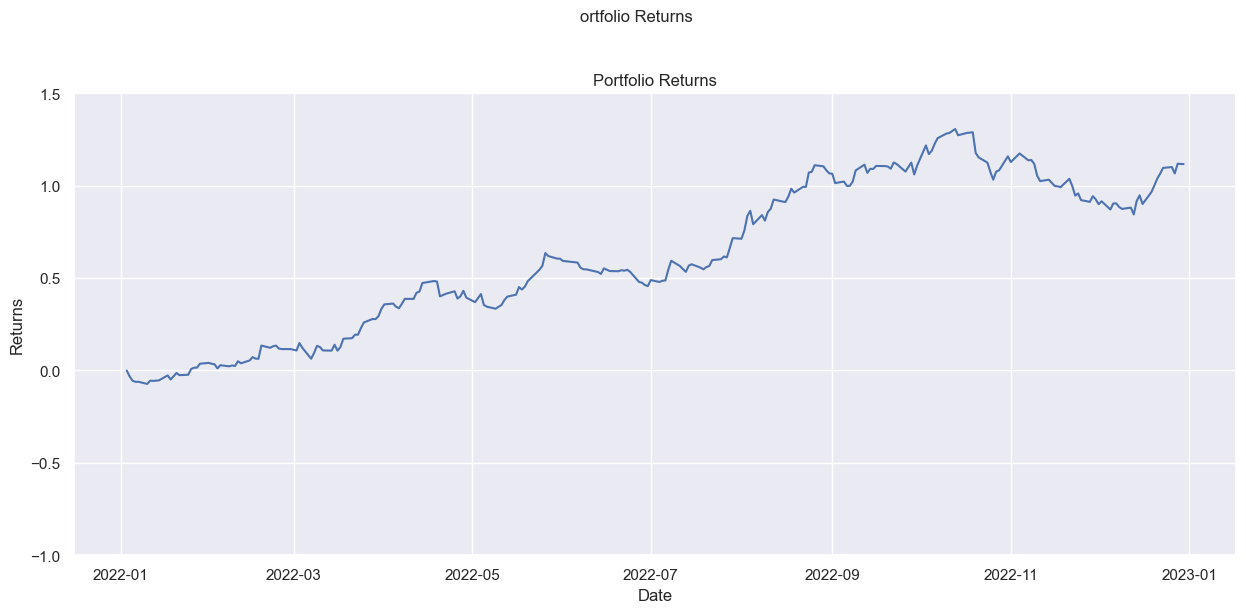

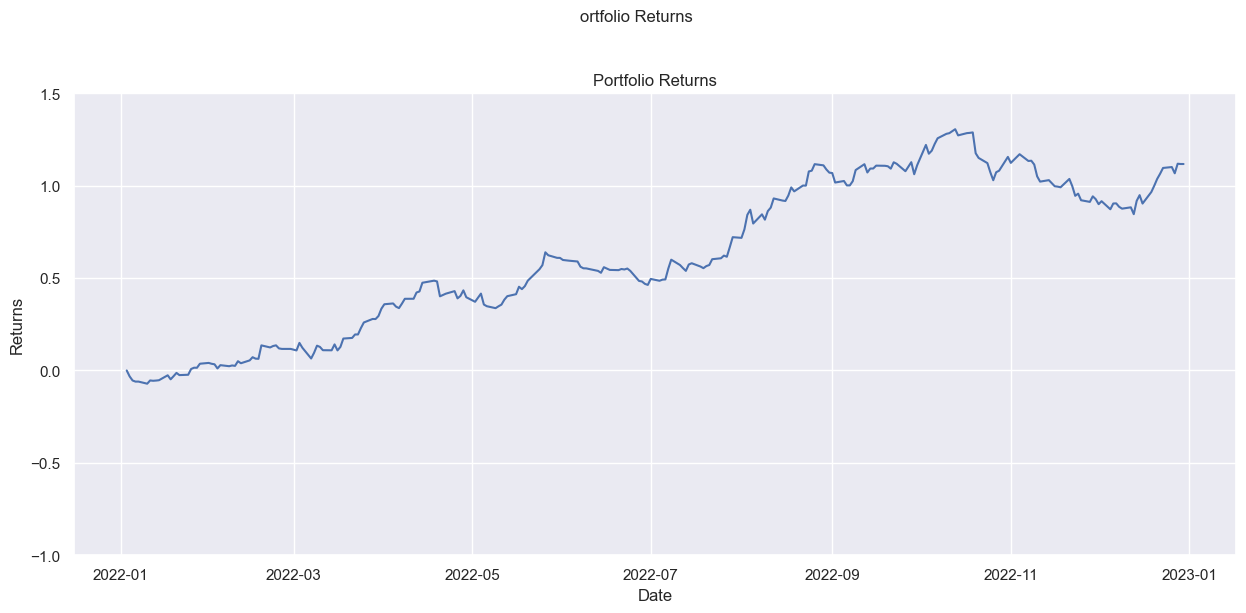

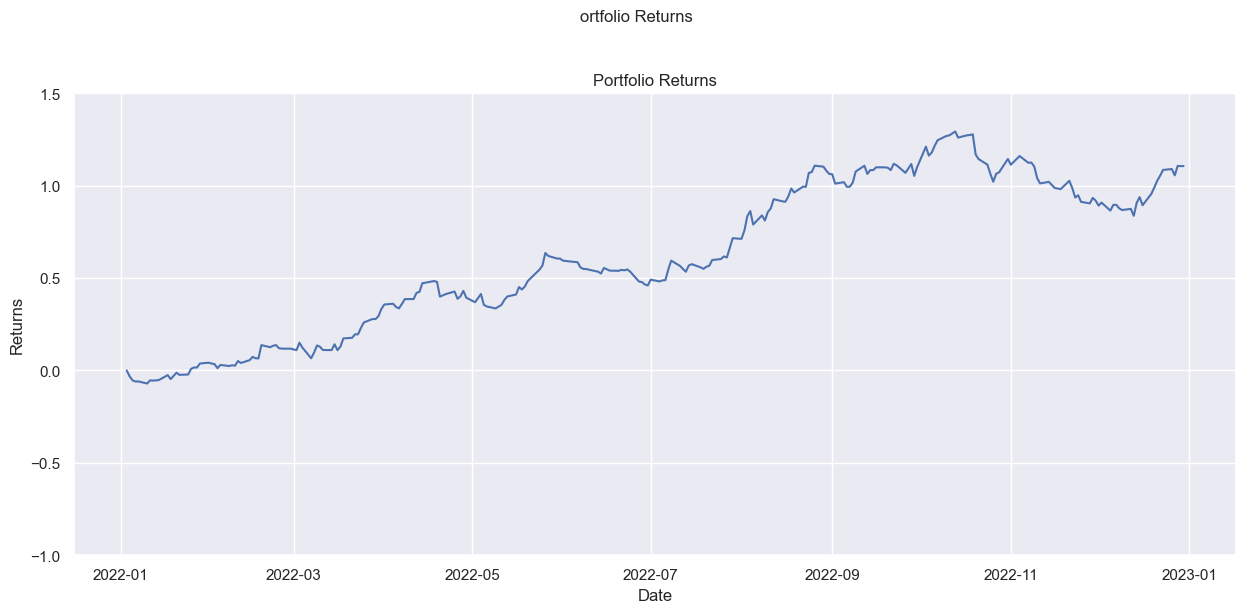

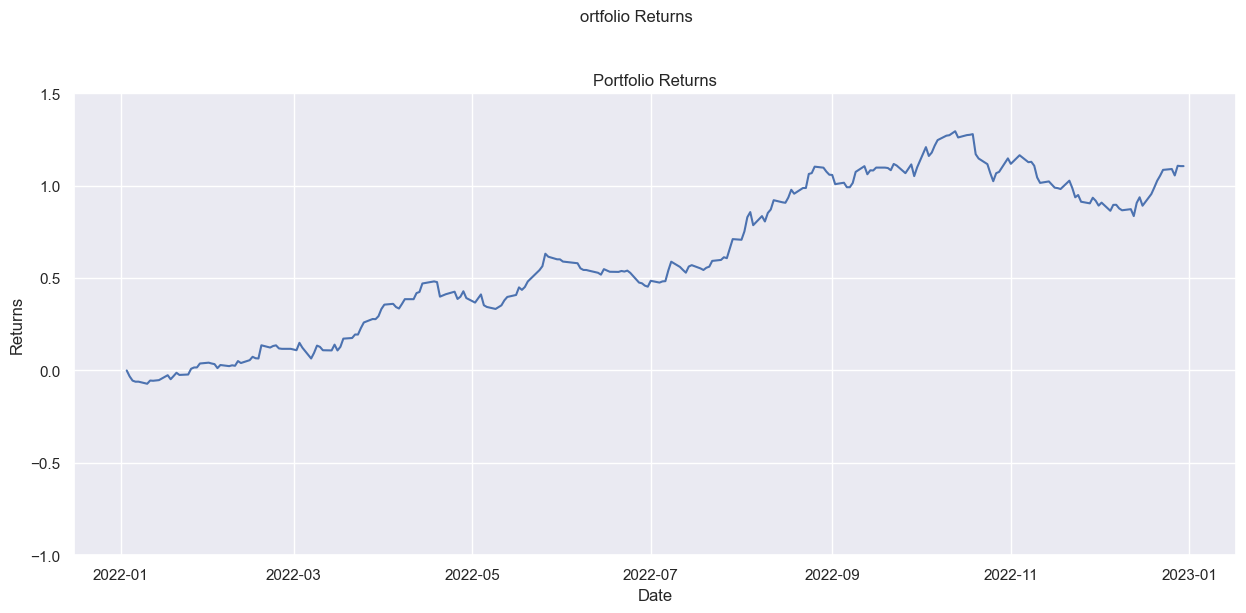

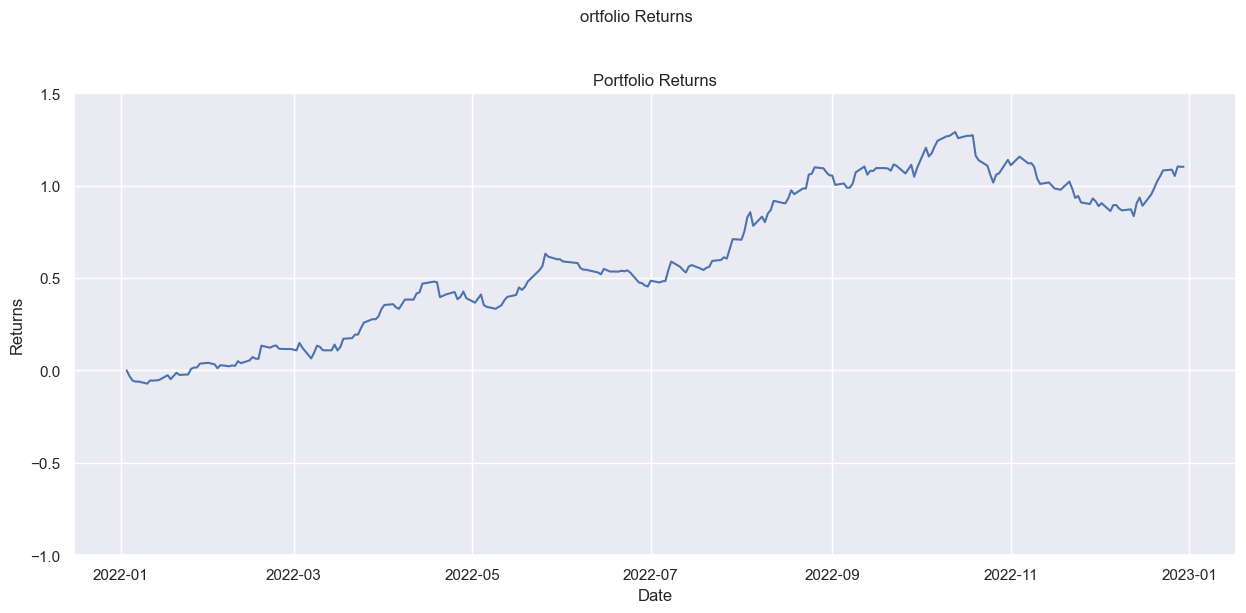

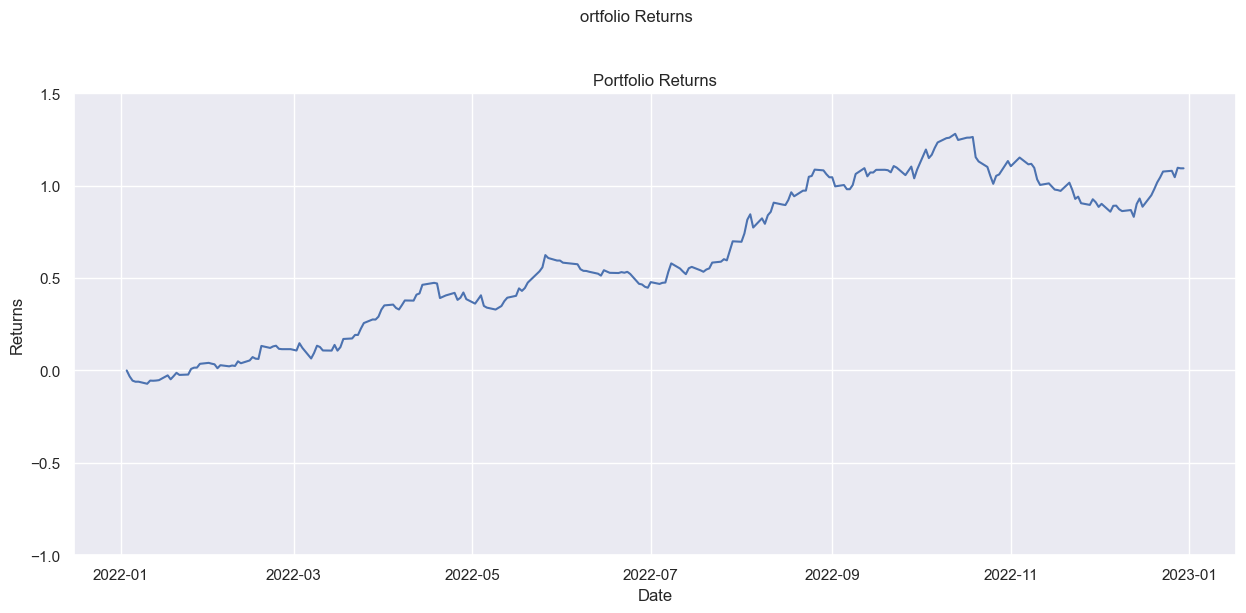

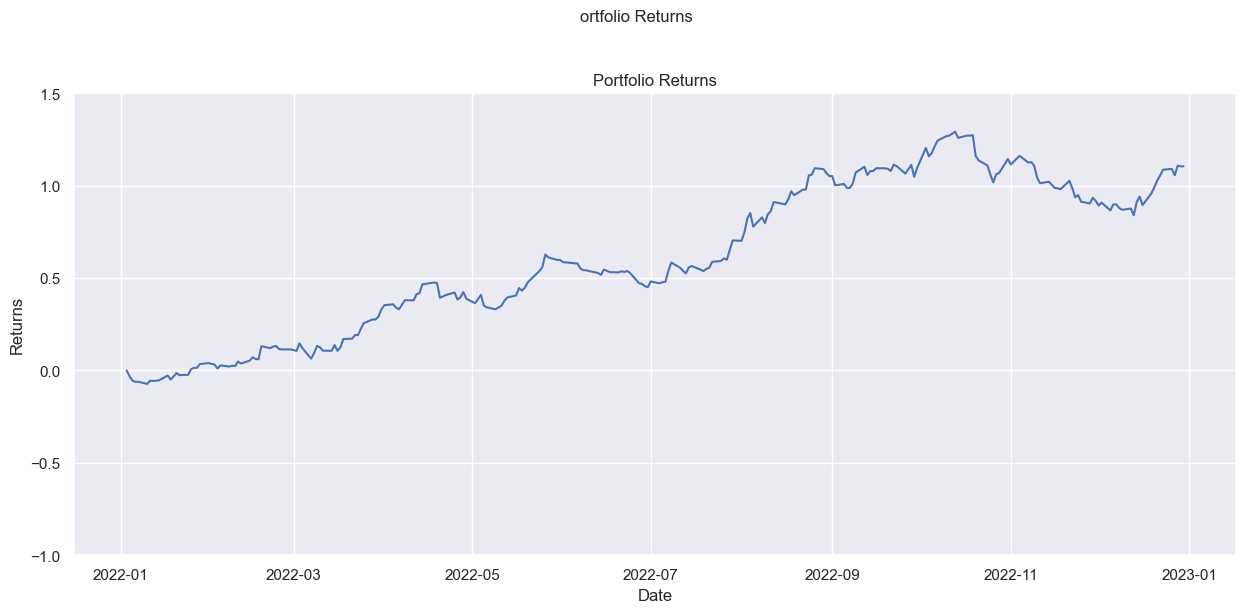

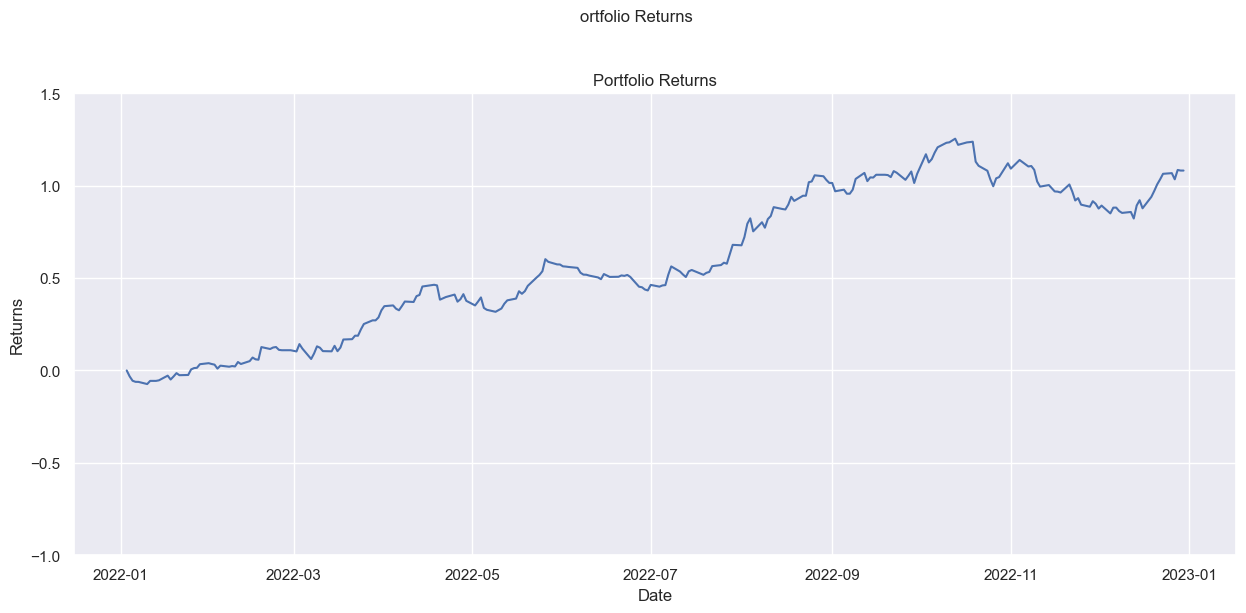

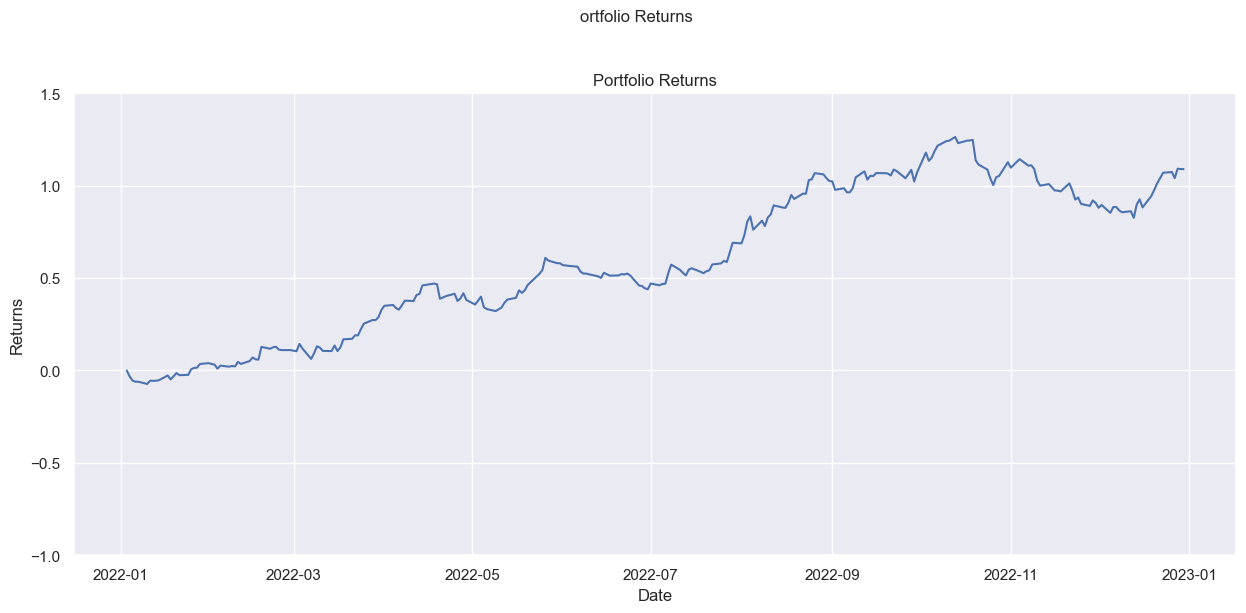

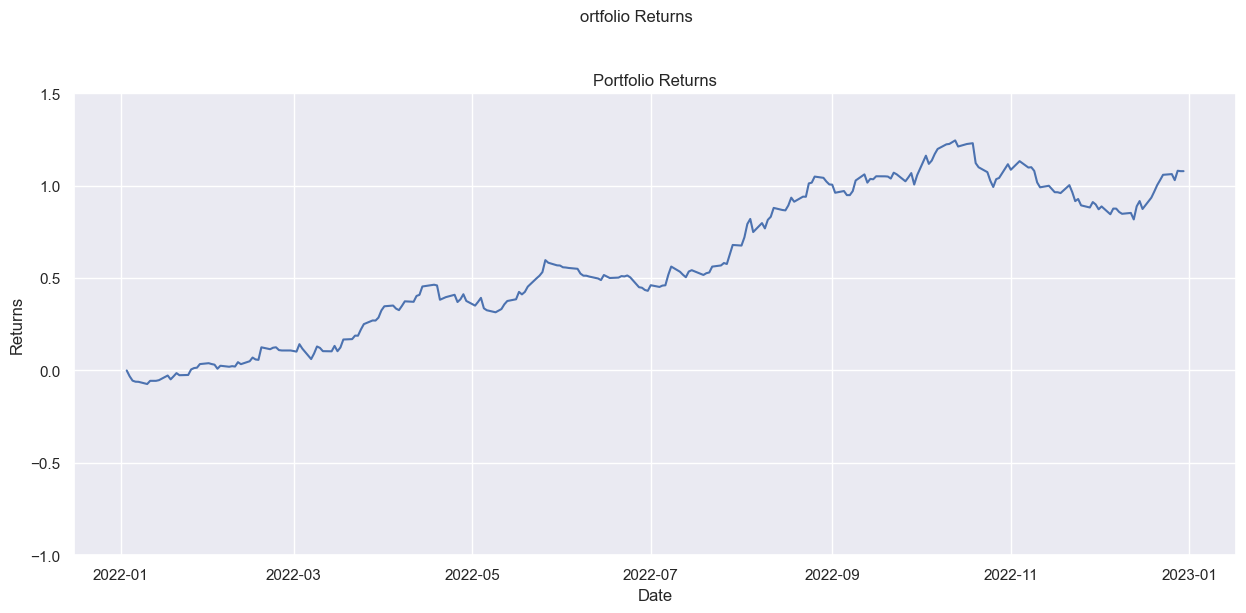

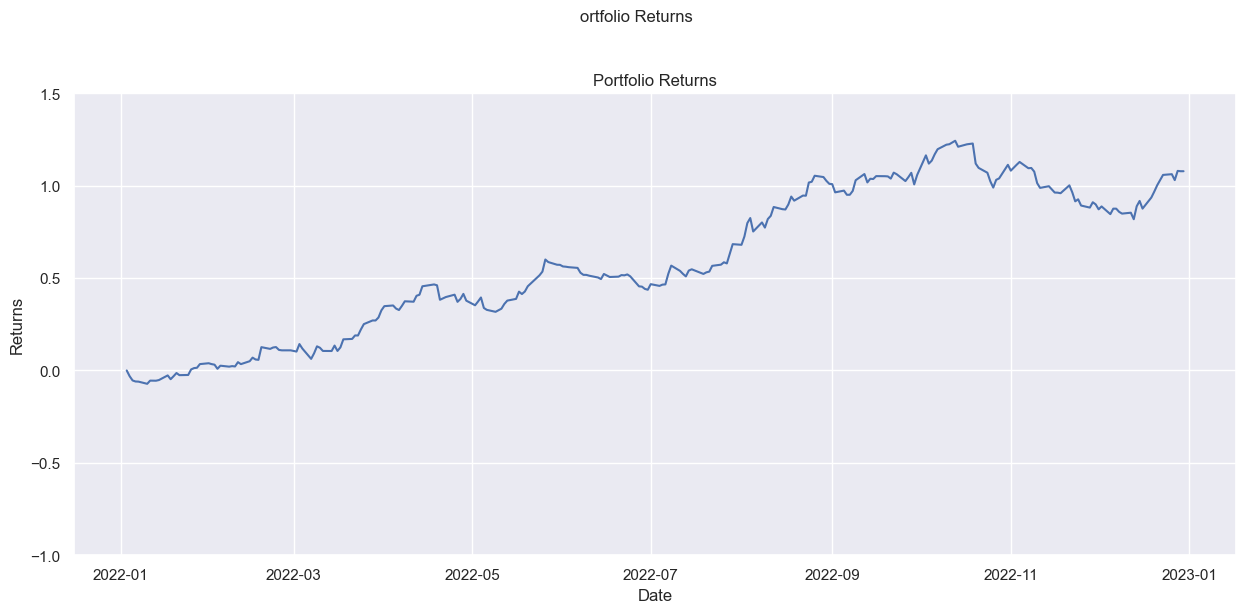

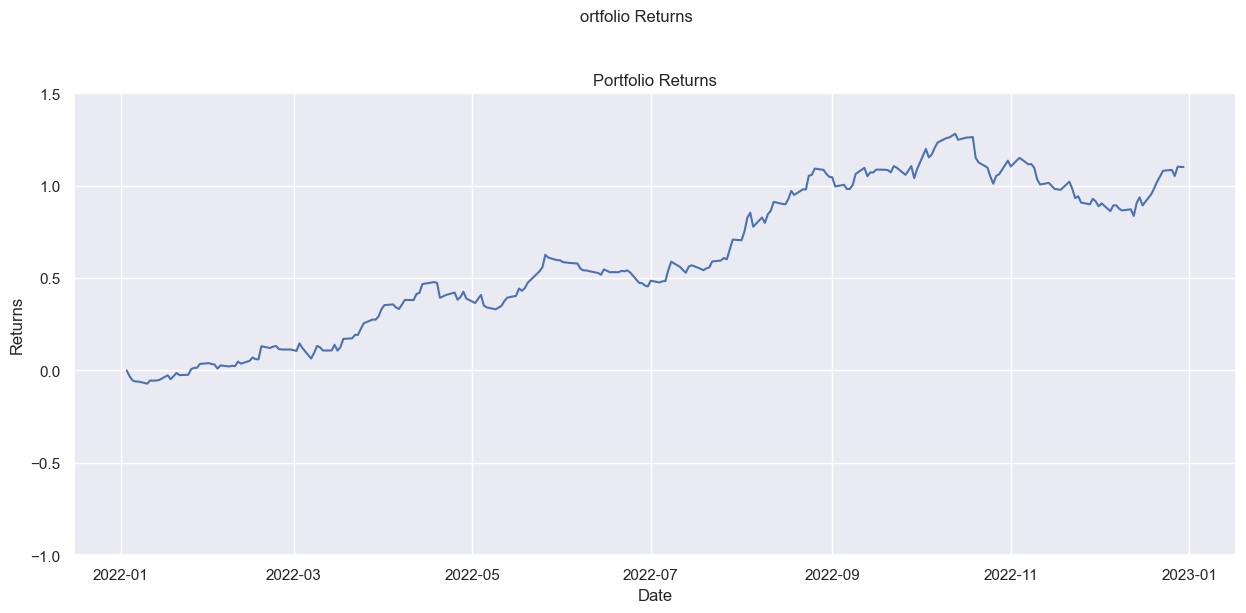

In [217]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import imageio
import os

# Create a directory to store the PNG images
if not os.path.exists('plots'):
    os.makedirs('plots')

images = []
for i in range(len(returns_list)):
    returns = returns_list[i]
    # Set Seaborn dark theme
    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(15, 6))

    sns.lineplot(x=returns.index, y=returns.values)

    # Set plot labels and title
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.title('Portfolio Returns')

    # Add subtitle
    plt.suptitle('ortfolio Returns', y=1.02, fontsize=12)
    plt.ylim(-1, 1.5)
    png_file_path = f'plots/plot_{i}.png'
    plt.savefig(png_file_path)
    images.append(png_file_path)
# Create a GIF from the saved PNG files
with imageio.get_writer('portfolio_returns.gif', duration=0.8) as gif_writer:
    for filename in images:
        img = imageio.imread(filename)
        gif_writer.append_data(img)

# Remove the temporary PNG files
for filename in images:
    os.remove(filename)

In [200]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import imageio
import os





# Create a directory to store the PNG images
if not os.path.exists('plots'):
    os.makedirs('plots')

images = []  # List to store image filenames

for i in range(len(returns_list)):
    returns = returns_list[i]

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=returns.index, y=returns.values, mode='lines', name='Portfolio Returns'))

    # Customize the layout
    fig.update_layout(
        title='Portfolio Returns Over Time',
        xaxis=dict(title='Date'),
        yaxis=dict(title='Returns'),
        template='plotly_dark'
    )
    png_file_path = f'plots/plot_{i}.png'
    pio.write_image(fig, png_file_path, format= 'png')

    # Append the filename to the list
    images.append(png_file_path)

# Create a GIF from the saved PNG files
with imageio.get_writer('portfolio_returns.gif', duration=0.5) as gif_writer:
    for filename in images:
        img = imageio.imread(filename)
        gif_writer.append_data(img)

# Remove the temporary PNG files
for filename in images:
    os.remove(filename)


ValueError: 
The kaleido executable is required by the kaleido Python library, but it was not included
in the Python package and it could not be found on the system PATH.

Searched for included kaleido executable at:
    C:\Users\Felps\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\kaleido\executable\kaleido 

Searched for executable 'kaleido' on the following system PATH:
    c:\Users\Felps\AppData\Local\Microsoft\WindowsApps
    c:\Users\Felps\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\Scripts
    C:\Users\Felps\cmder\vendor\conemu-maximus5\ConEmu\Scripts
    C:\Users\Felps\cmder\vendor\conemu-maximus5
    C:\Users\Felps\cmder\vendor\conemu-maximus5\ConEmu
    C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.2\bin
    C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.2\libnvvp
    C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.2\bin
    C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.2\libnvvp
    C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.1\bin
    C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.1\libnvvp
    C:\Program Files (x86)\Common Files\Oracle\Java\javapath
    C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.0\bin
    C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.0\libnvvp
    C:\Program Files (x86)\VMware\VMware Player\bin\
    C:\Windows\system32
    C:\Windows
    C:\Windows\System32\Wbem
    C:\Windows\System32\WindowsPowerShell\v1.0\
    C:\Windows\System32\OpenSSH\
    C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common
    C:\Program Files\Docker\Docker\resources\bin
    C:\Program Files\Git\cmd
    C:\Program Files\nodejs\
    C:\Program Files\NVIDIA Corporation\NVIDIA NvDLISR
    C:\Program Files\CMake\bin
    C:\Program Files\NVIDIA Corporation\Nsight Compute 2023.2.0\
    C:\Strawberry\c\bin
    C:\Strawberry\perl\site\bin
    C:\Strawberry\perl\bin
    C:\Users\Felps\AppData\Local\Microsoft\WindowsApps
    C:\Users\Felps\AppData\Local\GitHubDesktop\bin
    C:\Users\Felps\AppData\Local\Programs\Microsoft VS Code\bin
    C:\Spark\spark-3.3.2-bin-hadoop3-scala2.13\bin
    C:\Hadoop\bin
    C:\Program Files\Java\jdk1.8.0_361\bin
    C:\Program Files\Java\jre1.8.0_361\bin
    C:\Users\Felps\AppData\Roaming\npm
    C:\Program Files\JetBrains\IntelliJ IDEA 2023.1.1\bin
    C:\Users\Felps\AppData\Local\Coursier\data\bin
    C:\Users\Felps\AppData\Local\Programs\MiKTeX\miktex\bin\x64\
    C:\Program Files\Git\mingw64\bin
    C:\Program Files\Git\usr\bin
    C:\Users\Felps\cmder\vendor\bin
    C:\Users\Felps\cmder
    C:\Users\Felps\cmder\vendor\conemu-maximus5\ConEmu\Scripts
    C:\Users\Felps\cmder\vendor\conemu-maximus5
    C:\Users\Felps\cmder\vendor\conemu-maximus5\ConEmu
    C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.2\bin
    C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.2\libnvvp
    C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.2\bin
    C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.2\libnvvp
    C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.1\bin
    C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.1\libnvvp
    C:\Program Files (x86)\Common Files\Oracle\Java\javapath
    C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.0\bin
    C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.0\libnvvp
    C:\Program Files (x86)\VMware\VMware Player\bin\
    C:\Windows\system32
    C:\Windows
    C:\Windows\System32\Wbem
    C:\Windows\System32\WindowsPowerShell\v1.0\
    C:\Windows\System32\OpenSSH\
    C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common
    C:\Program Files\Docker\Docker\resources\bin
    C:\Program Files\Git\cmd
    C:\Program Files\nodejs\
    C:\Program Files\NVIDIA Corporation\NVIDIA NvDLISR
    C:\Program Files\CMake\bin
    C:\Program Files\NVIDIA Corporation\Nsight Compute 2023.2.0\
    C:\Strawberry\c\bin
    C:\Strawberry\perl\site\bin
    C:\Strawberry\perl\bin
    C:\Users\Felps\AppData\Local\Microsoft\WindowsApps
    C:\Users\Felps\AppData\Local\GitHubDesktop\bin
    C:\Users\Felps\AppData\Local\Programs\Microsoft VS Code\bin
    C:\Spark\spark-3.3.2-bin-hadoop3-scala2.13\bin
    C:\Hadoop\bin
    C:\Program Files\Java\jdk1.8.0_361\bin
    C:\Program Files\Java\jre1.8.0_361\bin
    C:\Users\Felps\AppData\Roaming\npm
    C:\Program Files\JetBrains\IntelliJ IDEA 2023.1.1\bin
    C:\Users\Felps\AppData\Local\Coursier\data\bin
    C:\Users\Felps\AppData\Local\Programs\MiKTeX\miktex\bin\x64\
    C:\Program Files\Git\mingw64\bin
    C:\Program Files\Git\usr\bin
    C:\Users\Felps\cmder\vendor\bin
    C:\Users\Felps\cmder
    C:\Users\Felps\AppData\Local\Microsoft\WindowsApps\python3.11
